# Tutorial 1: Basics

<img src="../../imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:100%;"/>

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML)


In this tutorial you will learn how to:
* run LightAutoML training on tabular data
* obtain feature importances and reports
* configure resource usage in LightAutoML

## 0. Prerequisites

### 0.0. install LightAutoML

In [1]:
#!pip install -U lightautoml

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS and HTTP requests etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: presets for AutoML, task and report generation module

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
# Standard python libraries
import os
import json
import requests

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import ast

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task
from lightautoml.report.report_deco import ReportDeco
from tqdm.notebook import tqdm
from sklearn.metrics import pairwise_distances


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from copy import deepcopy
from scipy.spatial import distance
from sklearn.metrics import precision_recall_curve, auc, precision_score
from fuzzywuzzy import fuzz
from Levenshtein import distance as lev
from Levenshtein import ratio
from collections import defaultdict

### 0.2. Constants

Here we setup some parameters to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [4]:
N_THREADS = 16
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.1
TIMEOUT = 3000
TARGET_NAME = 'target'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [5]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [6]:
train_features = pd.read_parquet('train_data.parquet').astype({'variantid': int})
train_features.head()

variantid                                               name  \
0   51195767  Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...   
1   53565809  Магнитный кабель USB 2.0 A (m) - USB Type-C (m...   
2   56763357  Набор микропрепаратов Konus 25: "Клетки и ткан...   
3   56961772             Мобильный телефон BQ 1848 Step, черный   
4   61054740  Штатив трипод Tripod 330A для фотоаппаратов, в...   

                                          categories color_parsed  \
0  {"1": "EPG", "2": "Электроника", "3": "Сетевые...  [оранжевый]   
1  {"1": "EPG", "2": "Электроника", "3": "Кабели ...    [красный]   
2  {"1": "EPG", "2": "Электроника", "3": "Оптичес...         None   
3  {"1": "EPG", "2": "Электроника", "3": "Смартфо...     [черный]   
4  {"1": "EPG", "2": "Электроника", "3": "Штативы...     [черный]   

                            pic_embeddings_resnet_v1  \
0                                               None   
1  [[0.26863545, -0.3130674, 0.29023397, 0.073978...   
2  [[0.66954195, 1.0643557, 0.78324044, -0.338267...   
3  [[0.6580482, -0.35763323, -0.16939065, -0.4249...   
4  [[-0.10406649, 0.080646515, -0.28668788, 0.739...   

                       main_pic_embeddings_resnet_v1  \
0  [[0.04603629, 0.18839523, -0.09973055, -0.6636...   
1  [[1.1471839, -0.665361, 0.7745614, 0.26716197,...   
2  [[-0.90570974, 1.0296293, 1.0769907, 0.27746, ...   
3  [[0.13133773, -0.5577079, 0.32498044, 0.191717...   
4  [[0.21696381, 0.10989461, -0.08012986, 0.69186...   

                                        name_bert_64  \
0  [-0.47045058, 0.67237014, 0.48984158, -0.54485...   
1  [-0.6575592, 0.6522429, 0.5426037, -0.54347897...   
2  [-0.7384308, 0.70784587, 0.3012653, -0.3583719...   
3  [-0.44812852, 0.5283565, 0.28981736, -0.506841...   
4  [-0.72692573, 0.75206333, 0.37740713, -0.52502...   

                   characteristic_attributes_mapping  
0  {"Номинальный ток, А":["10"],"Цвет товара":["о...  
1  {"Конструктивные особенности":["Магнитная конс...  
2  {"Тип аксессуара":["Набор микропрепаратов"],"Б...  
3  {"Тип карты памяти":["microSD"],"Число SIM-кар...  
4  {"Материал":["Металл"],"Количество секций, шт"...

In [6]:
train_pairs = pd.read_parquet('train_pairs_after_split_v2.parquet').astype({'variantid1': int, 'variantid2': int})
valid_pairs = pd.read_parquet('val_pairs_v2.parquet').astype({'variantid1': int, 'variantid2': int})

In [7]:
test_pairs = pd.read_parquet('test_pairs_wo_target.parquet').astype({'variantid1': int, 'variantid2': int})
test_features = pd.read_parquet('test_data.parquet').astype({'variantid': int})
test_pairs.head()

variantid1  variantid2
0    52076340   290590137
1    64525522   204128919
2    77243372   479860557
3    86065820   540678372
4    91566575   258840506

In [8]:
attr = pd.read_parquet('attrdataset_cross.parquet')
attr.head()

target  variantid1  variantid2 Цвет товара  matched_number  \
0     0.0    51197862    51198054        True            15.0   
1     1.0    53062686   536165289        None             2.0   
2     1.0    53602615   587809782        None             1.0   
3     1.0    53888651    89598677        True            16.0   
4     0.0    56930698   551526166        True             2.0   

   unmatched_number  Бренд Страна-изготовитель   Тип Номинальный ток, А  ...  \
0             829.0   True                None  True               True  ...   
1             833.0   True                None  True               None  ...   
2             834.0  False                None  True               None  ...   
3             822.0   True                None  None               None  ...   
4             836.0  False                None  True               None  ...   

  Оттенок света Тип МФУ Особенности сетевого оборудования Электробезопасность  \
0         False   False                             False                True   
1         False   False                             False               False   
2         False   False                             False               False   
3         False   False                             False               False   
4         False   False                             False               False   

  Бренд графического процессора Максимальное проекционное соотношение  \
0                         False                                 False   
1                         False                                 False   
2                         False                                 False   
3                         False                                 False   
4                         False                                 False   

  Минимальная выдержка, сек Количество копий, шт. Форматы книг  \
0                     False                 False        False   
1                     False                 False        False   
2                     False                 False        False   
3                     False                 False        False   
4                     False                 False        False   

  Максимальный формат  
0               False  
1               False  
2               False  
3               False  
4               False  

[5 rows x 1385 columns]

In [9]:
smart_tokens = pd.read_parquet('data_names_smart_tok_bert_diff_characteristics_bm25_char.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})

smart_tokens['fuzz_clean_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_clean_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_clean_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_clean_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['lev_clean_name'] = smart_tokens.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_clean_name'] = smart_tokens.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_service_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_service_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_service_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_service_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['lev_service_name'] = smart_tokens.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_service_name'] = smart_tokens.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_diff_name'] = smart_tokens.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_diff_name'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_diff_name'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_diff_name'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['lev_diff_name'] = smart_tokens.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_diff_name'] = smart_tokens.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)

smart_tokens['fuzz_attr'] = smart_tokens.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_partial_attr'] = smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_token_attr'] = smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['fuzz_WRatio_attr'] = smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['lev_attr'] = smart_tokens.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
smart_tokens['lev_ratio_attr'] = smart_tokens.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)

smart_tokens

variantid1  variantid2  \
0         51197862    51198054   
1         51197862    51199884   
2         53602615   587809782   
3         53602615   615149925   
4         53888651    89598677   
...            ...         ...   
306535   724972274   724975774   
306536   736073145   760271853   
306537   738418812   755700987   
306538   774668859   774706373   
306539   815637954   817550808   

                              diff_text_characteristics_1  \
0                                                           
1                                                           
2       Назначение: для лазерного принтера Совместимые...   
3       Назначение: для лазерного принтера Совместимые...   
4       Android,PC,iOS Бесконтактная оплата: зарядки м...   
...                                                   ...   
306535                                                 11   
306536  Интерфейсы: 2.0 Материал корпуса флеш-накопите...   
306537                                            Вьетнам   
306538                                             9х8000   
306539                                              64 ГБ   

                              diff_text_characteristics_2  \
0                                                     1.5   
1                                                           
2                                              Нет бренда   
3                                                           
4       Размеры мм: 45х39х14 Название цвета: зеленый П...   
...                                                   ...   
306535                                                 XR   
306536                                         Нет бренда   
306537  Цветность дисплея: Монохромный Цвет товара: че...   
306538                                            12х8000   
306539                                               1 ТБ   

        bert_diff_characteristics  \
0                        0.587939   
1                        0.999973   
2                        0.198818   
3                        0.498681   
4                        0.680805   
...                           ...   
306535                   0.543296   
306536                   0.178361   
306537                   0.421465   
306538                   0.697023   
306539                   0.264667   

                                             clean_name_1  \
0                          Удлинитель TDM Electric Люкс м   
1                          Удлинитель TDM Electric Люкс м   
2                   Картридж лазерный Комус пурпурный для   
3                   Картридж лазерный Комус пурпурный для   
4                                    Умные часы для детей   
...                                                   ...   
306535  чехол для смартфона iPhone ФК Барселона Аргент...   
306536               Флешка OltraMax Гб чт до зап розовая   
306537                           Телефон Panasonic черный   
306538  Картридж к Brother SOK прозрачный черный мм х ...   
306539                                    Карта памяти ГБ   

                           service_name_1  \
0                   УЛ05В 5 (SQ1303-0138)   
1                   УЛ05В 5 (SQ1303-0138)   
2       729 (4368B002) CanonLBP7010C/7018   
3       729 (4368B002) CanonLBP7010C/7018   
4                                      S4   
...                                   ...   
306535                       1LH 11 QAX14   
306536             50 64 USB2.0 15 Мб/с 8   
306537                       KX-HDV100RUB   
306538         этикет-принтеру TZE121 9 8   
306539                                 64   

                                             clean_name_2  \
0                          Удлинитель TDM Electric Люкс м   
1                          Удлинитель TDM Electric Люкс м   
2                         Картридж лазерный Комус чер для   
3                         Картридж лазерный Комус пур для   
4                            Умные часы для детей зеленый   
...                                             

In [10]:
test_smart_tokens.head()

NameError: name 'test_smart_tokens' is not defined

In [11]:
test_smart_tokens = pd.read_parquet('test_data_names_smart_tok_bert_diff_characteristics_bm25_char.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})


test_smart_tokens['fuzz_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_clean_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_clean_name'] = test_smart_tokens.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_clean_name'] = test_smart_tokens.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_service_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_service_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_service_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_service_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_service_name'] = test_smart_tokens.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_service_name'] = test_smart_tokens.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_diff_name'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_diff_name'] = test_smart_tokens.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_diff_name'] = test_smart_tokens.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)


test_smart_tokens['fuzz_attr'] = test_smart_tokens.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_partial_attr'] = test_smart_tokens.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_token_attr'] = test_smart_tokens.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['fuzz_WRatio_attr'] = test_smart_tokens.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['lev_attr'] = test_smart_tokens.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
test_smart_tokens['lev_ratio_attr'] = test_smart_tokens.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)


test_smart_tokens.head()

variantid1  variantid2  bm25_smart_tok  \
0    52076340   290590137       -6.591674   
1    64525522   204128919      -43.120532   
2    77243372   479860557       -5.493061   
3    86065820   540678372      -14.007307   
4    91566575   258840506      -17.577797   

                         diff_text_characteristics_1  \
0                                                 10   
1  A-GPS,GPS,ГЛОНАСС Helio P23 Mali-G71 MP2 прибл...   
2  Видео-кабель 3 Размеры мм: 170x122x34 Технолог...   
3      Особенности: игровые Совместимость: PC черный   
4  Snapdragon 439 2.0 Макс разрешение фронтальной...   

                         diff_text_characteristics_2  \
0                                                  4   
1  Mali-400 MP1 1.3 Bluetooth,GPS,Wi-Fi Пластик,С...   
2  Единиц в одном товаре: 1 HDMI-переключатель Ма...   
3  серый Размеры мм: 130 х 73 44 мм Дополнительны...   
4  WiFi: 802.11a/b/g/n Бренд карты памяти: microS...   

   bert_diff_characteristics  \
0                   0.422670   
1                   0.930691   
2                   0.579140   
3                   0.616166   
4                   0.781341   

                                        clean_name_1  \
0    Батарейка AAA щелочная Perfeo Super Alkaline шт   
1           Смартфон Ulefone Armor ГБ черный красный   
2              Цифровой кабель HDMI Full HD м чёрный   
3  Игровая мышь проводная Bloody кнопок подсветка...   
4                            Смартфон Vivo ГБ черный   

                          service_name_1  \
0                           LR03/10BL 10   
1                                X5 3/32   
2  TV-COM 1.4 (M/ M) 1080p 3 (CG150S-3M)   
3                      A4Tech P93 8 5000   
4                          Y93 1815 3/32   

                                        clean_name_2  \
0  Батарейка AAA щелочная Perfeo mini Super Alkal...   
1           Смартфон Ulefone Armor ГБ черный красный   
2                         Кабель HDMI черный подарок   
3            Мышь Bloody Bullet серый оптическая USB   
4                            Смартфон Vivo ГБ черный   

                     service_name_2  ... fuzz_token_diff_name  \
0                        LR03/2BL 2  ...                 44.0   
1                           X3 2/32  ...                 71.0   
2   1.4 (Male/Male) (CG150S-1.5M) +  ...                 60.0   
3  A4Tech P93s (8000dpi) (8 кнопок)  ...                 59.0   
4                          Y81 3/32  ...                 36.0   

  fuzz_WRatio_diff_name  lev_diff_name  lev_ratio_diff_name  fuzz_attr  \
0                  86.0           17.0             0.444444        0.0   
1                  71.0            2.0             0.714286       38.0   
2                  57.0           48.0             0.382609       21.0   
3                  60.0           49.0             0.400000       30.0   
4                  60.0            5.0             0.545455       26.0   

   fuzz_partial_attr  fuzz_token_attr  fuzz_WRatio_attr  lev_attr  \
0                0.0              0.0               0.0       2.0   
1               42.0             64.0              86.0     198.0   
2               33.0             27.0              86.0     320.0   
3               39.0             31.0              38.0      76.0   
4               31.0             39.0              86.0     238.0   

   lev_ratio_attr  
0        0.000000  
1        0.377622  
2        0.213152  
3        0.300752  
4        0.263636  

[5 rows x 38 columns]

In [12]:
fake_data = pd.read_parquet('syntetic_pos_neg_bad_cats_names_smart_tok_bert_cosine+characteristics+bm25.parquet') \
    .drop(columns=['name_toked_1','name_toked_2']) \
    .astype({'variantid1': int, 'variantid2': int})

fake_data['fuzz_clean_name'] = fake_data.apply(lambda row: fuzz.ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_clean_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_clean_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_clean_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['lev_clean_name'] = fake_data.apply(lambda row: lev(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_clean_name'] = fake_data.apply(lambda row: ratio(row.clean_name_1, row.clean_name_2), axis=1).astype(np.float32)


fake_data['fuzz_service_name'] = fake_data.apply(lambda row: fuzz.ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_service_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_service_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_service_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['lev_service_name'] = fake_data.apply(lambda row: lev(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_service_name'] = fake_data.apply(lambda row: ratio(row.service_name_1, row.service_name_2), axis=1).astype(np.float32)


fake_data['fuzz_diff_name'] = fake_data.apply(lambda row: fuzz.ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_diff_name'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_token_diff_name'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_diff_name'] = fake_data.apply(lambda row: fuzz.WRatio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['lev_diff_name'] = fake_data.apply(lambda row: lev(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)
fake_data['lev_ratio_diff_name'] = fake_data.apply(lambda row: ratio(row.diff_name_1, row.diff_name_2), axis=1).astype(np.float32)


fake_data['fuzz_attr'] = fake_data.apply(lambda row: fuzz.ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_partial_attr'] = fake_data.apply(lambda row: fuzz.partial_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_token_attr'] = fake_data.apply(lambda row: fuzz.token_sort_ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['fuzz_WRatio_attr'] = fake_data.apply(lambda row: fuzz.WRatio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['lev_attr'] = fake_data.apply(lambda row: lev(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)
fake_data['lev_ratio_attr'] = fake_data.apply(lambda row: ratio(row.diff_text_characteristics_1, row.diff_text_characteristics_2), axis=1).astype(np.float32)


fake_data.head()

variantid1  variantid2                                       clean_name_1  \
0   770361426   770361545                    Чехол для телефона Apple iPhone   
1   770361426   770361456                    Чехол для телефона Apple iPhone   
2   323242367   323247231                  Ноутбук HP RAM ГБ HDD Windows Pro   
3   323242367   465777855                  Ноутбук HP RAM ГБ HDD Windows Pro   
4   296641736   465777855  Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Graphic...   

                                   service_name_1  \
0                                                   
1                                                   
2                                        255 G8 8   
3                                        255 G8 8   
4  15.6" 255 G8 (3V5H6EA) 5 5500U (2.1 ГГц) 8 256   

                                        clean_name_2  \
0                    Чехол для телефона Apple iPhone   
1                    Чехол для телефона Apple iPhone   
2                  Ноутбук HP RAM ГБ HDD Windows Pro   
3  Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Vega Wi...   
4  Ноутбук HP AMD Ryzen RAM ГБ SSD Radeon Vega Wi...   

                                     service_name_2  \
0                                                     
1                                                     
2                                          255 G8 8   
3  15.6" 255 G8 5 5500U (2.1 ГГц) 8 256 7 (3V5H1EA)   
4  15.6" 255 G8 5 5500U (2.1 ГГц) 8 256 7 (3V5H1EA)   

                             diff_name_1  \
0                                          
1                                          
2                                          
3                                    HDD   
4  (3V5H6EA) Graphics Без системы черный   

                                         diff_name_2  bert_clean_name  \
0                                                            0.999861   
1                                                            0.999861   
2                                                            0.999826   
3  15.6" AMD Ryzen 5 5500U (2.1 ГГц) SSD 256 Rade...         0.907914   
4                       Vega 7 Windows Pro (3V5H1EA)         0.638289   

   bert_diff_name  ... fuzz_token_diff_name fuzz_WRatio_diff_name  \
0        1.000000  ...                100.0                   0.0   
1        1.000000  ...                100.0                   0.0   
2        1.000000  ...                100.0                   0.0   
3        0.474900  ...                 10.0                  20.0   
4        0.481103  ...                 36.0                  34.0   

   lev_diff_name  lev_ratio_diff_name  fuzz_attr  fuzz_partial_attr  \
0            0.0             1.000000       60.0               75.0   
1            0.0             1.000000        0.0                0.0   
2            0.0             1.000000       55.0               57.0   
3           63.0             0.058824        4.0               35.0   
4           32.0             0.246154       27.0               34.0   

   fuzz_token_attr  fuzz_WRatio_attr  lev_attr  lev_ratio_attr  
0             60.0              68.0       6.0        0.600000  
1              0.0               0.0       8.0        0.000000  
2             55.0              61.0       7.0        0.545455  
3              4.0              24.0     979.0        0.037328  
4             41.0              86.0     290.0        0.272358  

[5 rows x 39 columns]

In [13]:
fake_pairs = fake_data[['variantid1','variantid2',TARGET_NAME]]

In [14]:
smart_tokens = pd.concat([smart_tokens, fake_data.drop(columns=[TARGET_NAME])])

In [17]:
test_pairs = test_pairs.merge(test_features[["categories", 'variantid']].add_suffix('1'),on="variantid1", how='left')
test_pairs["cat3"] = test_pairs["categories1"].apply(lambda x: json.loads(x)["3"])
test_cat3_dict = defaultdict(lambda : 'rest',
    {i:(i if k >= 50 else 'rest')  for i,k in test_pairs["cat3"].value_counts().to_dict().items()})
# test_pairs['cat3_grouped'] = test_pairs.cat3.map(test_cat3_dict.get)
test_pairs['weights'] = test_pairs.groupby('cat3_grouped')['cat3_grouped'].transform('count') / len(test_pairs)
test_pairs.drop(columns=['categories1','cat3'], inplace=True)
weights = test_pairs[['cat3_grouped', 'weights']].set_index('cat3_grouped').to_dict()['weights']

KeyError: 'categories1'

In [16]:
attr = {}
count_key = defaultdict(int)

train_features['cat3_grouped'] = train_features["categories"].apply(lambda x: test_cat3_dict[json.loads(x)["3"]])
test_features['cat3_grouped'] = test_features["categories"].apply(lambda x: test_cat3_dict[json.loads(x)["3"]])

for cat in train_features.cat3_grouped.unique():
    attr[cat] = defaultdict(set)
    for i, row in train_features[train_features.cat3_grouped==cat].iterrows():
        if row.characteristic_attributes_mapping is not None:
            for key, values in json.loads(row.characteristic_attributes_mapping).items():
                count_key[key] += 1
                for value in values:
                    if value.isdigit():
#                         value = float(value)
                        attr[cat][key].add('float')
                    else:
                        attr[cat][key].add('object')

    for i, row in test_features[test_features.cat3_grouped==cat].iterrows():
        if row.characteristic_attributes_mapping is not None:
            for key, values in json.loads(row.characteristic_attributes_mapping).items():
                count_key[key] += 1
                for value in values:
                    if value.isdigit():
#                         value = float(value)
                        attr[cat][key].add('float')
                    else:
                        attr[cat][key].add('object')
                
train_features.drop(columns=['cat3_grouped'], inplace=True)
test_features.drop(columns=['cat3_grouped'], inplace=True)

In [24]:
attr_keys = set([i for i,c in count_key.items() if c > 100])
len(attr_keys)

1021

In [25]:
def add_attr(row):
    cat = row.cat3_grouped
    a = {'variantid1': row.variantid1, 'variantid2': row.variantid2}
    att1 = row.characteristic_attributes_mapping1
    att2 = row.characteristic_attributes_mapping2
    keys = set(attr[cat].keys()) & attr_keys
    if att1 is None and att2 is None:
        return {k:-3 for k in keys}
    if att1 is None:
        return {k:-1 for k in keys}
    if att2 is None:
        return {k:-2 for k in keys}
    for key in keys:
        if key in att1.keys() and key in att2.keys():
            if len(attr[cat][key]) == 1 and list(attr[cat][key])[0] == 'float':
                a[key] = abs(float(att1[key][0]) - float(att2[key][0]))
            else:
                a[key] = int(att1[key][0] == att2[key][0])
        elif key in att1.keys():
            a[key] = -1
        elif key in att2.keys():
            a[key] = -2
        else:
            a[key] = -3
    return a

def prepare_data(data, pairs, cat_3_grouped=None, weigts=None):

    data.categories = data.categories.map(json.loads)
#     data[[f'name_{i}' for i in range(64)]] = data.name_bert_64.apply(lambda x: x.tolist()).to_list()
#     data[[f'pic_{i}' for i in range(128)]] = data.main_pic_embeddings_resnet_v1.apply(lambda x: x[0].tolist()).to_list()
    data['cnt_pics'] = data.pic_embeddings_resnet_v1.map(len, na_action='ignore')
    data['color_parsed'] = data.color_parsed.map(set, na_action='ignore')
    data.loc[data.color_parsed.isna(), 'color_parsed'] = [set([''])]*data.color_parsed.isna().sum()
    data['cnt_main_pics'] = data.main_pic_embeddings_resnet_v1.map(len, na_action='ignore')
    data['cnt_colors'] = data.color_parsed.map(len, 'ignore')
    data[['cnt_pics', 'cnt_main_pics', 'cnt_colors']] = \
        data[['cnt_pics', 'cnt_main_pics', 'cnt_colors']].fillna(0)
    
    data['cat_3'] = data.categories.apply(lambda x: x['3'])
    data['cat_4'] = data.categories.apply(lambda x: x['4'])
    data.characteristic_attributes_mapping = data.characteristic_attributes_mapping.map(json.loads, na_action='ignore')
#     data = data.set_index('variantid').to_dict('index')
    
    
    pairs = pairs \
        .merge(data.add_suffix('1'), on="variantid1", how='left') \
        .merge(data.add_suffix('2'), on="variantid2", how='left')
    
    pairs['diff_name1'] = pairs.apply(lambda row: ' '.join(sorted(list(set(row.name1.split()) - set(row.name2.split())))), axis=1)
    pairs['diff_name2'] = pairs.apply(lambda row: ' '.join(sorted(list(set(row.name2.split()) - set(row.name1.split())))), axis=1)
    
    pairs['fuzz_name'] = pairs.apply(lambda row: fuzz.ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_partial_name'] = pairs.apply(lambda row: fuzz.partial_ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_token_name'] = pairs.apply(lambda row: fuzz.token_sort_ratio(row.diff_name1, row.diff_name2), axis=1)
    pairs['fuzz_WRatio_name'] = pairs.apply(lambda row: fuzz.WRatio(row.diff_name1, row.diff_name2), axis=1)
    pairs['lev_name'] = pairs.apply(lambda row: lev(row.diff_name1, row.diff_name2), axis=1)
    pairs['lev_ratio_name'] = pairs.apply(lambda row: ratio(row.diff_name1, row.diff_name2), axis=1)
    
    
    pairs['fuzz_full_name'] = pairs.apply(lambda row: fuzz.ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_partial_name'] = pairs.apply(lambda row: fuzz.partial_ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_token_name'] = pairs.apply(lambda row: fuzz.token_sort_ratio(row.name1, row.name2), axis=1)
    pairs['fuzz_full_WRatio_name'] = pairs.apply(lambda row: fuzz.WRatio(row.name1, row.name2), axis=1)
    pairs['lev_full_name'] = pairs.apply(lambda row: lev(row.name1, row.name2), axis=1)
    pairs['lev_ratio_full_name'] = pairs.apply(lambda row: ratio(row.name1, row.name2), axis=1)

    
    
    pairs['main1_pics2_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_mean'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).mean() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    
    
    pairs['main1_pics2_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_max'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).max() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    
    
    pairs['main1_pics2_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v11.tolist(), row.pic_embeddings_resnet_v12.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v12 is not None else -2, axis=1)
    pairs['main2_pics1_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.main_pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v11 is not None else -2, axis=1)
    pairs['pic1_pics2_cosine_min'] = pairs.apply(lambda row: pairwise_distances(
        row.pic_embeddings_resnet_v12.tolist(), row.pic_embeddings_resnet_v11.tolist(), metric='cosine'
    ).min() if row.pic_embeddings_resnet_v11 is not None and
        row.pic_embeddings_resnet_v12 is not None else -2, axis=1)

    
    tmp1 = pd.DataFrame(pairs.apply(lambda row:
        (row['name_bert_641'] * row['name_bert_642']).tolist(), axis=1).to_list(),
                       columns=[f'name1_name2_{i}' for i in range(64)])
    
    tmp2 = pd.DataFrame(pairs.apply(lambda row:
        (row['main_pic_embeddings_resnet_v11'][0]*row['main_pic_embeddings_resnet_v12'][0]).tolist(), axis=1).to_list(), 
                columns=[f'main_pic1_pic2_{i}' for i in range(128)])
    pairs = pd.concat([pairs, tmp1, tmp2], axis=1)
    
    pairs['diff_emb_name'] = pairs.apply(lambda row:
        np.linalg.norm((row['name_bert_641'] - row['name_bert_642']), ord=1), axis=1)
    pairs['diff_emb_pics'] = pairs.apply(lambda row:
        np.linalg.norm((row['main_pic_embeddings_resnet_v11'][0] - row['main_pic_embeddings_resnet_v12'][0]), ord=1), axis=1)
    
    pairs['name_braycurtis'] = pairs.apply(lambda row: distance.braycurtis(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_canberra'] = pairs.apply(lambda row: distance.canberra(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_chebyshev'] = pairs.apply(lambda row: distance.chebyshev(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_cityblock'] = pairs.apply(lambda row: distance.cityblock(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_correlation'] = pairs.apply(lambda row: distance.correlation(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_cosine'] = pairs.apply(lambda row: distance.cosine(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_euclidean'] = pairs.apply(lambda row: distance.euclidean(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_minkowski'] = pairs.apply(lambda row: distance.minkowski(row['name_bert_641'], row['name_bert_642']), axis=1)
    pairs['name_sqeuclidean'] = pairs.apply(lambda row: distance.sqeuclidean(row['name_bert_641'], row['name_bert_642']), axis=1)
    
    
    pairs['main_pic_braycurtis'] = pairs.apply(lambda row: distance.braycurtis(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_canberra'] = pairs.apply(lambda row: distance.canberra(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_chebyshev'] = pairs.apply(lambda row: distance.chebyshev(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_cityblock'] = pairs.apply(lambda row: distance.cityblock(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_correlation'] = pairs.apply(lambda row: distance.correlation(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_cosine'] = pairs.apply(lambda row: distance.cosine(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_euclidean'] = pairs.apply(lambda row: distance.euclidean(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_minkowski'] = pairs.apply(lambda row: distance.minkowski(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    pairs['main_pic_sqeuclidean'] = pairs.apply(lambda row: distance.sqeuclidean(row['main_pic_embeddings_resnet_v11'][0],row['main_pic_embeddings_resnet_v12'][0]), axis=1)
    
    
    pairs['sim_cat_3'] = pairs.apply(lambda row: int(row['cat_31'] == row['cat_32']), axis=1)
    pairs['sim_cat_4'] = pairs.apply(lambda row: int(row['cat_41'] == row['cat_42']), axis=1)
    
    pairs['cnt_overall_color'] = pairs.apply(lambda row:
        len(set(row['color_parsed1']) & set(row['color_parsed2'])), axis=1)
    
    pairs['overall_color'] = pairs.apply(lambda row: '' if row['cnt_overall_color'] == 0 else \
        list(set(row['color_parsed1']) & set(row['color_parsed2']))[0], axis=1)
    
    
    
    if cat_3_grouped is not None:
        pairs["cat3_grouped"] = pairs['cat_31'].apply(cat_3_grouped.get)
        pairs.dropna(subset=['cat3_grouped'], inplace=True)
        pairs['weights'] = pairs["cat3_grouped"].map(weights.get)
    tmp = pd.DataFrame()
    for cat in pairs["cat3_grouped"].unique():
        idx = pairs.cat3_grouped == cat
        tmp = pd.concat([tmp, pd.DataFrame(pairs.loc[idx].apply(add_attr, axis=1).to_list())])
    pairs = pairs.merge(tmp, on=['variantid1','variantid2'], how='left')
        
        
    return pairs.drop(columns=[
        'color_parsed1',
        'pic_embeddings_resnet_v11',
        'main_pic_embeddings_resnet_v11',
        'name1',
        'categories1',
        'characteristic_attributes_mapping1',
        'name_bert_641',

        'color_parsed2',
        'pic_embeddings_resnet_v12',
        'main_pic_embeddings_resnet_v12',
        'name_bert_642',
        'name2',
        'categories2',
        'characteristic_attributes_mapping2',
    ])

In [26]:
%%time
valid = prepare_data(deepcopy(train_features), deepcopy(valid_pairs), test_cat3_dict, weights)
print('complete valid')
train = prepare_data(deepcopy(train_features), deepcopy(pd.concat([train_pairs, fake_pairs])), test_cat3_dict, weights)
print('complete train')
test = prepare_data(deepcopy(test_features), deepcopy(test_pairs))
print('complete test')

NameError: name 'weights' is not defined

In [13]:
%%time

train = train.merge(smart_tokens, on=['variantid1','variantid2'], how='left')
valid = valid.merge(smart_tokens, on=['variantid1','variantid2'], how='left')
test = test.merge(test_smart_tokens, on=['variantid1','variantid2'], how='left')

NameError: name 'train' is not defined

In [11]:
%%time
train = train.merge(pd.read_parquet('train_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))
valid = valid.merge(pd.read_parquet('val_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))
test = test.merge(pd.read_parquet('test_data_bert_names+characteristics.parquet').astype({'variantid1': int, 'variantid2': int}).rename(columns={'preds': 'bert_sat'}))

NameError: name 'train' is not defined

In [12]:
train['diff_id'] = train.variantid1 - train.variantid2
valid['diff_id'] = valid.variantid1 - valid.variantid2
test['diff_id'] = test.variantid1 - test.variantid2

train['abs_diff_id'] = abs(train.variantid1 - train.variantid2)
valid['abs_diff_id'] = abs(valid.variantid1 - valid.variantid2)
test['abs_diff_id'] = abs(test.variantid1 - test.variantid2)

NameError: name 'train' is not defined

### 0.5. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

Note: missing values (NaN and other) in the data should be left as is, unless the reason for their presence or their specific meaning are known. Otherwise, AutoML model will perceive the filled NaNs as a true pattern between the data and the target variable, without knowledge and assumptions about missing values, which can negatively affect the model quality. LighAutoML can deal with missing values and outliers automatically.

## 1. Task definition

### 1.1. Task type

First we need to create ```Task``` object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation).

The following task types are available:

- ```'binary'``` - for binary classification.

- ```'reg’``` - for regression.

- ```‘multiclass’``` - for multiclass classification.

- ```'multi:reg``` - for multiple regression.

- ```'multilabel'``` - for multi-label classification.

In this example we will consider a binary classification:

In [14]:
def metric(y_true, y_pred, sample_weight, **kwargs):
    
    if sample_weight is None:
        sample_weight = np.array([1] * len(y_true))
    
    pr_aucs = []
    weights = []
    
    for w in np.unique(sample_weight):
        idx = sample_weight == w
        y_pred_cat = y_pred[idx]
        y_true_cat = y_true[idx]
        
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(w)
            continue

        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        good_idx = np.where(y >= 0.75)[0]
        
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(w)
            continue
            
        weights.append(w)

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
    
    return np.average(pr_aucs, weights=weights)


def metric_precision(y_true, y_pred, sample_weight, **kwargs):
    
    y, x, thr = precision_recall_curve(y_true, y_pred)
    gt_prec_level_idx = y >= 0.75
    try:
        pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
    except:
        return 0
    return pr_auc_prec_level


#task = Task('binary', metric=metric, greater_is_better=True)

Note: only logloss loss is available for binary task and it is the default loss. Default metric for binary classification is ROC-AUC. See more info about available and default losses and metrics [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task). 

**Depending on the task, you can and shold choose exactly those metrics and losses that you want and need to optimize.**

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. LightAutoML can automatically define types and roles of data columns, but it is possible to specify it directly through the dictionary parameter ```roles``` when training AutoML model (see next section "AutoML training"). Specific roles can be specified using a string with the name (any role can be set like this).  So the key in dictionary must be the name of the role, the value must be a list of the names of the corresponding columns in dataset. The **only role you must setup is** ```'target'``` **role** (that is column with target variable obviously), everything else (```'drop', 'numeric', 'categorical', 'group', 'weights'``` etc) is up to user:

In [29]:
roles = {
    'target': TARGET_NAME,
    'drop': ['variantid1', 'variantid2', 'pred', 'characteristic_attributes_mapping2', 'characteristic_attributes_mapping1','weights_up'],
#     'group': 'cat3_grouped',
    'weights': 'weights',
}

You can also optionally specify the following roles:

- ```'numeric'``` - numerical feature

- ```'category'``` - categorical feature

- ```'text'``` - text data

- ```'datetime'``` - features with date and time 

- ```'date'``` - features with date only

- ```'group'``` - features by which the data can be divided into groups and which can be taken into account for group k-fold validation (so the same group is not represented in both testing and training sets)

- ```'drop'``` - features to drop, they will not be used in model building

- ```'weights'``` - object weights for the loss and metric

- ```'path'``` - image file paths (for CV tasks)

- ```'treatment'``` - object group in uplift modelling tasks: treatment or control

Note: role name can be written in any case. Also it is possible to pass individual objects of role classes with specific arguments instead of strings with role names for specific tasks and more optimal pipeline construction ([more details](https://github.com/sb-ai-lab/LightAutoML/blob/master/lightautoml/dataset/roles.py)).

For example, to set the date role, you can use the ```DatetimeRole``` class. 

### 1.3. LightAutoML model creation - TabularAutoML preset

In [30]:
params = {
    'metric': 'binary_logloss',
    'objective': 'binary',
    'learning_rate': 0.07,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 32,
    'max_depth': -1,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
    'extra_trees': True,
    'lambda_l2': 4.0,
    'cat_l2': 12,
}

cb_params = {
    'max_depth':7,
    'max_ctr_complexity': 5,
    'num_trees': 5000,
    'od_wait': 500,
    'od_type':'Iter', 
    'learning_rate': 0.07,
    'l2_leaf_reg': 10,
    'min_data_in_leaf': 3,
#     'task_type':'GPU',
}

In [33]:
automl = TabularAutoML(
    task = task, 
    timeout = TIMEOUT * 10,
    cpu_limit = N_THREADS,
    memory_limit=12,
    general_params = {"use_algos": [['lgb_tuned','cb_tuned', 'linear_l2']]},
    lgb_params = {'default_params': params, 'freeze_defaults': True},
    cb_params = {'default_params': cb_params, 'freeze_defaults': True},
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE},
)

## 2. AutoML training

To run autoML training use ```fit_predict``` method. 

Main arguments:

- `train_data` - dataset to train.
- `roles` - column roles dict.
- `verbose` - controls the verbosity: the higher, the more messages:
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [ ]:
%%time 
out_of_fold_predictions = automl.fit_predict(train, roles = roles, verbose = 4)

[13:43:13] Stdout logging level is DEBUG.
[13:43:13] Task: binary

[13:43:13] Start automl preset with listed constraints:
[13:43:13] - time: 30000.00 seconds
[13:43:13] - CPU: 16 cores
[13:43:13] - memory: 12 GB

[13:43:13] Train data shape: (286464, 1754)



After training we can see logs with all the progress, final scores, weights assigned to the models in the final prediction etc.

Note that in this `fit_predict` you receive the model with only 3 out of 5 LightGBM models (you can see that from the log line in the end `0.25685 * (3 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM)`) - to fix it you can set the bigger timeout to make LightAutoML train all the models.

## 3. Prediction on holdout and model evaluation

Now we can use trained AutoML model to build predictions on holdout and evaluate model quality. Note that in case of classification tasks LightAutoML model returns probabilities as predictions.

In [33]:
%%time

valid_predictions = automl.predict(valid)
print(f'Prediction for test_data:\n{valid_predictions}\nShape = {valid_predictions.shape}')

Prediction for test_data:
array([[0.9436194 ],
       [0.9175995 ],
       [0.9165939 ],
       ...,
       [0.24788935],
       [0.0594198 ],
       [0.05806435]], dtype=float32)
Shape = (20196, 1)
CPU times: user 8.42 s, sys: 64.9 ms, total: 8.49 s
Wall time: 5.48 s


In [34]:
print(f'OOF score: {roc_auc_score(train[TARGET_NAME].values, out_of_fold_predictions.data[:, 0])}')
print(f'VALID score: {roc_auc_score(valid[TARGET_NAME].values, valid_predictions.data[:, 0])}')

OOF score: 0.9175545030341873
VALID score: 0.898304844299547


In [35]:
train['pred'] = out_of_fold_predictions.data[:]
valid['pred'] = valid_predictions.data[:]

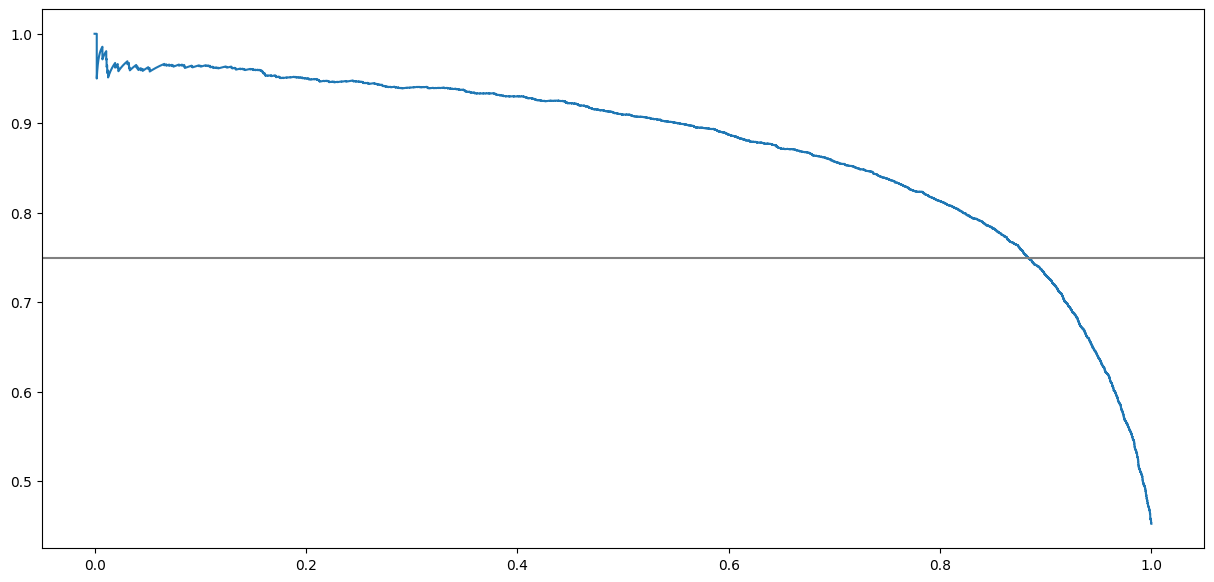

In [36]:
precision, recall, thrs = precision_recall_curve(valid[TARGET_NAME].values, valid['pred'])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

In [37]:
from scipy.integrate import simpson
from numpy import trapz

idx = precision >= 0.75

area = trapz(precision[idx][::-1], recall[idx][::-1], dx=1)
print("area =", area)

roc_auc = auc(recall[idx], precision[idx])
print("roc auc =", roc_auc)

area = 0.7990323448406973
roc auc = 0.7990323448406972


In [38]:
print(f'OOF score: {metric(train.target, train.pred, train.weights)}')
print(f'Valid score: {metric(valid.target, valid.pred, valid.weights)}')

OOF score: 0.7122563614173434
Valid score: 0.6977064668836336


In [39]:
def metric_cats(y_true, y_pred, sample_weight, dict_weigts):
    
    pr_aucs = []
    
    for name,w in dict_weigts.items():
        idx = sample_weight == w
        y_pred_cat = y_pred[idx]
        y_true_cat = y_true[idx]

        y, x, thr = precision_recall_curve(y_true_cat, y_pred_cat)
        gt_prec_level_idx = y >= 0.75
        threshold = np.append(thr,1)[y>=0.75][0]
        
        au = roc_auc_score(y_true_cat, y_pred_cat)

        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append({'cat3': name, 'PRAUC':pr_auc_prec_level,'weight': w , 'AUC': au,'threshold': threshold})
        except ValueError as err:
            pr_aucs.append({'cat3': name, 'PRAUC':0,'weight': w, 'AUC': au, 'threshold': threshold})

    
    return pd.DataFrame(pr_aucs).sort_values('PRAUC', ascending=False)

In [40]:
stats = metric_cats(valid.target, valid.pred, valid.weights, weights)
stats.head(10)

cat3     PRAUC    weight       AUC  \
31                    Видеорегистратор  0.988532  0.004756  0.912698   
27                              Гаджет  0.985243  0.003097  0.937500   
41              Микрофоны и аксессуары  0.984251  0.003926  0.925000   
13                Наушники и гарнитуры  0.972089  0.029418  0.843710   
36               Рюкзаки, чехлы, сумки  0.970803  0.004534  0.866213   
17                           Кронштейн  0.967058  0.009456  0.844444   
19                  Оптические приборы  0.956302  0.007355  0.860350   
4   Аксессуары для фото и видеотехники  0.947808  0.010285  0.965677   
40                         Видеокамеры  0.946678  0.002820  0.850000   
15                  Акустика и колонки  0.937552  0.012553  0.833095   

    threshold  
31   0.191465  
27   0.128080  
41   0.081080  
13   0.113974  
36   0.215142  
17   0.224452  
19   0.060193  
4    0.203478  
40   0.260643  
15   0.205576

In [41]:
stats

cat3     PRAUC    weight       AUC  \
31                            Видеорегистратор  0.988532  0.004756  0.912698   
27                                      Гаджет  0.985243  0.003097  0.937500   
41                      Микрофоны и аксессуары  0.984251  0.003926  0.925000   
13                        Наушники и гарнитуры  0.972089  0.029418  0.843710   
36                       Рюкзаки, чехлы, сумки  0.970803  0.004534  0.866213   
17                                   Кронштейн  0.967058  0.009456  0.844444   
19                          Оптические приборы  0.956302  0.007355  0.860350   
4           Аксессуары для фото и видеотехники  0.947808  0.010285  0.965677   
40                                 Видеокамеры  0.946678  0.002820  0.850000   
15                          Акустика и колонки  0.937552  0.012553  0.833095   
18                                        rest  0.937093  0.029695  0.875975   
28                             Коврик для мыши  0.933044  0.010451  0.908163   
34                                         ИБП  0.925928  0.003760  0.862687   
9                                   Смарт-часы  0.915940  0.085435  0.767587   
25                              Принтеры и МФУ  0.904065  0.004147  0.789167   
24                        Сетевое оборудование  0.902049  0.005806  0.831267   
3                     Устройство ручного ввода  0.874943  0.022838  0.854341   
32                               Блоки питания  0.864801  0.006249  0.687675   
21     Жесткие диски, SSD и сетевые накопители  0.863249  0.031243  0.906434   
0                     Батарейки и аккумуляторы  0.847665  0.032957  0.881495   
14                             Видеонаблюдение  0.840806  0.017087  0.853468   
5                         Расходник для печати  0.832130  0.086485  0.913496   
35                       Карты памяти и флешки  0.804651  0.007631  0.947524   
38                         Расходные материалы  0.804495  0.004037  0.862145   
43                                   Умный дом  0.804495  0.004037  0.862145   
23  Сетевые фильтры, разветвители и удлинители  0.803524  0.012000  0.936434   
2                         Кабели и переходники  0.765628  0.059611  0.897245   
30          Системы охлаждения для компьютеров  0.758440  0.005419  0.811628   
6                      Запчасти для смартфонов  0.752702  0.055685  0.831023   
10                     Корпуса для компьютеров  0.728561  0.002931  0.802992   
29                                   Процессор  0.728561  0.002931  0.802992   
1      Смартфоны, планшеты, мобильные телефоны  0.706782  0.051150  0.900823   
22                                  Телевизоры  0.684208  0.009013  0.845007   
26                          Оперативная память  0.655598  0.012221  0.938594   
42                           Материнская плата  0.590004  0.004921  0.883113   
12           Зарядные устройства и док-станции  0.514643  0.102245  0.766430   
39             Запчасти для аудио/видеотехники  0.500000  0.003373  0.838235   
20                         Мониторы и запчасти  0.472264  0.007520  0.749444   
7                       Запчасти для ноутбуков  0.469642  0.128456  0.804960   
37                                       Чехол  0.447313  0.014433  0.876052   
8          Видеокарты и графические ускорители  0.421483  0.005751  0.725370   
11                                   Компьютер  0.312197  0.057675  0.843734   
33                    Защитные пленки и стекла  0.224285  0.002875  0.744658   
16                          Электронные модули  0.145455  0.021732  0.731321   

    threshold  
31   0.191465  
27   0.128080  
41   0.081080  
13   0.113974  
36   0.215142  
17   0.224452  
19   0.060193  
4    0.203478  
40   0.260643  
15   0.205576  
18   0.131523  
28   0.208164  
34   0.121594  
9    0.021089  
25   0.319610  
24   0.273902  
3    0.265310  
32   0.399950  
21   0.268436  
0    0.380651  
14   0.493216  
5    0.313601  
35   0.537544  
38   0.391862  
43   0.391862  
23   0.451870  
2    0.24

In [216]:
valid_index = []
for i,row in stats.iterrows():
    tmp = valid[(valid.cat3_grouped==row.cat3)&(valid.pred>=row.threshold)&(valid.target==0)].index.tolist()
    valid_index.extend(tmp)
    tmp = valid[(valid.cat3_grouped==row.cat3)&(valid.pred<row.threshold)&(valid.target==1)].index.tolist()
    valid_index.extend(tmp)

In [217]:
len(valid_index)

3817

In [58]:
train[(train.cat3_grouped=='Запчасти для ноутбуков')&(train.pred>=0.440924)&(train.target==1)][['diff_text_characteristics_1', 'diff_text_characteristics_2','target']]

diff_text_characteristics_1  \
435                                                 RageX   
446     Совместимость: Asus K53SJ K54 X54H X54C X54L X...   
2839    Кол-во циклов заряд-разряд: 600 Емкость мА•ч: ...   
4237                               Рекомендовано для: OEM   
6321    Напряжение В: 11 Вт•ч: 58 Тип аккумулятора: Li...   
...                                                   ...   
278914  Напряжение В: 15 Список совместимых устройств:...   
279344  OEM Рекомендовано для: HP Совместимость: ProBo...   
279345                                                OEM   
279409                             11 Series Chikibuk 500   
279496  Ebatt Вес товара г: 250 Страна-изготовитель: К...   

                              diff_text_characteristics_2  target  
435                      Страна-изготовитель: Китай iQZiP     1.0  
446                      Размеры мм: 200х100х40 Ebatt 250     1.0  
2839                                                          1.0  
4237                           Страна-изготовитель: Китай     1.0  
6321                         Ebatt Размеры мм: 200х100х40     1.0  
...                                                   ...     ...  
278914                   TopON 250 Размеры мм: 200х100х40     1.0  
279344                                              iQZiP     1.0  
279345  Напряжение В: 11.55 Емкость Вт•ч: 52.5 Кол-во ...     1.0  
279409  Тип аккумулятора: Li-ion 11.1 Рекомендовано дл...     1.0  
279496  Тип аккумулятора: Li-ion Напряжение В: 7.4 Gre...     1.0  

[1009 rows x 3 columns]

In [139]:
stats

cat3     PRAUC    weight       AUC  \
31                            Видеорегистратор  0.989400  0.004756  0.920635   
27                                      Гаджет  0.985243  0.003097  0.937500   
41                      Микрофоны и аксессуары  0.980966  0.003926  0.910714   
36                       Рюкзаки, чехлы, сумки  0.978167  0.004534  0.886621   
13                        Наушники и гарнитуры  0.969970  0.029418  0.843315   
4           Аксессуары для фото и видеотехники  0.961679  0.010285  0.973562   
19                          Оптические приборы  0.953223  0.007355  0.850219   
17                                   Кронштейн  0.950217  0.009456  0.820370   
28                             Коврик для мыши  0.942565  0.010451  0.918367   
40                                 Видеокамеры  0.938580  0.002820  0.850000   
15                          Акустика и колонки  0.935339  0.012553  0.820366   
18                                        rest  0.932525  0.029695  0.873243   
9                                   Смарт-часы  0.921897  0.085435  0.780037   
34                                         ИБП  0.912828  0.003760  0.839552   
25                              Принтеры и МФУ  0.912207  0.004147  0.806250   
24                        Сетевое оборудование  0.912001  0.005806  0.839015   
3                     Устройство ручного ввода  0.880004  0.022838  0.859410   
21     Жесткие диски, SSD и сетевые накопители  0.878607  0.031243  0.911073   
32                               Блоки питания  0.859624  0.006249  0.679272   
14                             Видеонаблюдение  0.858252  0.017087  0.863784   
0                     Батарейки и аккумуляторы  0.853915  0.032957  0.888226   
5                         Расходник для печати  0.838731  0.086485  0.918125   
23  Сетевые фильтры, разветвители и удлинители  0.822988  0.012000  0.944629   
35                       Карты памяти и флешки  0.807411  0.007631  0.950657   
30          Системы охлаждения для компьютеров  0.781514  0.005419  0.803295   
2                         Кабели и переходники  0.762660  0.059611  0.898618   
6                      Запчасти для смартфонов  0.748628  0.055685  0.834510   
38                         Расходные материалы  0.731118  0.004037  0.850177   
43                                   Умный дом  0.731118  0.004037  0.850177   
1      Смартфоны, планшеты, мобильные телефоны  0.727571  0.051150  0.905994   
22                                  Телевизоры  0.714950  0.009013  0.846803   
29                                   Процессор  0.708720  0.002931  0.802485   
10                     Корпуса для компьютеров  0.708720  0.002931  0.802485   
42                           Материнская плата  0.576220  0.004921  0.885454   
26                          Оперативная память  0.564567  0.012221  0.934536   
20                         Мониторы и запчасти  0.556394  0.007520  0.741290   
12           Зарядные устройства и док-станции  0.516904  0.102245  0.769262   
39             Запчасти для аудио/видеотехники  0.500000  0.003373  0.823529   
37                                       Чехол  0.486644  0.014433  0.877891   
8          Видеокарты и графические ускорители  0.475577  0.005751  0.727053   
7                       Запчасти для ноутбуков  0.474748  0.128456  0.805869   
11                                   Компьютер  0.285785  0.057675  0.846088   
33                    Защитные пленки и стекла  0.220524  0.002875  0.739698   
16                          Электронные модули  0.195800  0.021732  0.741518   

    threshold  
31   0.156297  
27   0.134758  
41   0.075506  
36   0.172093  
13   0.094445  
4    0.191810  
19   0.053671  
17   0.180182  
28   0.207432  
40   0.317262  
15   0.192604  
18   0.110143  
9    0.015351  
34   0.091676  
25   0.269079  
24   0.260106  
3    0.221869  
21   0.232246  
32   0.388327  
14   0.453400  
0    0.339914  
5    0.278307  
23   0.491193  
35   0.551788  
30   0.444761  
2    0.237200  
6    0.43

In [71]:
train[['target','variantid1','variantid2','cat3_grouped', 'pred']].sort_values(['cat3_grouped', 'pred'],ascending=False)

target  variantid1  variantid2        cat3_grouped      pred
54852      1.0   567195175   752052247  Электронные модули  0.977799
146715     1.0   565363925   813076322  Электронные модули  0.973508
59432      1.0   558755892   599256734  Электронные модули  0.962214
225484     1.0   661346926   711580196  Электронные модули  0.956383
219306     1.0   487392067   750361500  Электронные модули  0.952412
...        ...         ...         ...                 ...       ...
269871     0.0   810774555   810777154                rest  0.034892
215972     0.0   500677555   500677945                rest  0.034303
8312       0.0    91423051    91432019                rest  0.033781
176065     0.0   711599869   711599875                rest  0.032039
164351     0.0   445277907   550373242                rest  0.024881

[286006 rows x 5 columns]

In [55]:
cat_data = train_features[['categories', 'characteristic_attributes_mapping', 'name', 'variantid']].reset_index(drop=True)
cat_data.categories = cat_data.categories.map(json.loads)
cat_data.characteristic_attributes_mapping = cat_data.characteristic_attributes_mapping.map(json.loads, na_action='ignore')
cat_data['cat3_grouped'] = cat_data.categories.apply(lambda x: x['3'])
cat_data['cat3_grouped'] = cat_data['cat3_grouped'].apply(test_cat3_dict.get)
cat_data = cat_data[cat_data.cat3_grouped=='Компьютер'].dropna().drop(columns=['categories']).reset_index(drop=True)
cat_data

characteristic_attributes_mapping  \
0      {'Размер упаковки (Длина х Ширина х Высота), с...   
1      {'Число портов USB 3.2 Gen 2': ['2'], 'Цвет то...   
2      {'Тип подсветки': ['LED'], 'Цвет товара': ['бе...   
3      {'Цвет товара': ['черный'], 'Серии': ['Acer As...   
4      {'Цвет товара': ['черный'], 'Покрытие экрана':...   
...                                                  ...   
57567  {'Общий объем HDD, ГБ': ['8000'], 'Видеокарта'...   
57568  {'Общий объем HDD, ГБ': ['10000'], 'Видеокарта...   
57569  {'Общий объем HDD, ГБ': ['500'], 'Видеокарта':...   
57570  {'Общий объем HDD, ГБ': ['10000'], 'Видеокарта...   
57571  {'Общий объем HDD, ГБ': ['8000'], 'Видеокарта'...   

                                                    name  variantid  \
0      17.3" Ноутбук MSI MSI GL72M 7REX (GL72M 7REX-1...   78067602   
1      14" Ноутбук Acer ConceptD 3 CN314-72G-77XW, In...   86541369   
2      21.5" Моноблок HP 200 G4 (Intel Core i3-10110U...   89620592   
3      15.6" Ноутбук Acer Aspire A315-42G-R15K, AMD A...   89648593   
4      15.6" Ноутбук Acer Aspire 3 A315-42-R1QX, AMD ...   89658774   
...                                                  ...        ...   
57567  Системный блок ЮКОМС 900-9400-178 (AMD A6-9400...  815517315   
57568  Системный блок ЮКОМС 900-9400-37 (AMD A6-9400 ...  815541182   
57569  Системный блок ЮКОМС 9400-282 (AMD A6-9400 (3....  819780961   
57570  Системный блок ЮКОМС 9400-268 (AMD A6-9400 (3....  822095690   
57571  Системный блок ЮКОМС 9400-9 (AMD A6-9400 (3.4 ...  822101044   

      cat3_grouped  
0        Компьютер  
1        Компьютер  
2        Компьютер  
3        Компьютер  
4        Компьютер  
...            ...  
57567    Компьютер  
57568    Компьютер  
57569    Компьютер  
57570    Компьютер  
57571    Компьютер  

[57572 rows x 4 columns]

In [56]:
tmp = pd.DataFrame(cat_data['characteristic_attributes_mapping'].apply(lambda x: {i:k[0] for i,k in x.items()}).to_list())
for i in tmp.columns:
    tmp[i] = tmp[i].astype('category')
    tmp[i] = tmp[i].cat.codes
cat_data = pd.concat([cat_data, tmp], axis=1) \
    .drop(columns=['characteristic_attributes_mapping', 'cat3_grouped'])

In [57]:
cat_data

name  variantid  \
0      17.3" Ноутбук MSI MSI GL72M 7REX (GL72M 7REX-1...   78067602   
1      14" Ноутбук Acer ConceptD 3 CN314-72G-77XW, In...   86541369   
2      21.5" Моноблок HP 200 G4 (Intel Core i3-10110U...   89620592   
3      15.6" Ноутбук Acer Aspire A315-42G-R15K, AMD A...   89648593   
4      15.6" Ноутбук Acer Aspire 3 A315-42-R1QX, AMD ...   89658774   
...                                                  ...        ...   
57567  Системный блок ЮКОМС 900-9400-178 (AMD A6-9400...  815517315   
57568  Системный блок ЮКОМС 900-9400-37 (AMD A6-9400 ...  815541182   
57569  Системный блок ЮКОМС 9400-282 (AMD A6-9400 (3....  819780961   
57570  Системный блок ЮКОМС 9400-268 (AMD A6-9400 (3....  822095690   
57571  Системный блок ЮКОМС 9400-9 (AMD A6-9400 (3.4 ...  822101044   

       Размер упаковки (Длина х Ширина х Высота), см  \
0                                                153   
1                                                 -1   
2                                                 -1   
3                                                 -1   
4                                                 -1   
...                                              ...   
57567                                             -1   
57568                                             -1   
57569                                             -1   
57570                                             -1   
57571                                             -1   

       Число портов USB 3.2 Gen 2  Цвет товара  \
0                               2           47   
1                               2            1   
2                              -1            1   
3                              -1           47   
4                              -1           47   
...                           ...          ...   
57567                          -1           46   
57568                          -1           46   
57569                          -1           46   
57570                          -1           47   
57571                          -1           47   

       Скорость вращения шпинделя HDD  Покрытие экрана  Общий объем HDD, ГБ  \
0                                   5                3                    5   
1                                  -1                3                   -1   
2                                   7                3                    5   
3                                  -1                3                   -1   
4                                  -1                3                   -1   
...                               ...              ...                  ...   
57567                              -1               -1                   26   
57568                              -1               -1                    3   
57569                              -1               -1                   21   
57570                              -1               -1                    3   
57571                              -1               -1                   26   

       Форм-фактор SSD  Емкость аккумулятора, мАч  ...  \
0                    4                        100  ...   
1                    4                         -1  ...   
2                   -1                         -1  ...   
3                   -1                         -1  ...   
4                   -1                        170  ...   
...                ...                        ...  ...   
57567                1                         -1  ...   
57568                1                         -1  ...   
57569                1                         -1  ...   
57570                1                         -1  ...   
57571               -1                         -1  ...   

       Максимальное количество блоков питания  Высота, юниты  \
0                                          -1             -1   
1                                          -1             -1   
2                                          -1             -1   
3                      

In [59]:
check = valid[['variantid1','variantid2', 'target', 'pred']].merge(cat_data.add_suffix('1'), on='variantid1').merge(cat_data.add_suffix('2'), on='variantid2')
check[(check.target==0)&(check.pred>0.406398)]

variantid1  variantid2  target      pred  \
63    815518231   820017181     0.0  0.414308   
121   656764067   735853037     0.0  0.637503   
205   237152361   737868968     0.0  0.841434   
251   583604203   638207621     0.0  0.722779   
318   463681227   783556765     0.0  0.413057   
360   262004642   262005921     0.0  0.502730   
391   815542231   822094514     0.0  0.420013   
397   199431905   238213372     0.0  0.423650   
404   320143898   642882368     0.0  0.772410   
574   795805357   801669160     0.0  0.855784   
583   736714486   754193912     0.0  0.420173   
640   158163358   181618061     0.0  0.899599   

                                                 name1  \
63   Системный блок ЮКОМС 800-9400-97 (AMD A6-9400 ...   
121  16.2" Ноутбук Apple MacBook Pro 16, Apple M1 M...   
205  14" Ноутбук Lenovo IdeaPad 3 14ITL05, Intel Ce...   
251  15.6" Ноутбук HP 255 G8, AMD Athlon Silver 305...   
318  13.3" Ноутбук Lenovo ThinkPad L13 Gen 2, Intel...   
360                                Ноутбук ASUS X550Ze   
391  Системный блок ЮКОМС 750-9400-wf-97 (AMD A6-94...   
397   Ноутбук HP 255 G7, RAM 8 ГБ, SSD 256 ГБ, Без ...   
404  14" Ноутбук HP 240 G8 (43W59EA), Intel Core i5...   
574  15.6" Ноутбук ASUS VivoBook X1502ZA-BQ820, Int...   
583  15.6" Игровой ноутбук ASUS TUF Gaming A15 FA50...   
640  15.6" Ноутбук Acer, AMD Ryzen 5 3550H (2.1 ГГц...   

     Размер упаковки (Длина х Ширина х Высота), см1  \
63                                               -1   
121                                              -1   
205                                              -1   
251                                              -1   
318                                              -1   
360                                              -1   
391                                              -1   
397                                              -1   
404                                              -1   
574                                              -1   
583                                              -1   
640                                              -1   

     Число портов USB 3.2 Gen 21  Цвет товара1  \
63                            -1            46   
121                           -1            33   
205                           -1            33   
251                           -1            32   
318                           -1            47   
360                           -1            47   
391                           -1            46   
397                           -1            47   
404                           -1            47   
574                           -1            32   
583                           -1            33   
640                           -1            47   

     Скорость вращения шпинделя HDD1  Покрытие экрана1  ...  \
63                                -1                -1  ...   
121                               -1                 1  ...   
205                               -1                 3  ...   
251                               -1                -1  ...   
318                               -1                 3  ...   
360                               -1                -1  ...   
391                               -1                -1  ...   
397                               -1                -1  ...   
404                               -1                 3  ...   
574                               -1                -1  ...   
583                               -1                 3  ...   
640                               -1                 3  ...   

     Максимальное количество блоков питания2  Высота, юниты2  \
63                                        -1              -1   
121                                       -1              -1   
205                                       -1              -1   
251                                       -1              -1   
318                                       -1              -1   
360                                      

/root/miniconda3/envs/lama/lib/python3.8/site-packages/pandas/plotting/_matplotlib/tools.py:223: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(**fig_kw)


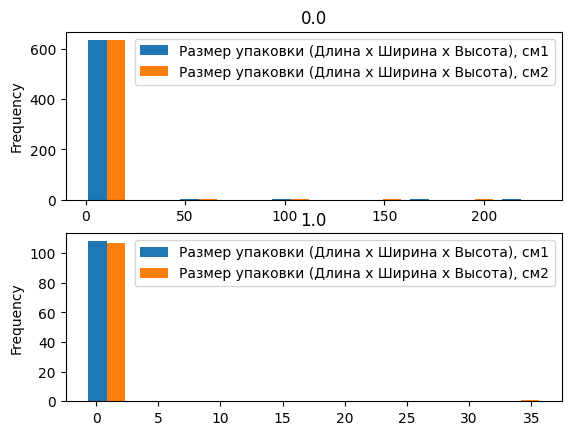

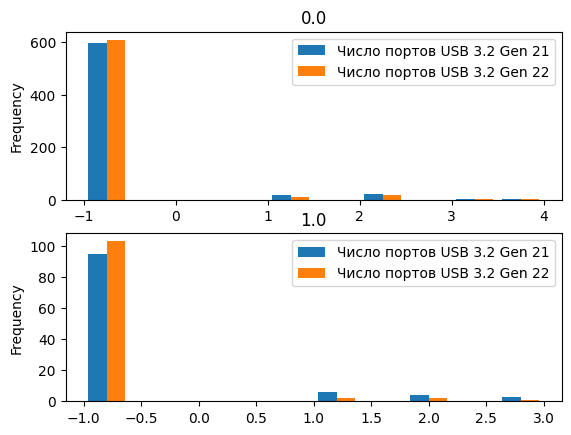

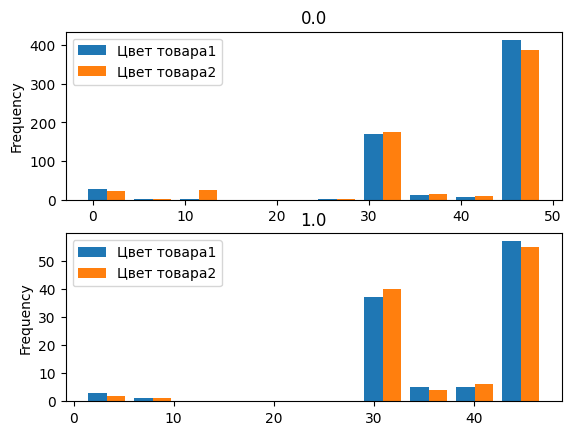

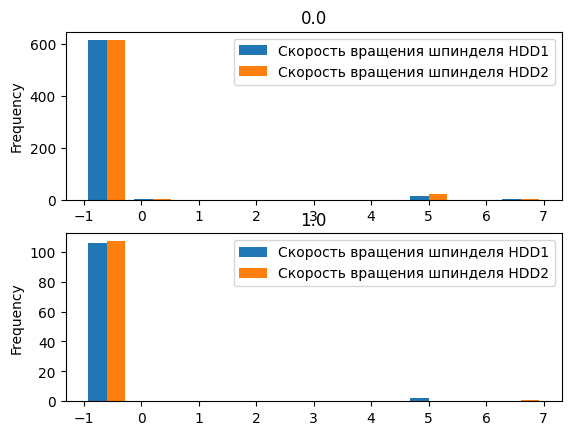

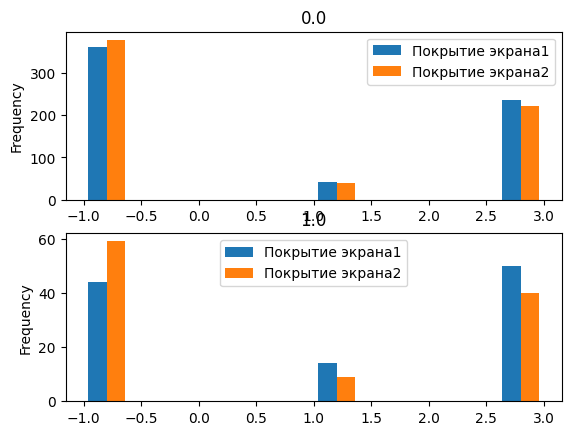

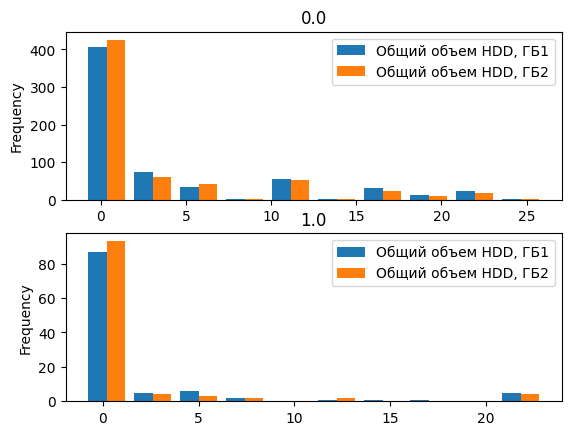

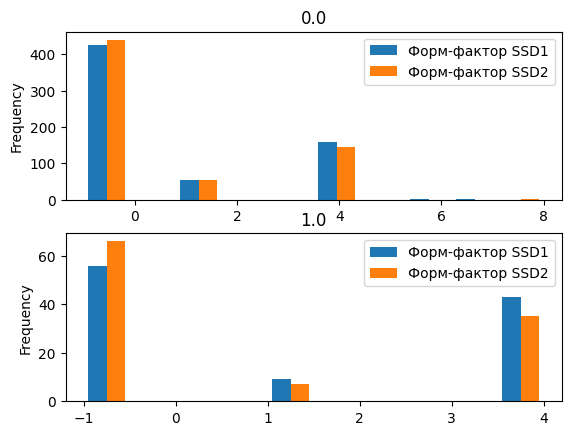

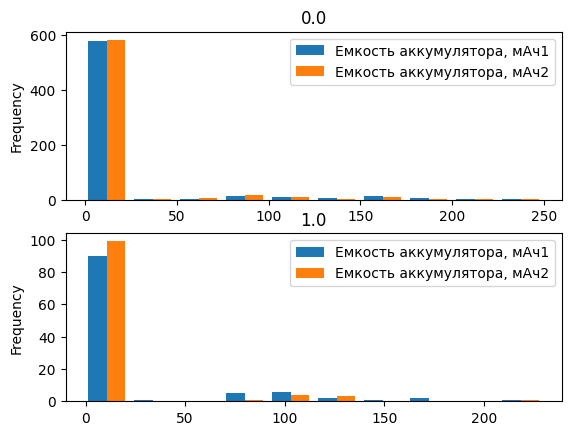

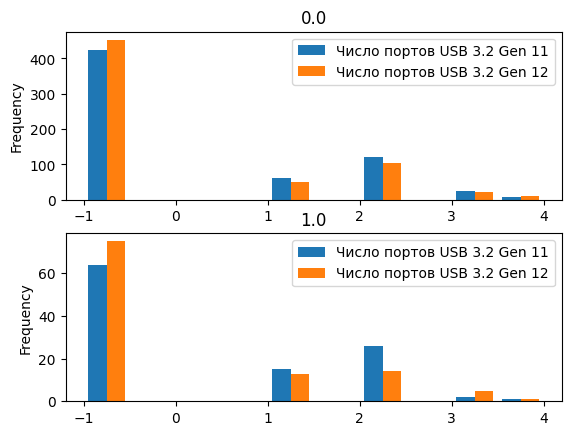

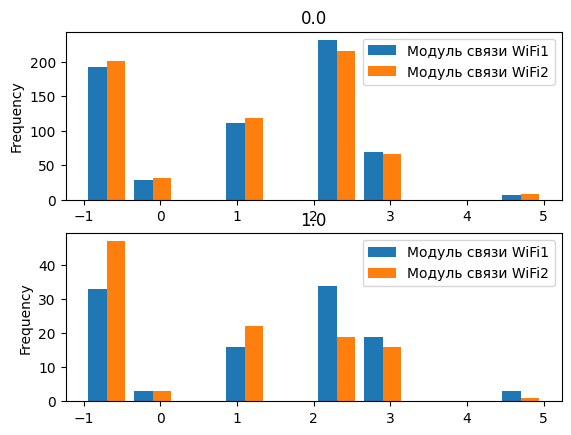

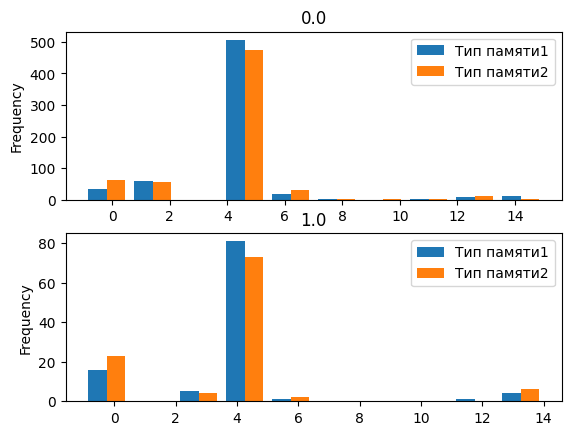

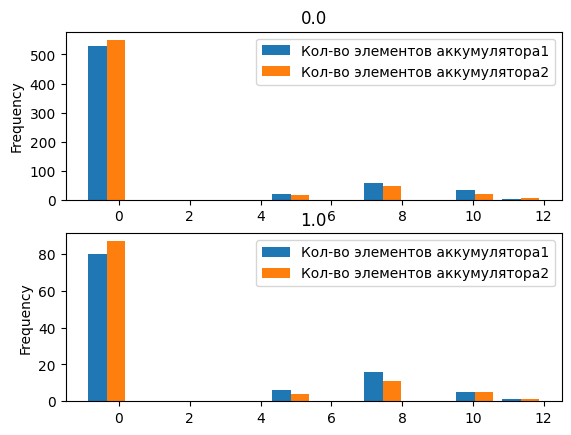

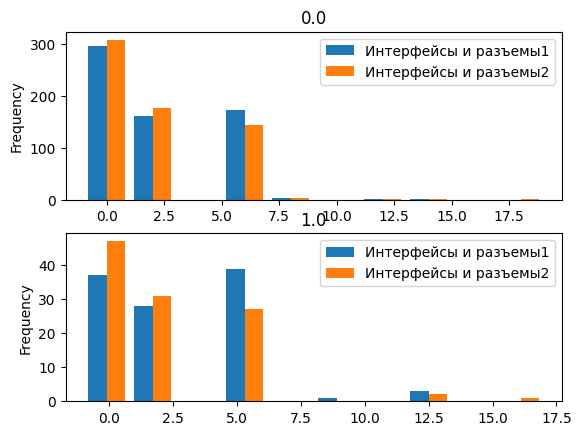

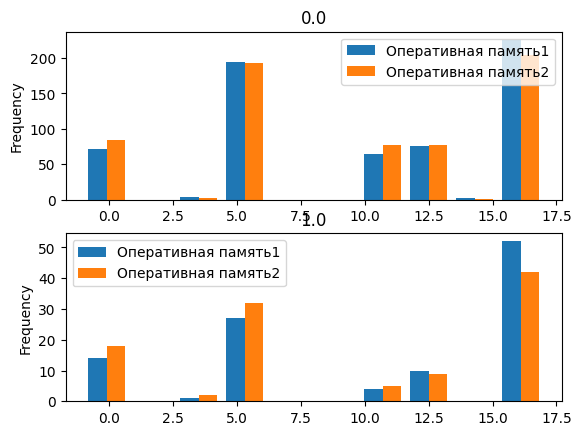

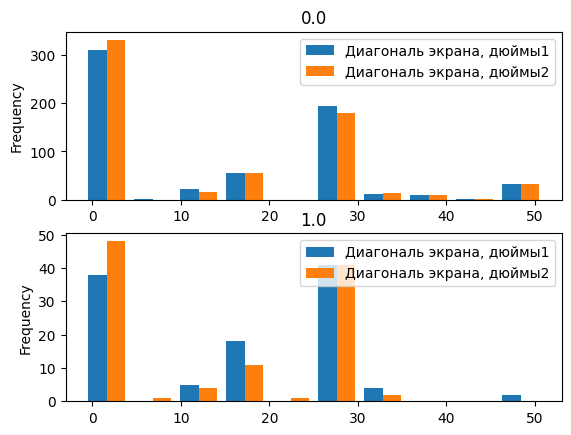

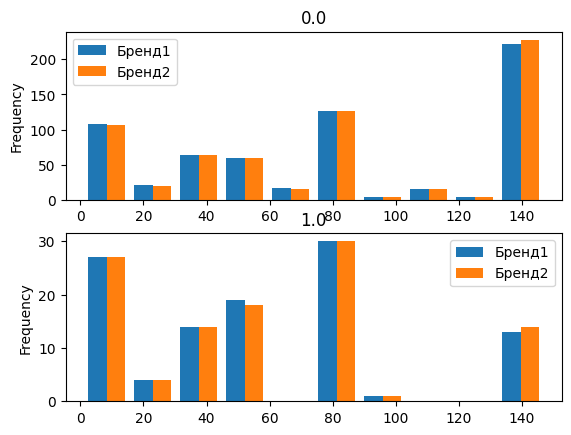

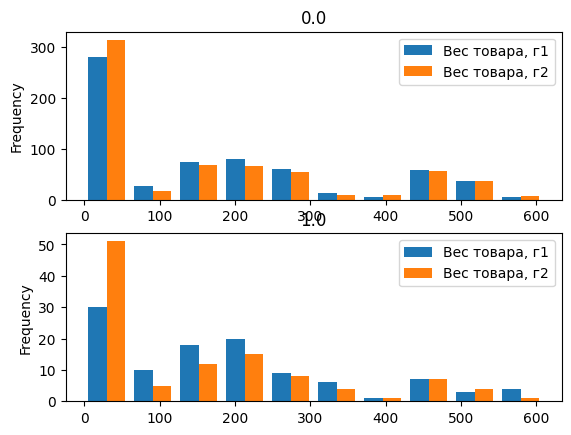

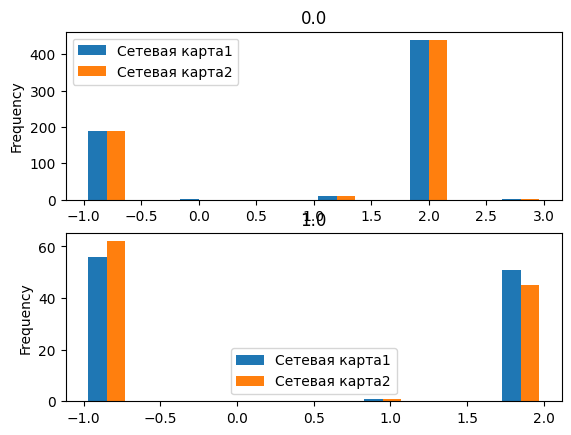

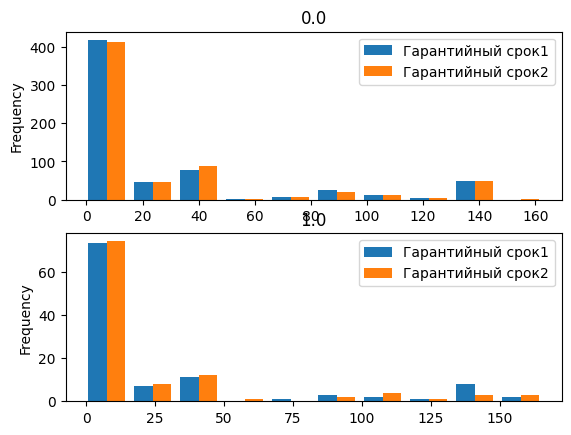

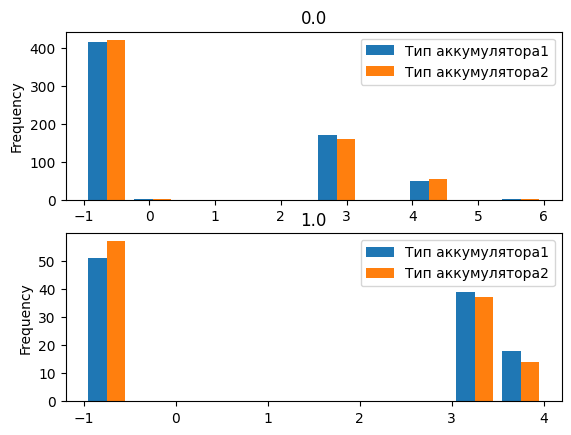

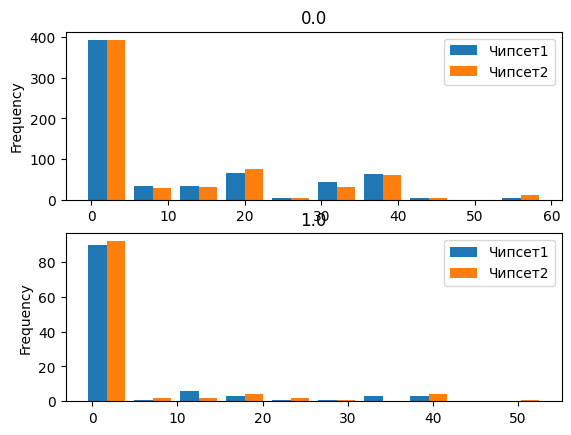

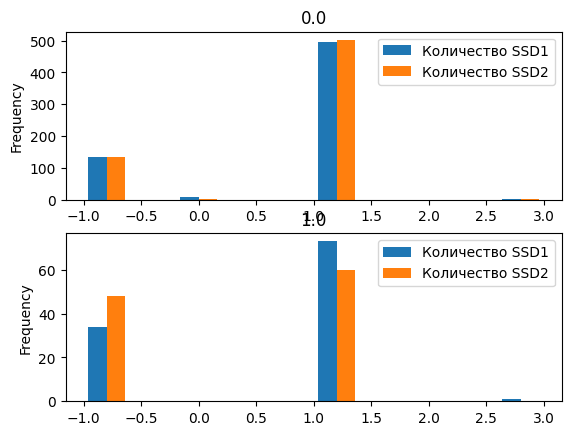

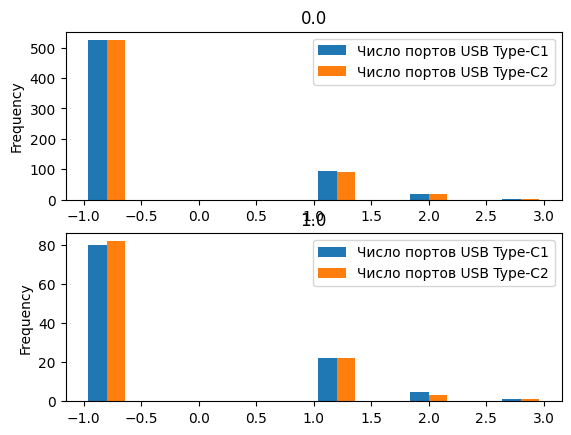

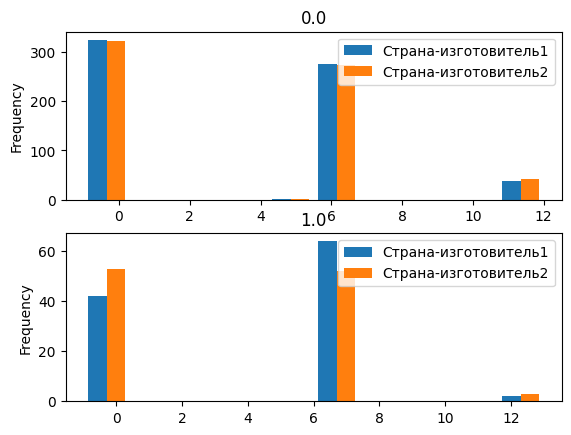

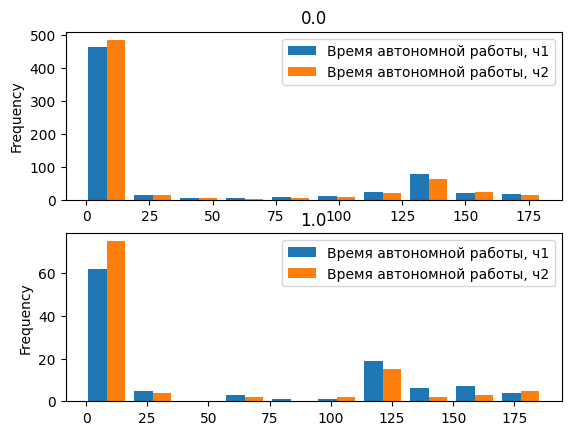

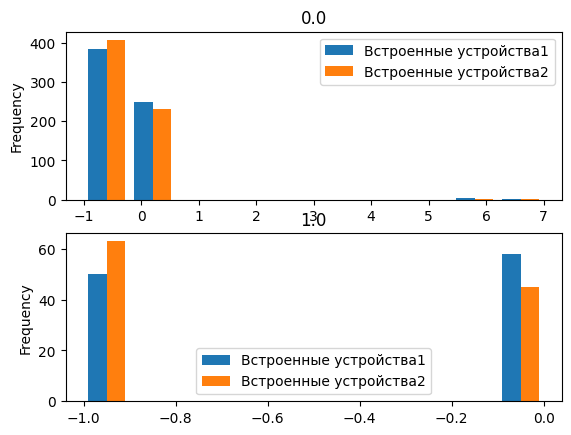

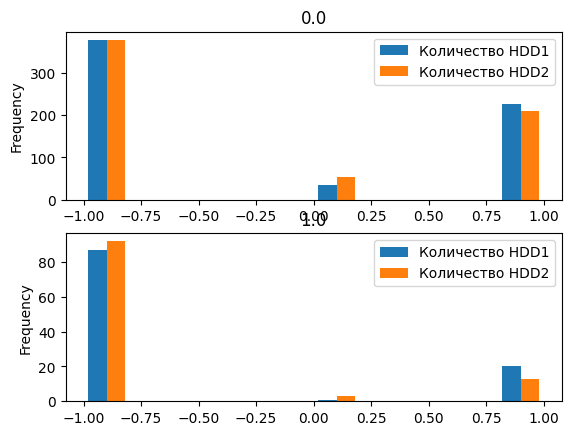

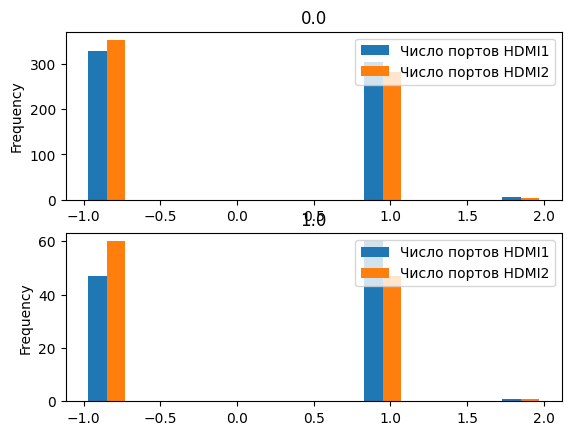

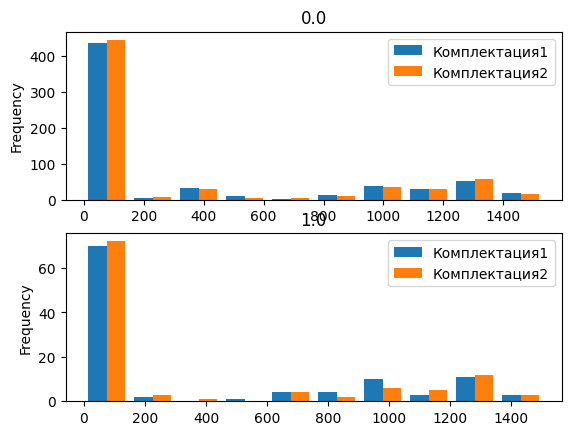

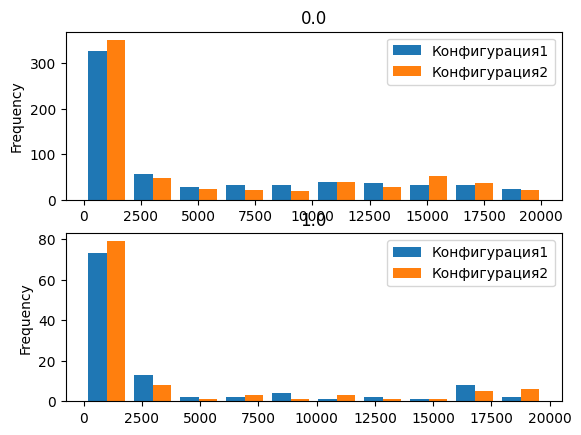

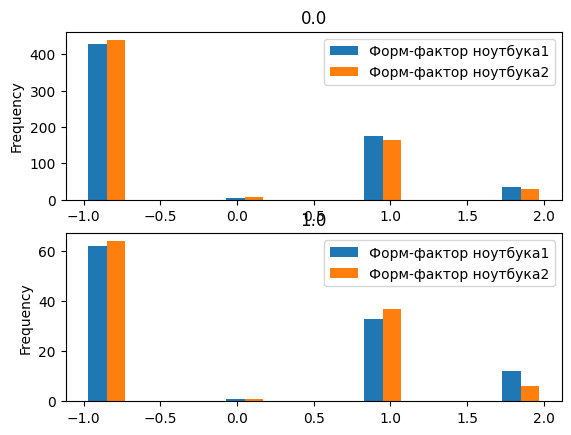

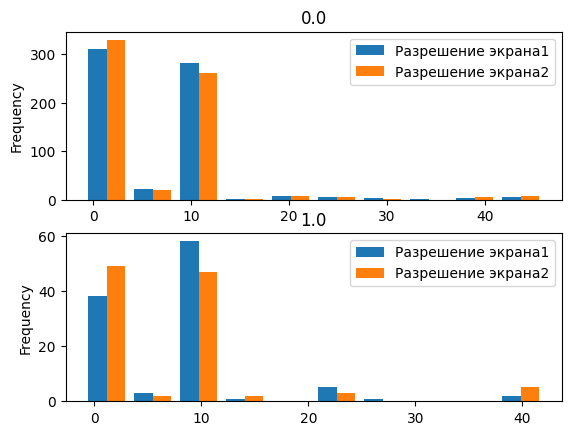

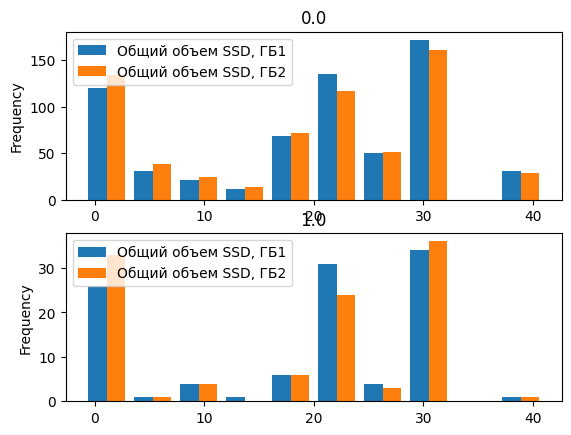

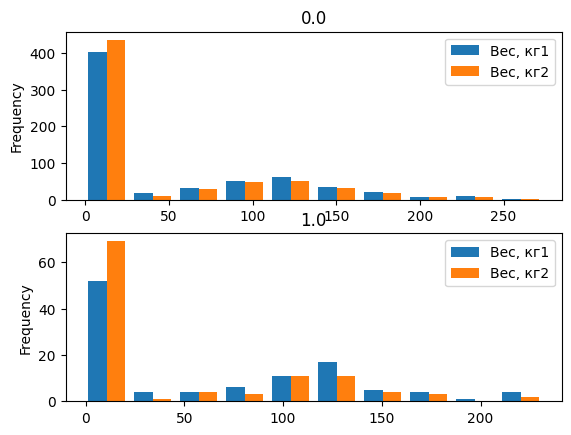

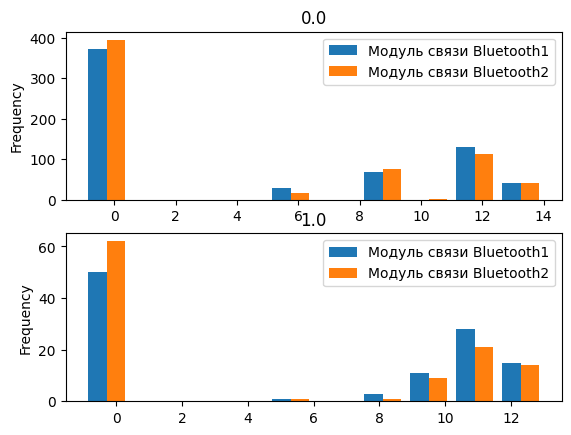

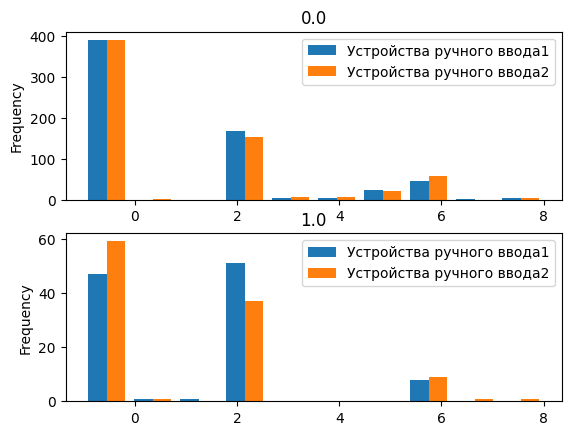

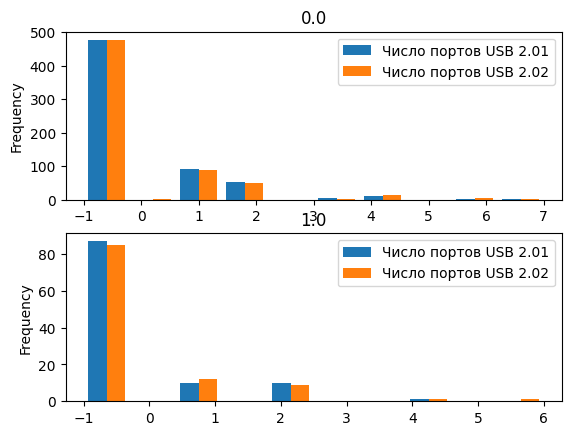

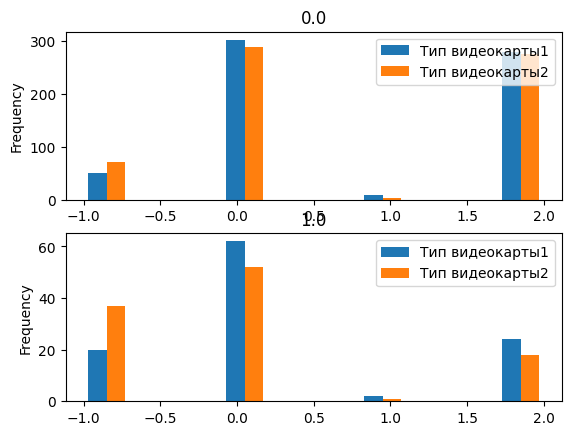

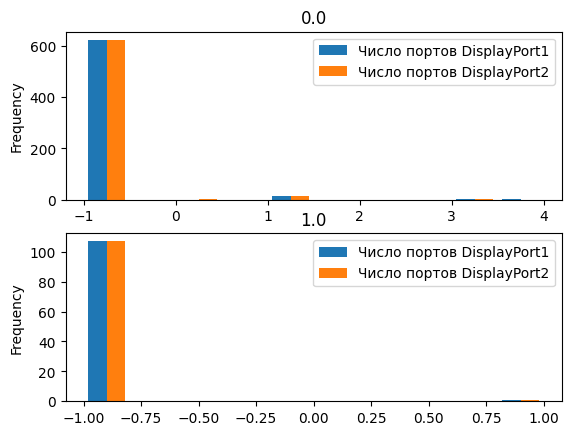

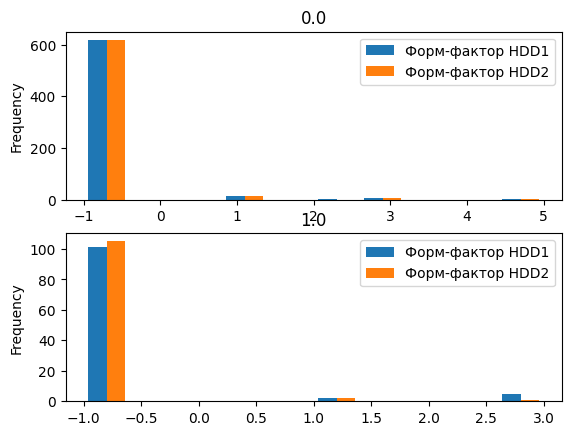

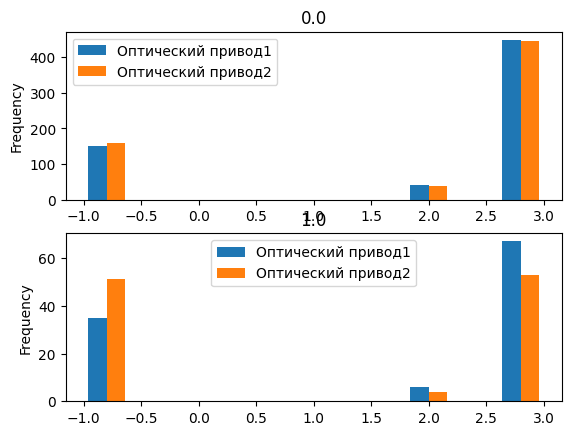

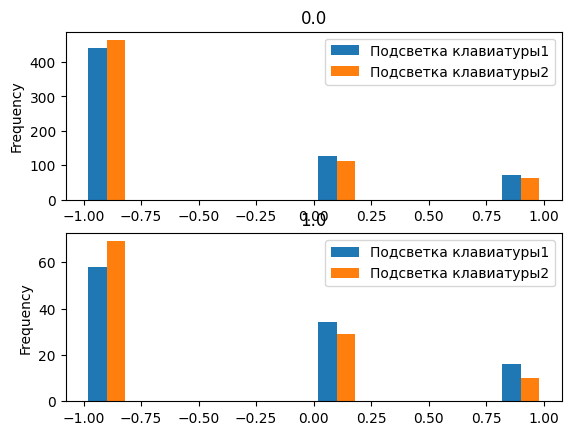

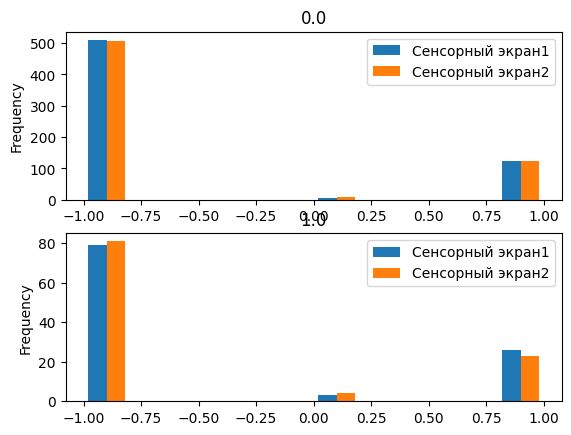

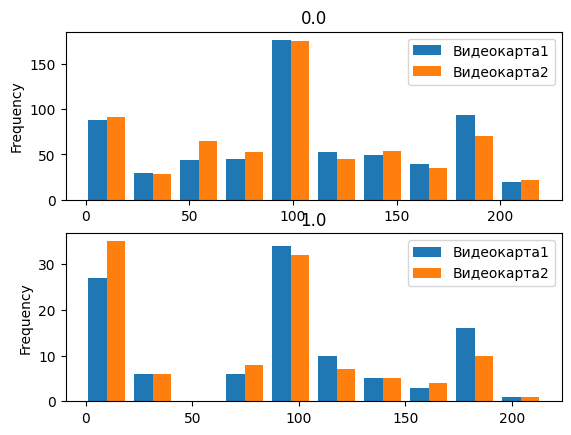

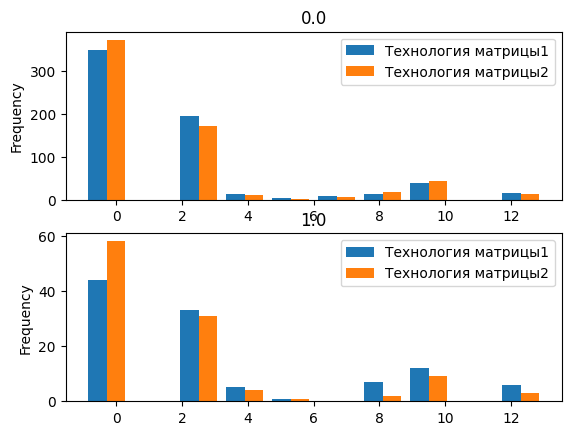

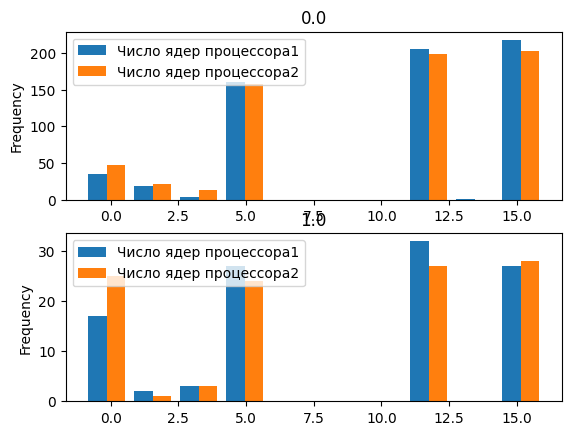

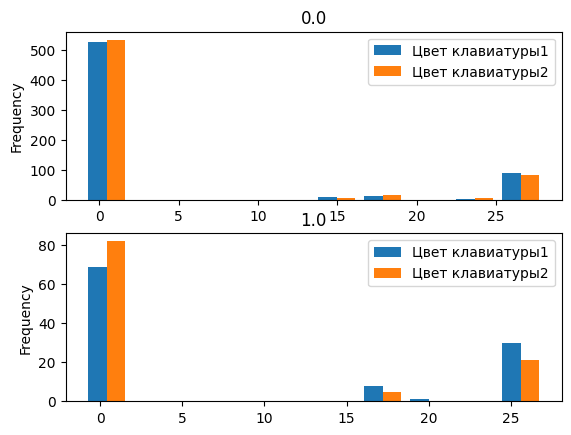

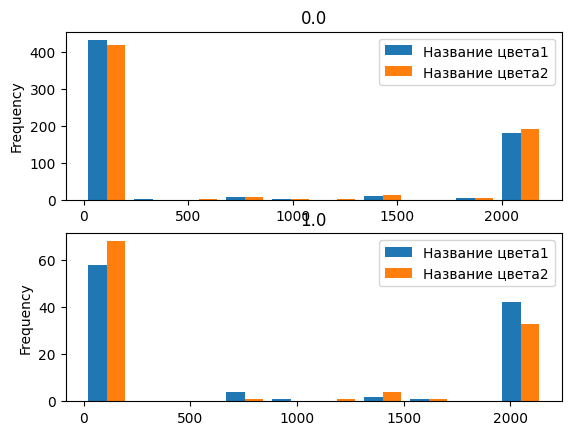

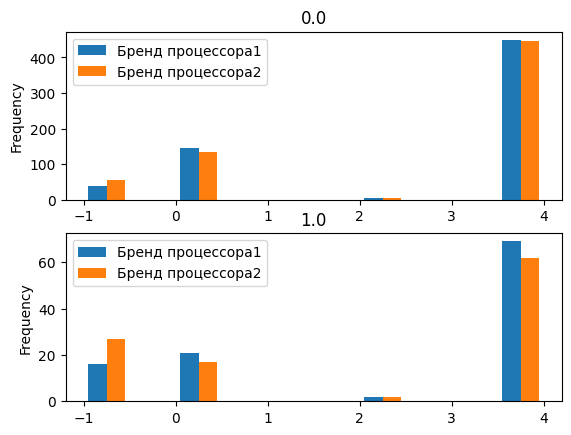

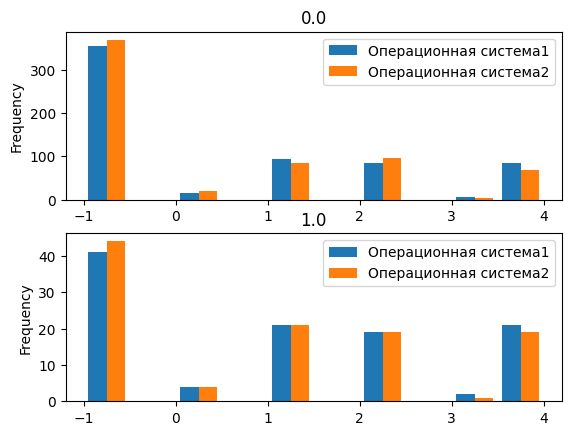

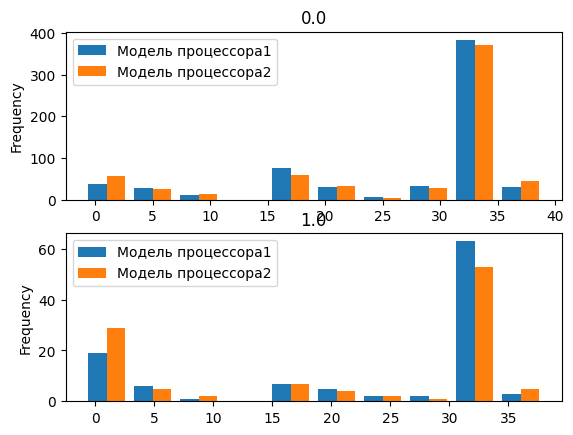

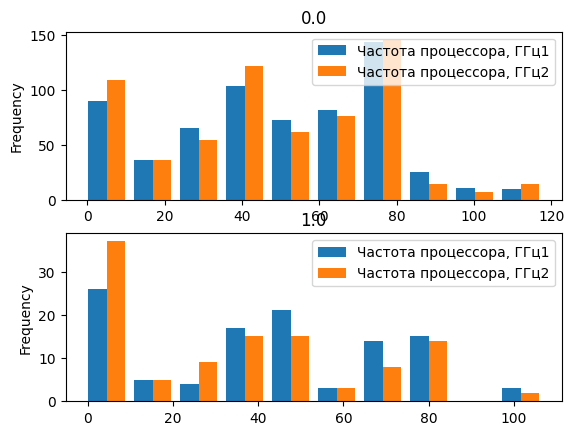

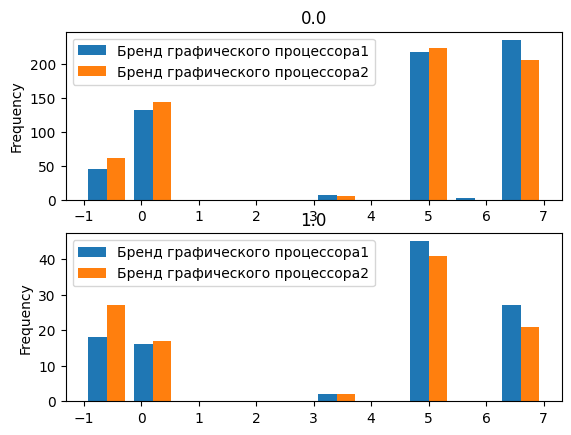

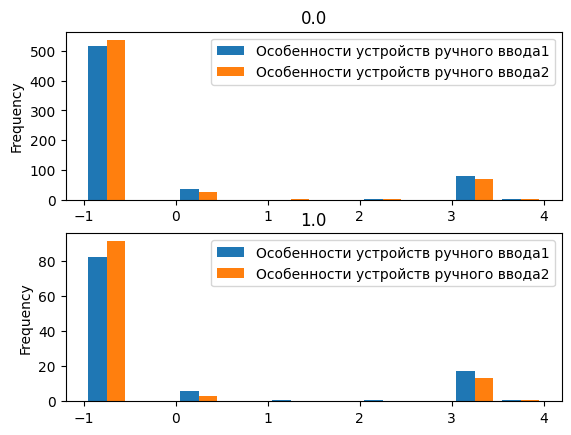

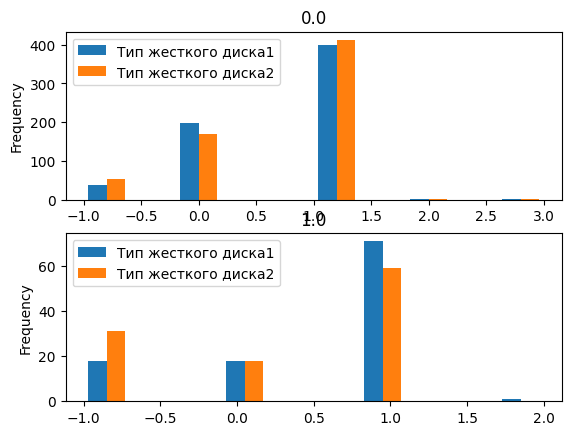

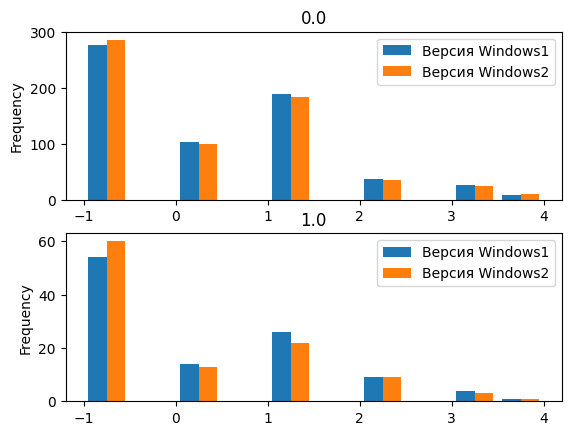

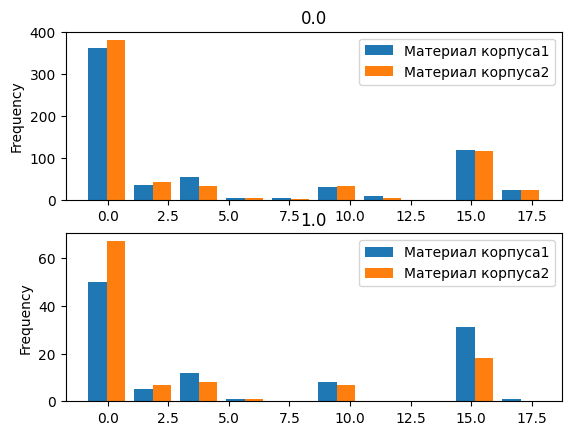

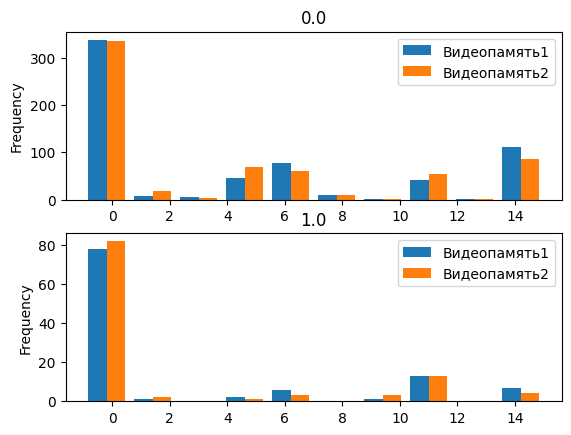

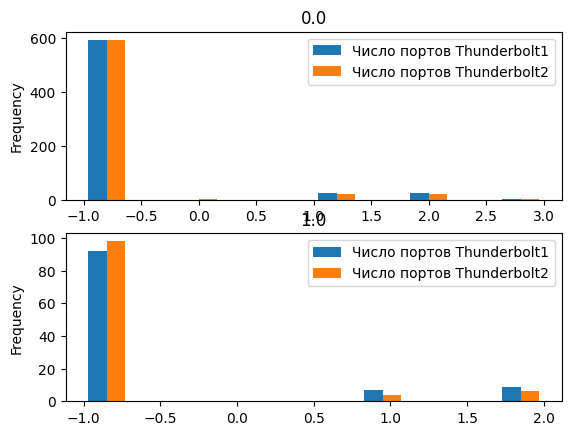

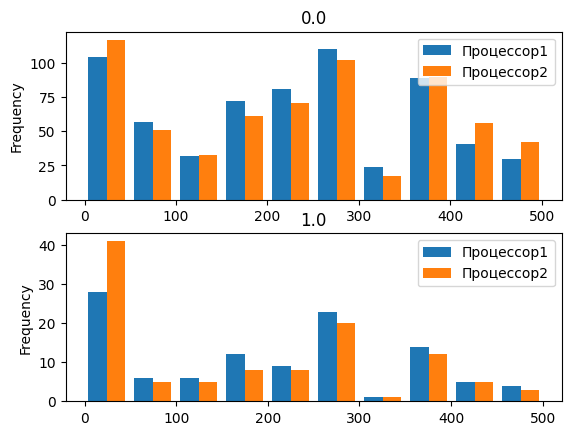

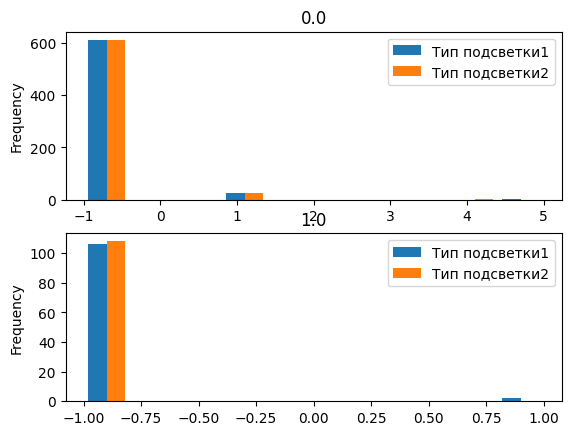

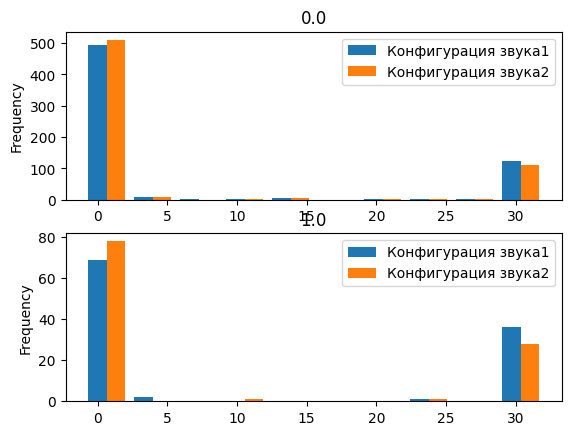

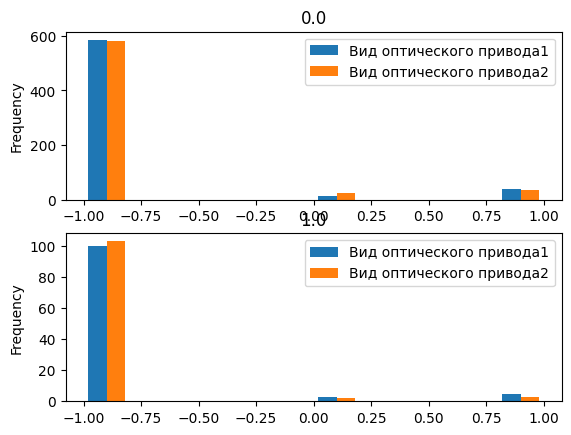

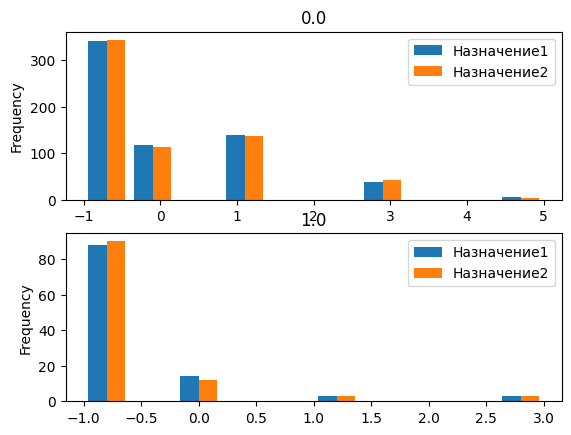

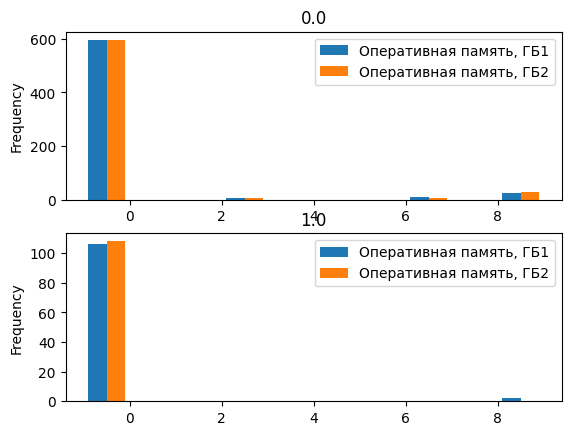

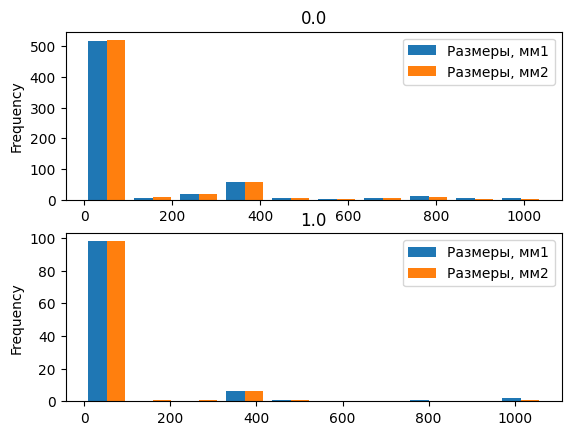

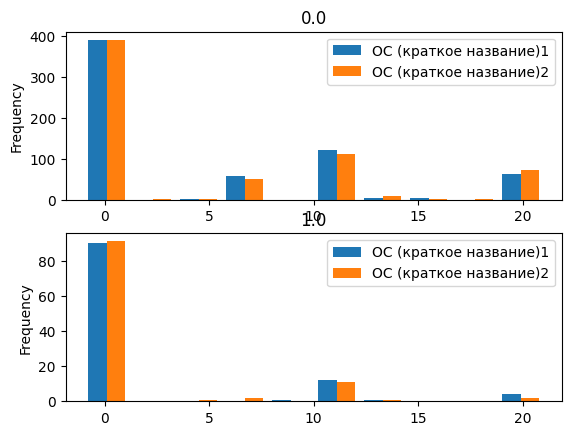

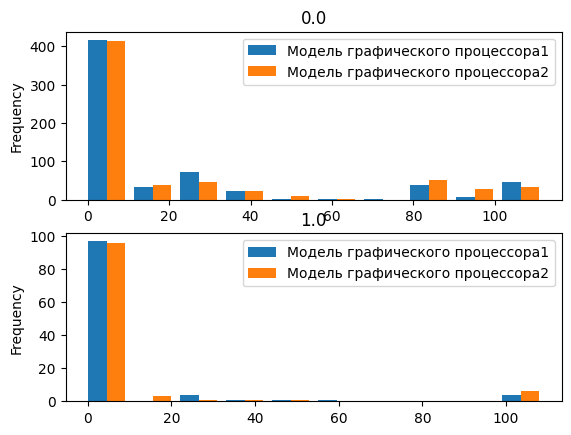

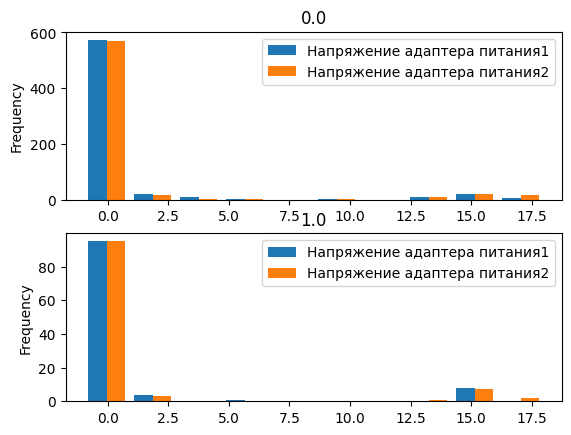

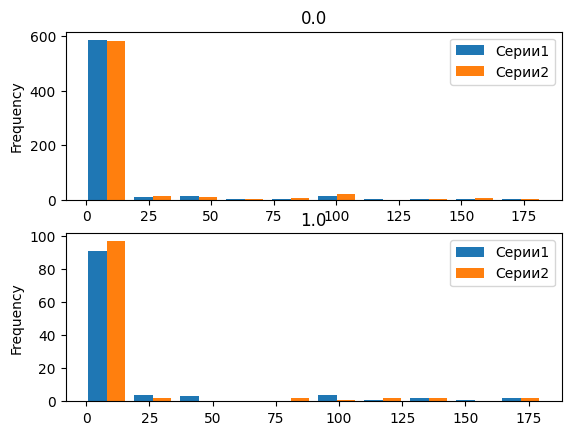

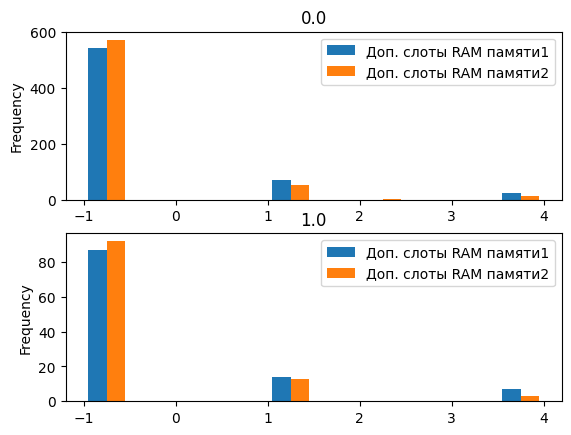

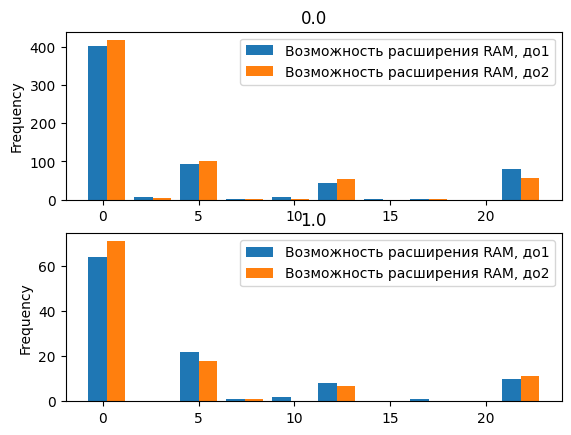

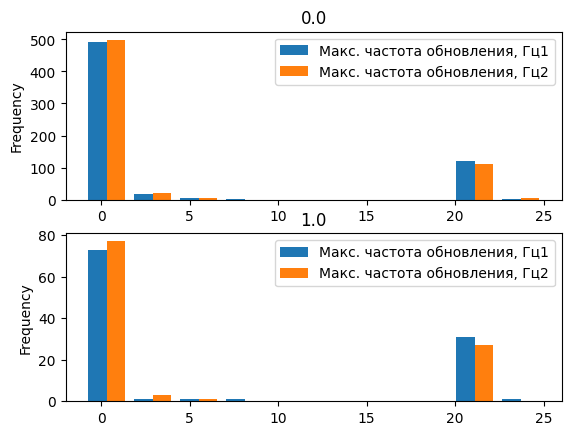

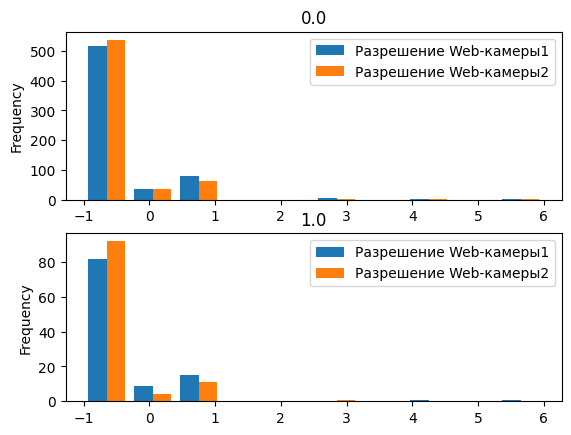

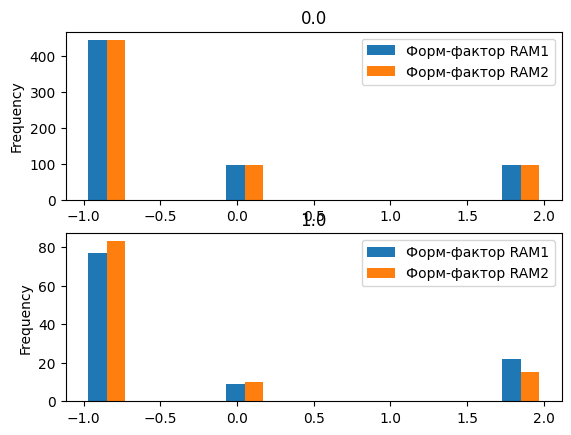

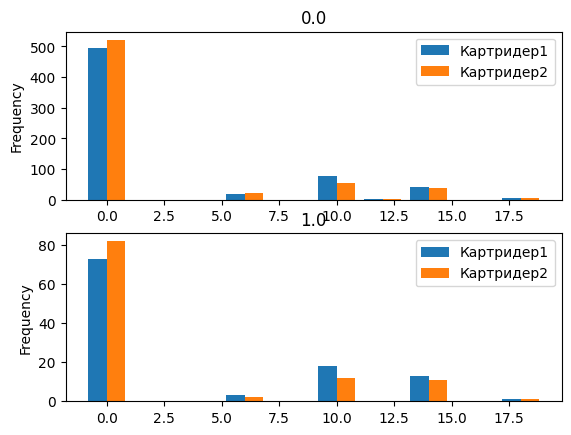

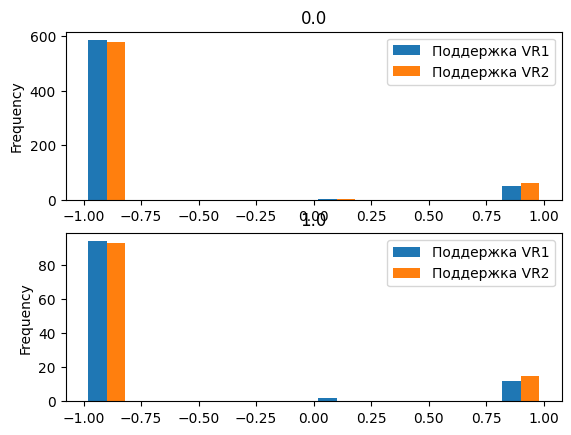

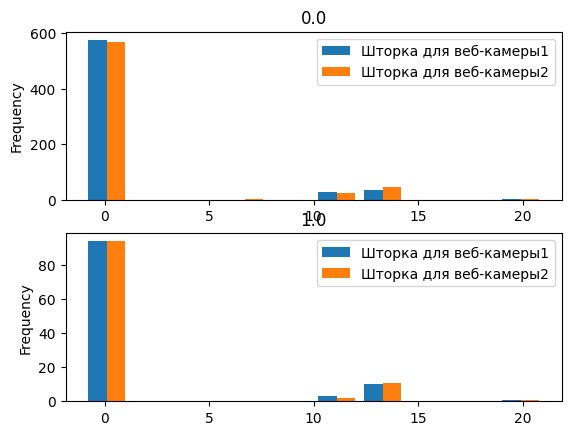

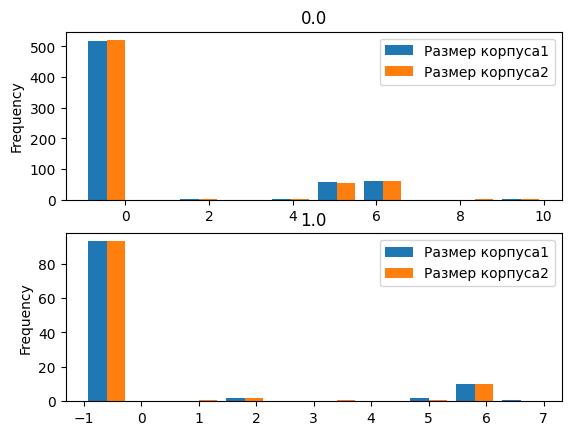

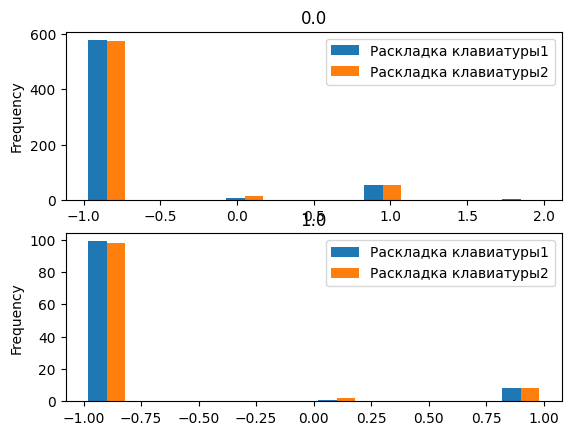

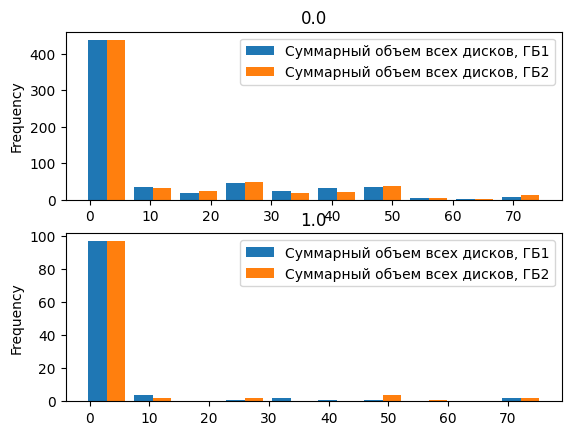

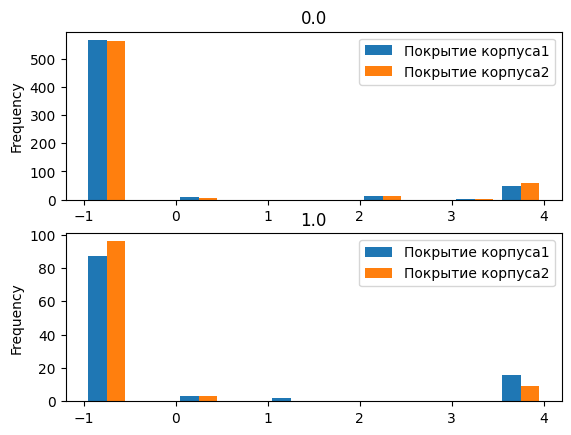

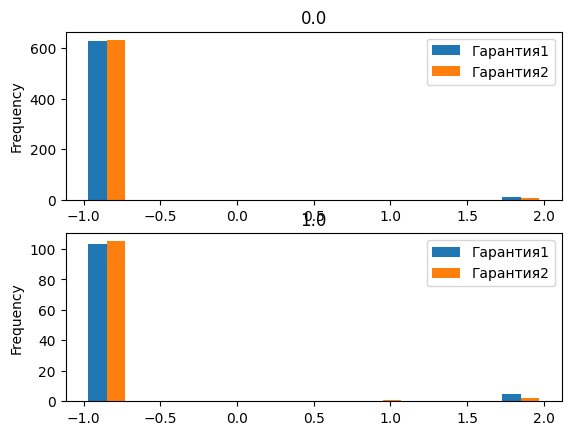

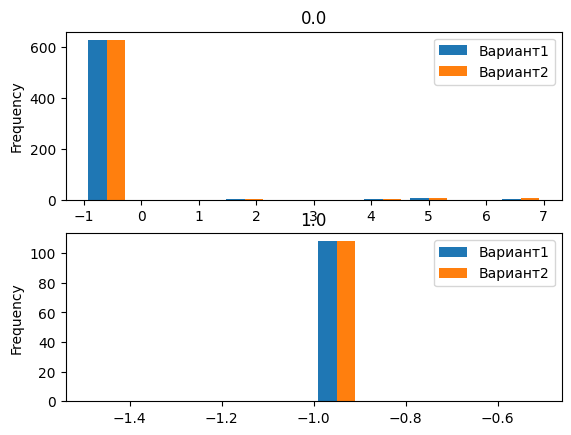

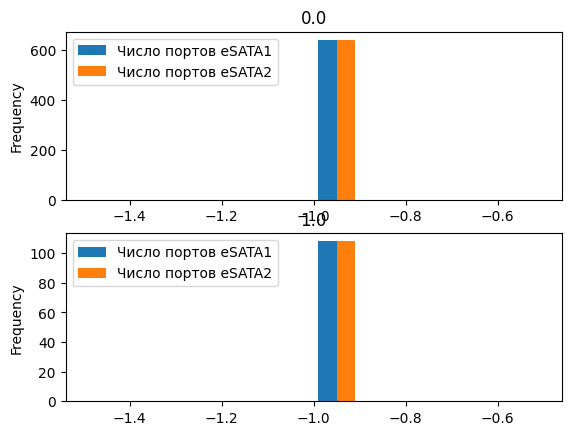

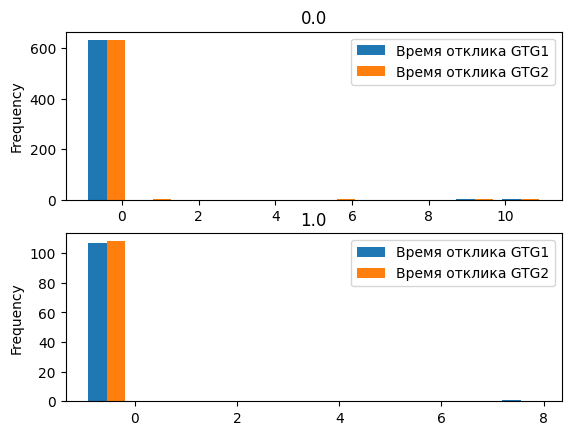

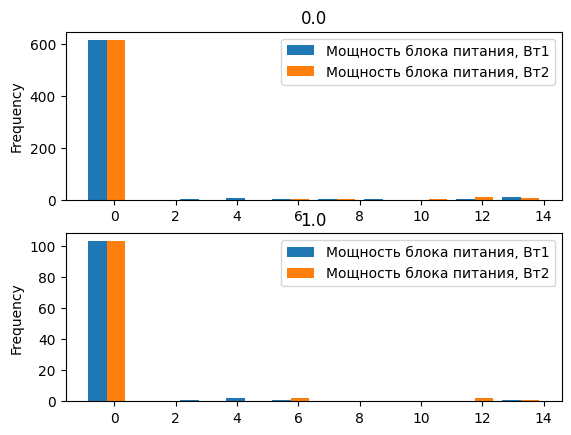

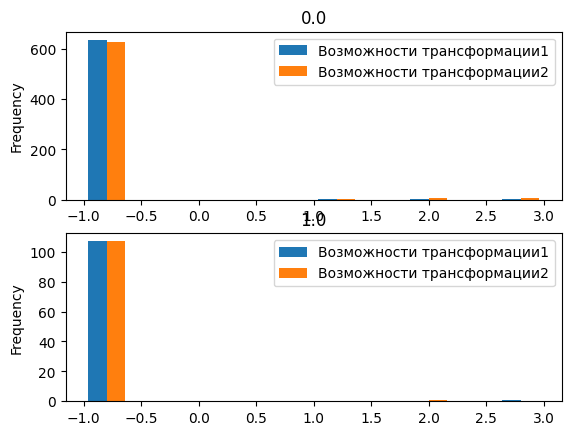

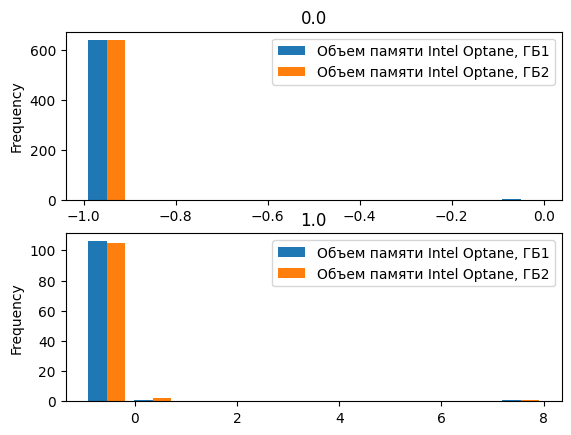

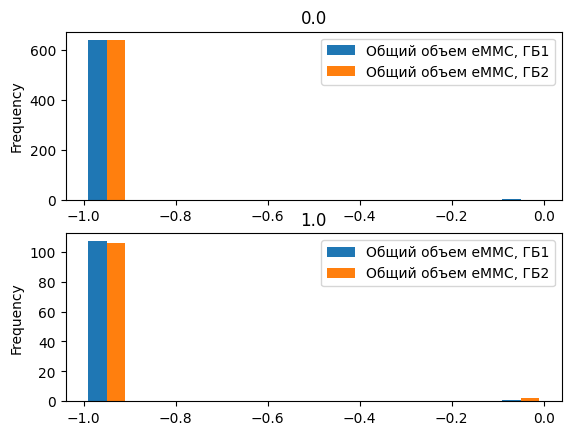

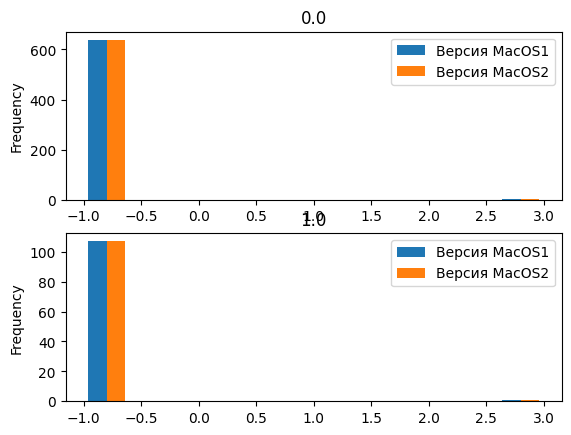

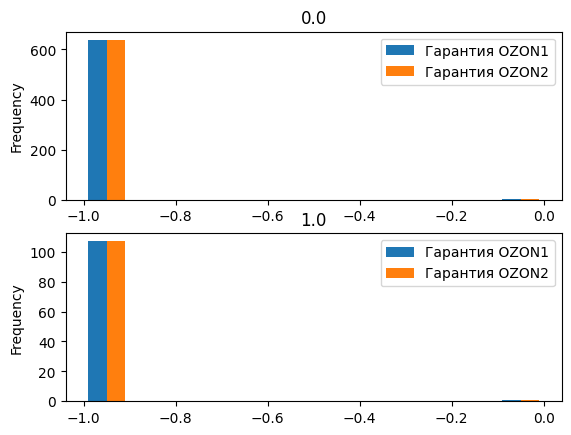

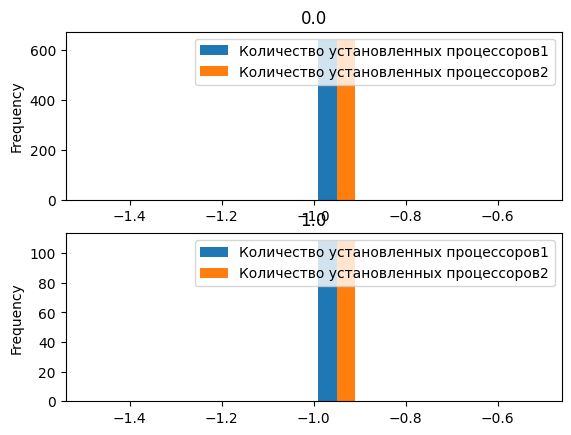

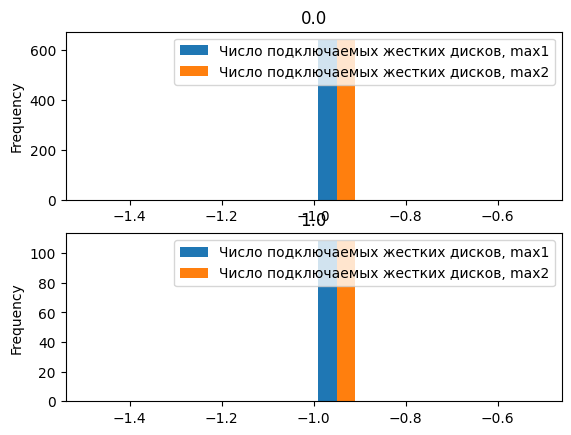

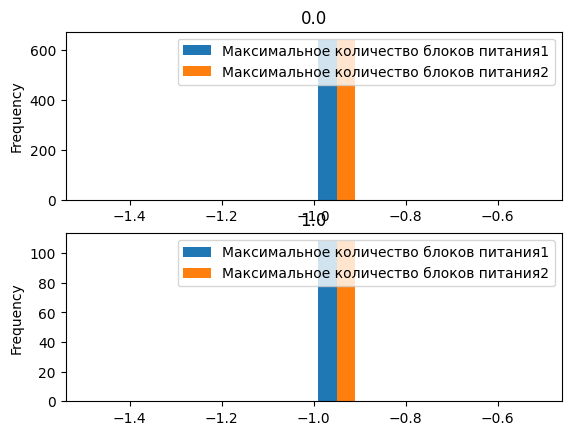

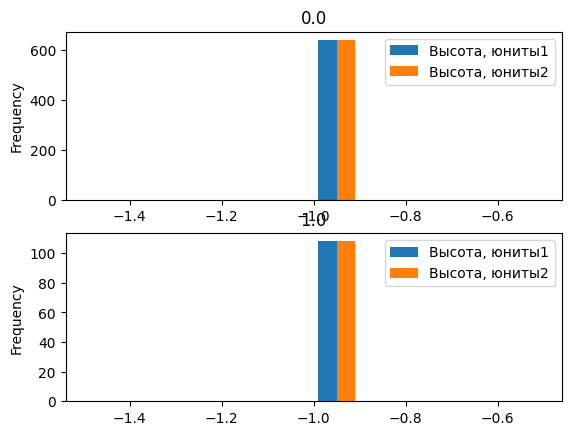

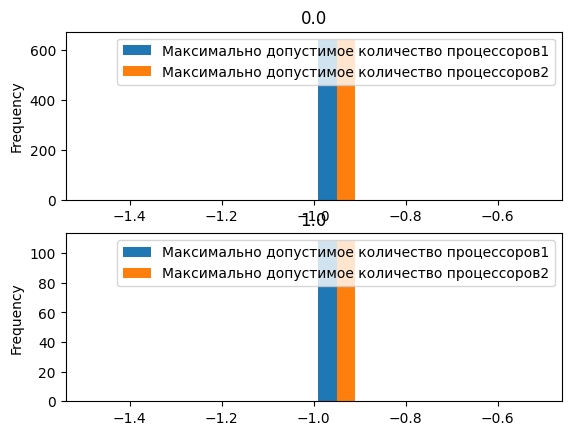

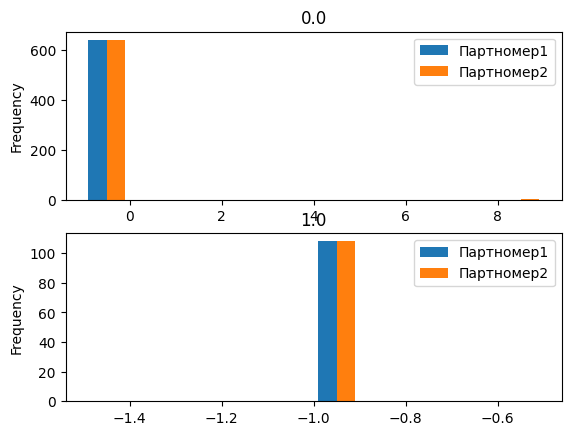

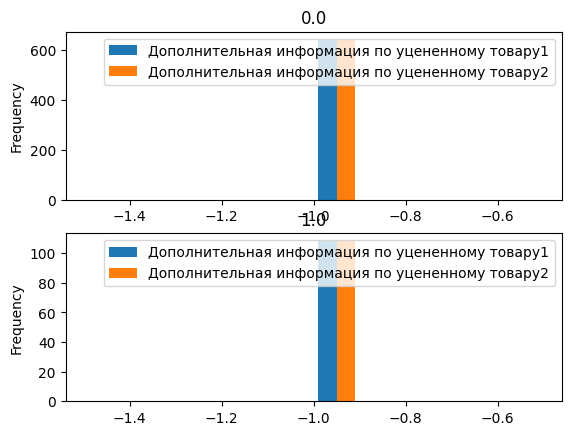

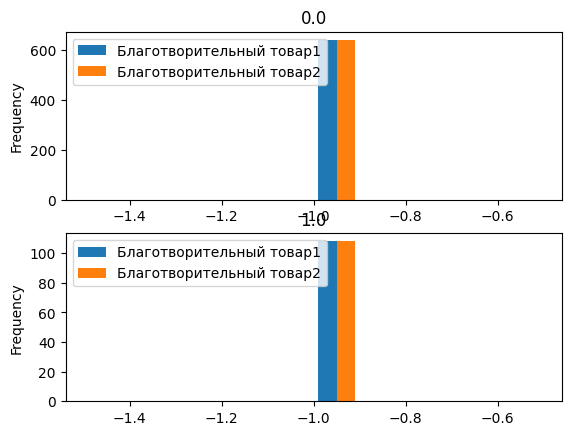

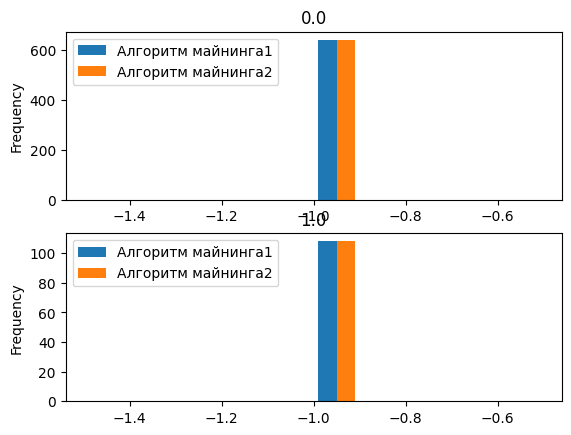

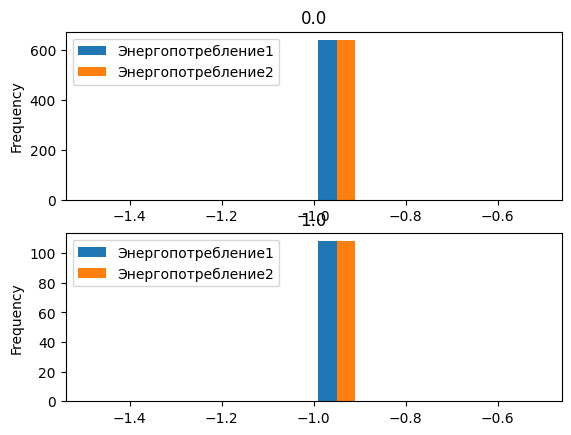

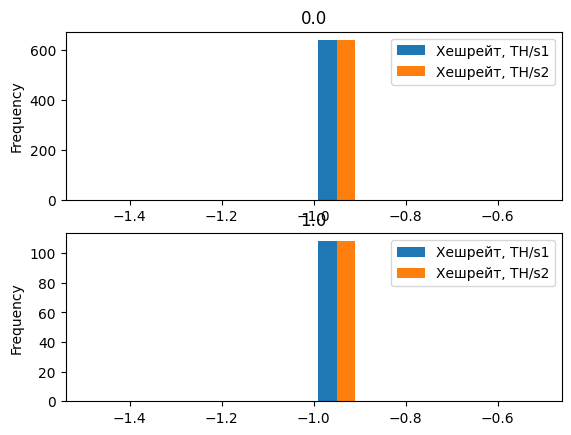

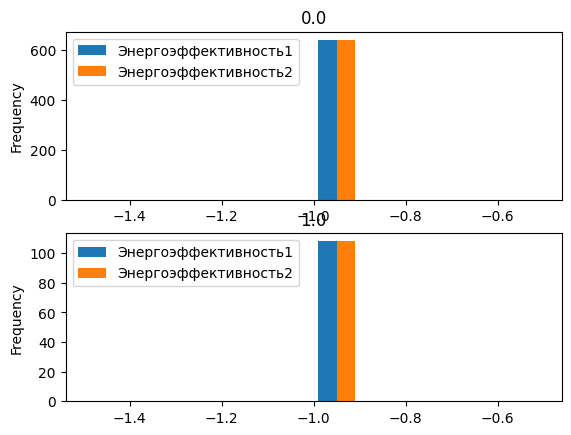

In [65]:
for column in tmp.columns:
    check[[f'{column}1',f'{column}2', 'target']].plot.hist(by='target')

In [ ]:
def attr_features(att1, att2):
    cnt1 = len(att1)
    cnt2 = len(att2)
    cnt_keys = len(att1.keys(att1) & att2.keys())
    s, r = 0, 0
    for key in att1.keys(att1) & att2.keys():
        tmp = len(set(att1[key]) & set(att2[key]))
        s += tmp
        r += int(len==0)

In [224]:
attr = {}
for cat in cat_data.cat3_grouped.unique():
    attr[cat] = defaultdict(set)
    for i, row in cat_data[cat_data.cat3_grouped==cat].iterrows():
        for key, values in row.characteristic_attributes_mapping.items():
            attr[cat][key].update(values)
        
# attr_cat

In [226]:
attr['Запчасти для ноутбуков'].keys()

dict_keys(['Бренд', 'Тип', 'Страна-изготовитель', 'Рекомендовано для', 'Гарантийный срок', 'Совместимость', 'Партномер', 'Цвет товара', 'Вес товара, г', 'Количество кнопок', 'Размеры, мм', 'Комплектация', 'Тип подсветки', 'Диагональ экрана, дюймы', 'Технология матрицы', 'Разрешение экрана', 'Покрытие экрана', 'Емкость, Вт•ч', 'Кол-во циклов заряд-разряд', 'Список совместимых устройств', 'Напряжение, В', 'Тип аккумулятора', 'Емкость, мА•ч', 'Материал', 'Особенности устройств ручного ввода', 'Назначение запчасти', 'Длина кабеля, см', 'Срок службы', 'Коннектор 1'])

In [ ]:
train_pairs = train_pairs \
        .merge(train_features.add_suffix('1'), on="variantid1", how='left') \
        .merge(train_features.add_suffix('2'), on="variantid2", how='left')
    
train_pairs['diff_name1'] = train_pairs.apply(lambda row: ' '.join(sorted(list(set(row.name1.lower().split()) - set(row.name2.lower().split())))), axis=1)
train_pairs['diff_name2'] = train_pairs.apply(lambda row: ' '.join(sorted(list(set(row.name2.lower().split()) - set(row.name1.lower().split())))), axis=1)
    

In [ ]:
train_pairs

In [15]:
''.join(map(str, range(0, 10)))

'0123456789'

In [93]:
[(key, len(value.keys())) for key, value in attr.items()]

[('Сетевые фильтры, разветвители и удлинители', 27),
 ('Кабели и переходники', 42),
 ('Оптические приборы', 35),
 ('Смартфоны, планшеты, мобильные телефоны', 93),
 ('rest', 496),
 ('Устройство ручного ввода', 67),
 ('Смарт-часы', 58),
 ('Сетевое оборудование', 63),
 ('Запчасти для ноутбуков', 29),
 ('Компьютер', 104),
 ('Карты памяти и флешки', 32),
 ('Расходник для печати', 31),
 ('Чехол', 30),
 ('Телевизоры', 51),
 ('Защитные пленки и стекла', 25),
 ('Рюкзаки, чехлы, сумки', 26),
 ('Принтеры и МФУ', 81),
 ('Батарейки и аккумуляторы', 45),
 ('Мониторы и запчасти', 47),
 ('Наушники и гарнитуры', 52),
 ('Жесткие диски, SSD и сетевые накопители', 46),
 ('Видеонаблюдение', 69),
 ('Процессор', 30),
 ('Материнская плата', 42),
 ('Оперативная память', 26),
 ('Запчасти для смартфонов', 16),
 ('Видеорегистратор', 57),
 ('ИБП', 43),
 ('Видеокарты и графические ускорители', 50),
 ('Зарядные устройства и док-станции', 42),
 ('Кронштейн', 39),
 ('Акустика и колонки', 70),
 ('Аксессуары для фото и 

## 4. Model analysis

### 4.2 Feature importances calculation 


For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). There is no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In the cell below we will use `automl_rd.model` instead `automl_rd` because we want to take the importances from the model, not from the report. But **be carefull** - everything, which is calculated using `automl_rd.model` will not go to the report.

CPU times: user 1.65 s, sys: 82 ms, total: 1.73 s
Wall time: 1.56 s


Feature   Importance
0                      Компьютер  3526.270188
1      fuzz_partial_service_name  3102.087302
2                       lev_attr  3008.127577
3            lev_ratio_full_name  1612.879818
4       fuzz_WRatio_service_name  1411.117103
..                           ...          ...
932          Крепление наушников     0.000000
933          Крепление микрофона     0.000000
934  Крепление видеорегистратора     0.000000
935            Кратность окуляра     0.000000
936               Яркость, кд/м2     0.000000

[937 rows x 2 columns]

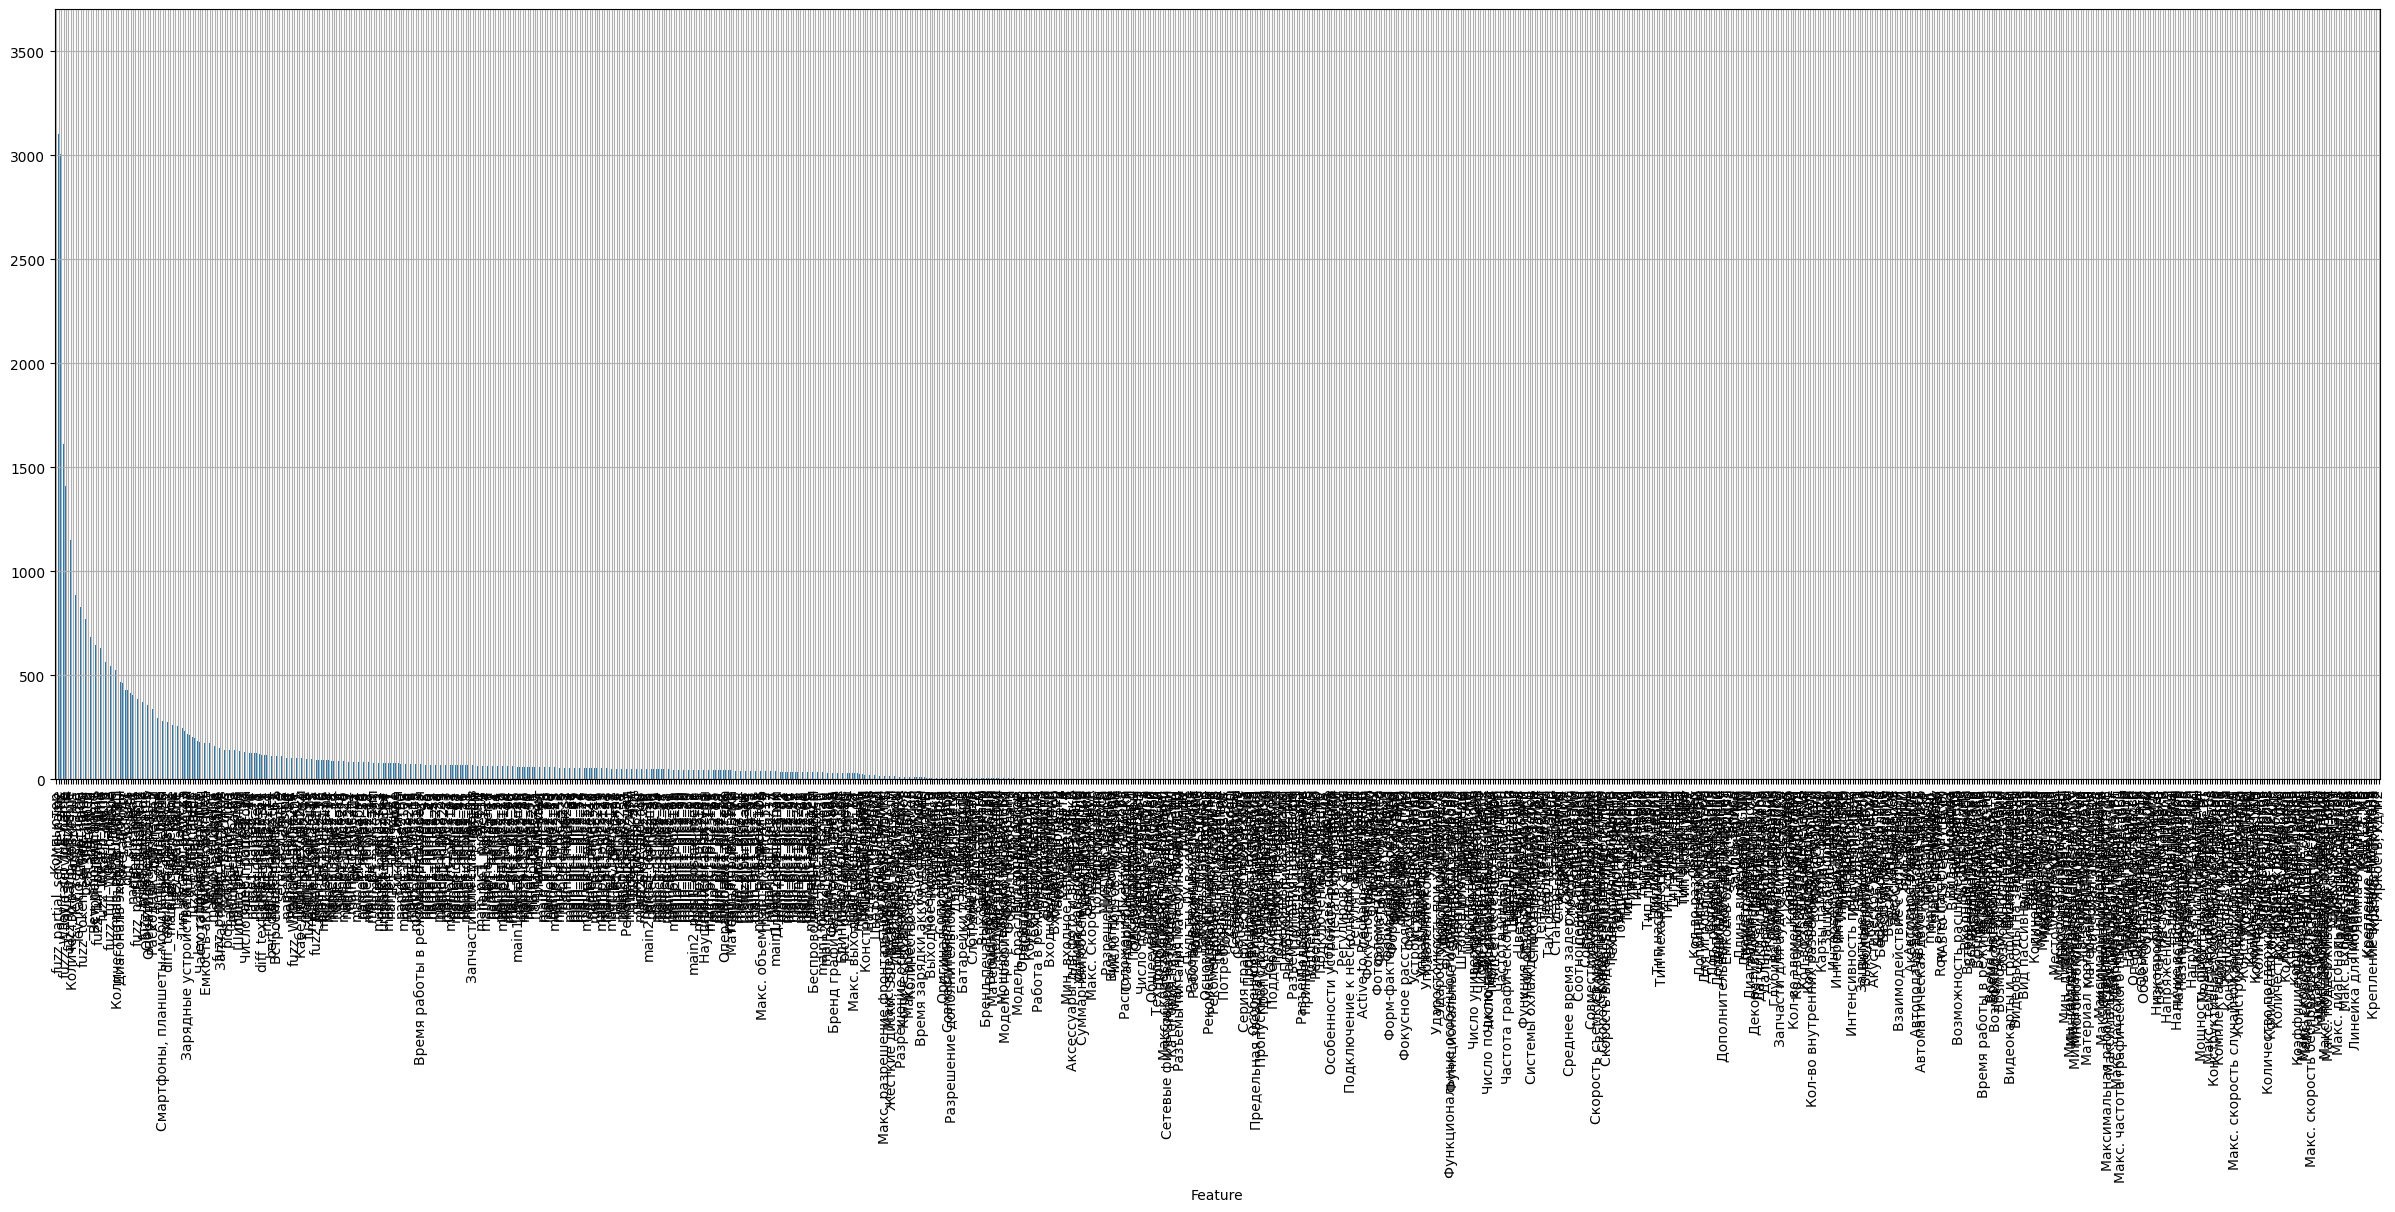

In [212]:
%%time

# Fast feature importances calculation
fast_fi = automl.get_feature_scores('fast')
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
fast_fi

In [220]:
%%time

# Accurate feature importances calculation with detailed info (Permutation importances) -  can take long time to calculate
accurate_fi = automl.get_feature_scores('accurate', valid.loc[valid_index], silent = True)

CPU times: user 3h 3min 15s, sys: 14.1 s, total: 3h 3min 29s
Wall time: 1h 1min 32s


In [218]:
valid.loc[valid_index].target.value_counts()

0.0    2248
1.0    1569
Name: target, dtype: int64

Feature  Importance
0                           Радиатор         0.0
1                  main_pic1_pic2_21         0.0
2                             Стекло         0.0
3                      Тип подсветки         0.0
4              Слот для карты памяти         0.0
..                               ...         ...
932        Основной материал корпуса         0.0
933                Рекомендовано для         0.0
934                main_pic1_pic2_77         0.0
935  Макс. скорость вращения, об/мин         0.0
936                Время отклика GTG         0.0

[937 rows x 2 columns]

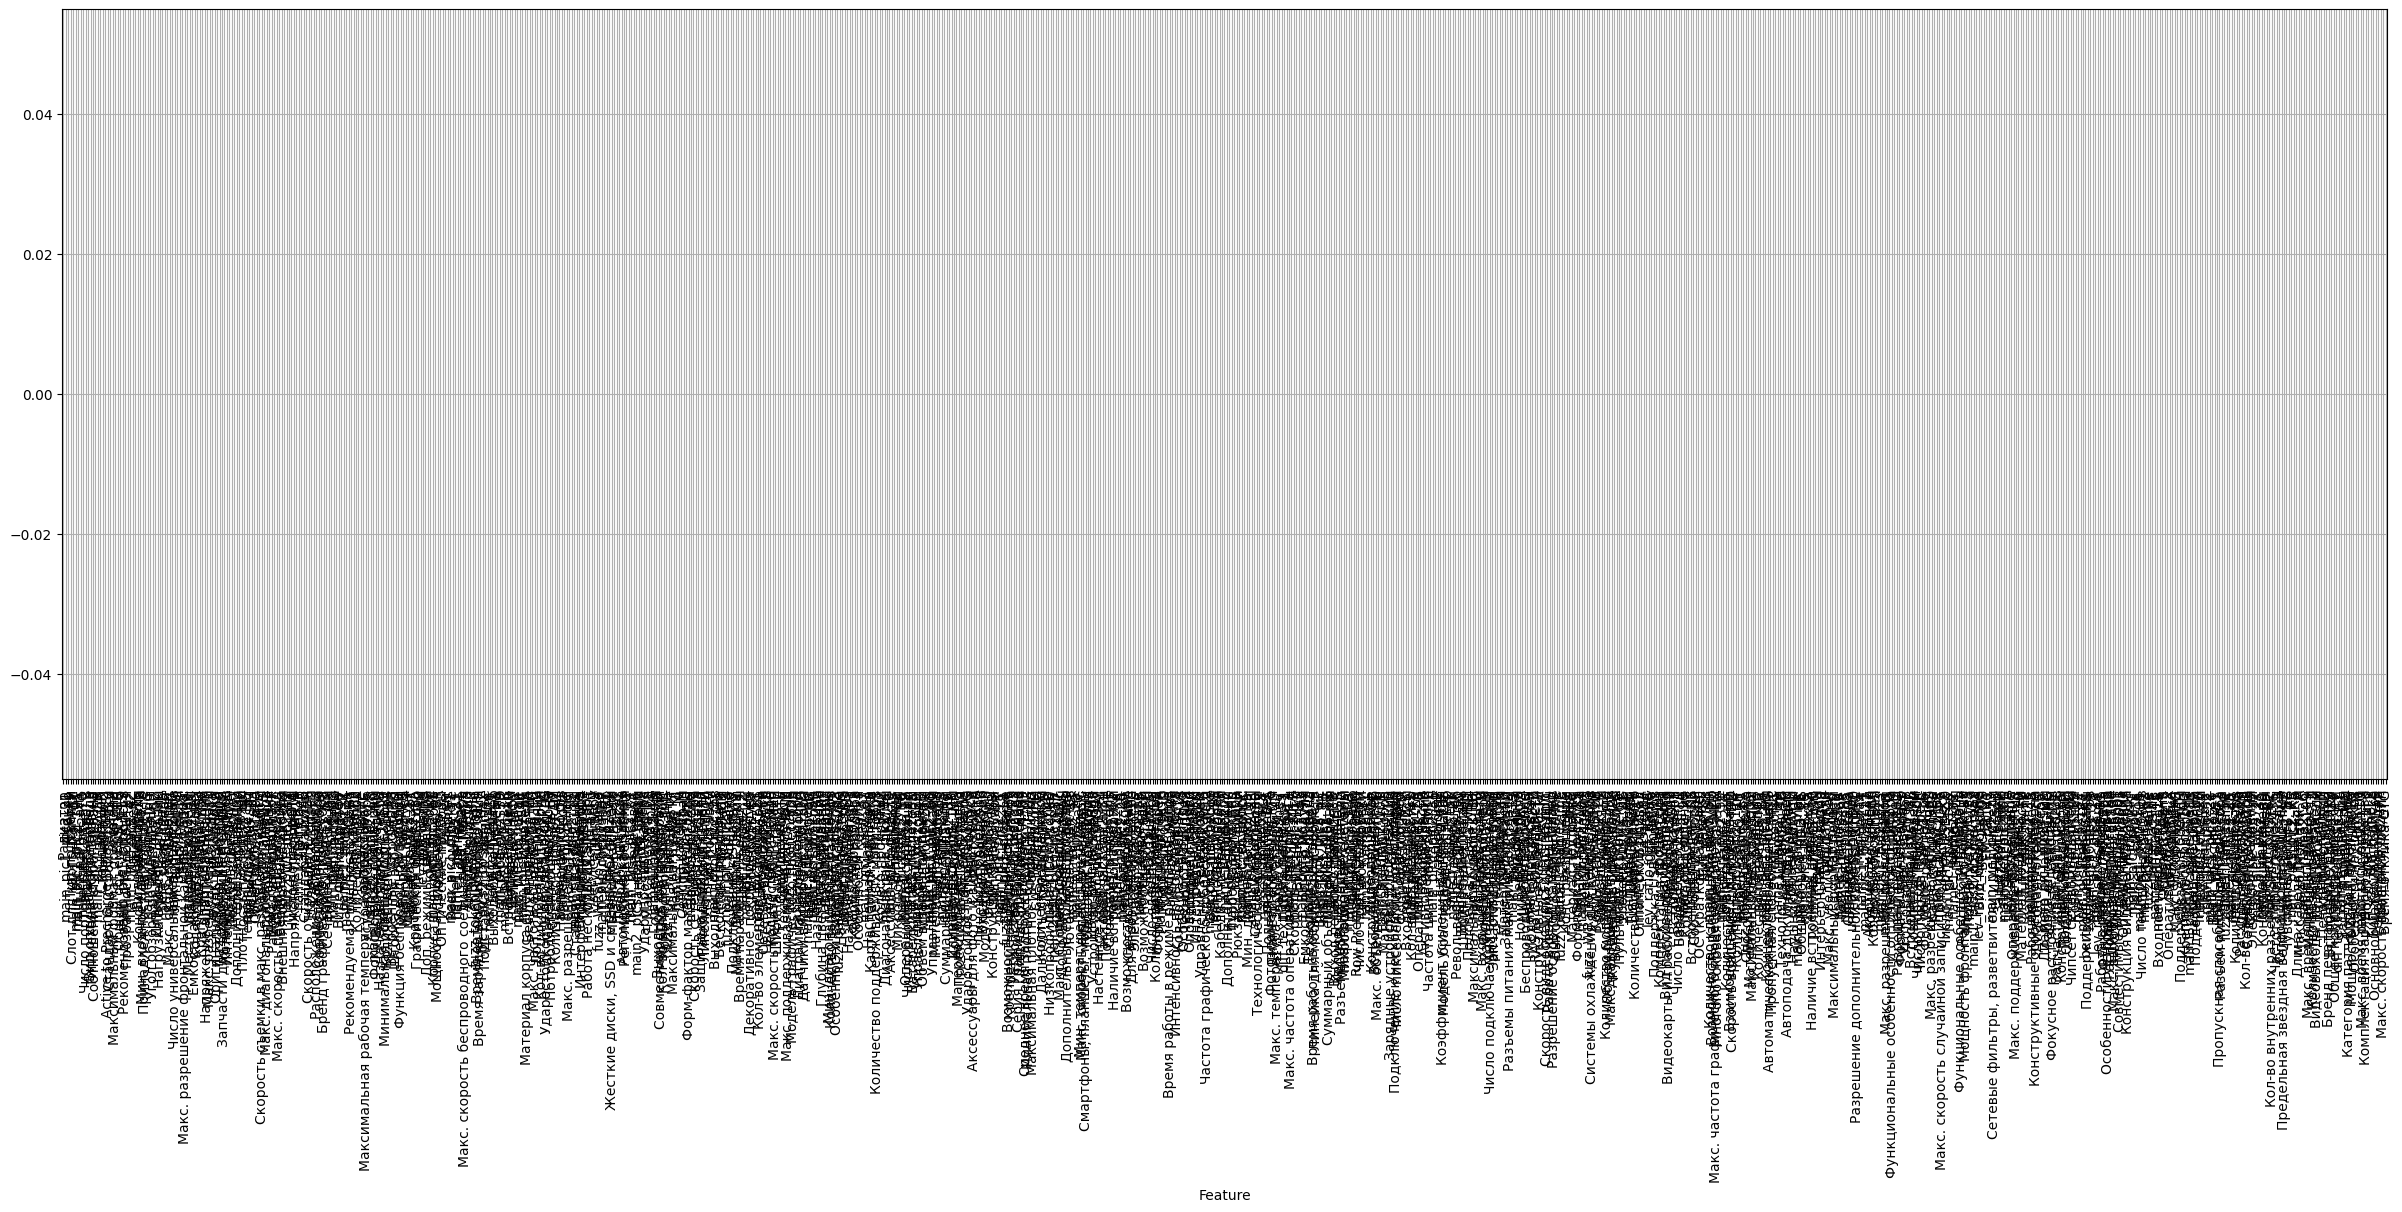

In [221]:
accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)
accurate_fi

In [ ]:
columns = accurate_fi[accurate_fi.Importance > 0].Feature.to_list()

In [137]:
test[TARGET_NAME] = automl.predict(test).data[:]

In [138]:
test.to_csv('sub.csv', columns=['variantid1','variantid2', TARGET_NAME], index=False)

In [43]:
test

variantid1  variantid2                             cat3_grouped  \
0        52076340   290590137                 Батарейки и аккумуляторы   
1        64525522   204128919  Смартфоны, планшеты, мобильные телефоны   
2        77243372   479860557                     Кабели и переходники   
3        86065820   540678372                 Устройство ручного ввода   
4        91566575   258840506  Смартфоны, планшеты, мобильные телефоны   
...           ...         ...                                      ...   
18079   666998614   667074522                       Оперативная память   
18080   670036240   670048449        Зарядные устройства и док-станции   
18081   670284509   684323809                               Смарт-часы   
18082   692172005   704805270                                     rest   
18083   704060220   704096517        Зарядные устройства и док-станции   

        weights  cnt_pics1  cnt_main_pics1  cnt_colors1  \
0      0.032957        1.0               1            1   
1      0.051150        4.0               1            3   
2      0.059611        3.0               1            2   
3      0.022838       14.0               1            1   
4      0.051150        1.0               1            2   
...         ...        ...             ...          ...   
18079  0.012221        3.0               1            1   
18080  0.102245        0.0               1            1   
18081  0.085435        0.0               1            2   
18082  0.029695        4.0               1            1   
18083  0.102245        2.0               1            1   

                                        cat_31                     cat_41  \
0                     Батарейки и аккумуляторы                  Батарейка   
1      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
2                         Кабели и переходники                     Кабель   
3                     Устройство ручного ввода                       Мышь   
4      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
...                                        ...                        ...   
18079                       Оперативная память  Модуль оперативной памяти   
18080        Зарядные устройства и док-станции  Компьютерный блок питания   
18081                               Смарт-часы    Ремешок для смарт-часов   
18082                                 Проектор                   Проектор   
18083        Зарядные устройства и док-станции  Компьютерный блок питания   

       cnt_pics2  ...  lev_service_name  lev_ratio_service_name  \
0            1.0  ...                 4                0.727273   
1            1.0  ...                 2                0.714286   
2            0.0  ...                24                0.588235   
3            4.0  ...                19                0.612245   
4            1.0  ...                 5                0.761905   
...          ...  ...               ...                     ...   
18079        3.0  ...                16                0.757282   
18080        0.0  ...                 6                0.636364   
18081        0.0  ...                24                0.285714   
18082        5.0  ...                 0                1.000000   
18083        2.0  ...                 2                0.949153   

      fuzz_diff_name fuzz_partial_diff_name fuzz_token_diff_name  \
0                 44                     67                   44   
1                 71                     71                   71   
2                 38                     43                   60   
3                 40                     41                   59   
4                 55                     67                   36   
...              ...                    ...                  ...   
18079             43                     46                   29   
18080             64                     53                   64   
18081             19                     20                   33   

In [66]:
train[['pred',TARGET_NAME, 'variantid1','variantid2', 'cat3_grouped']].to_parquet('train_pred.parquet')
valid[['pred',TARGET_NAME, 'variantid1','variantid2', 'cat3_grouped']].to_parquet('valid_pred.parquet')


In [61]:
test = pd.read_parquet('test.parquet')

In [62]:
test

variantid1  variantid2                             cat3_grouped  \
0        52076340   290590137                 Батарейки и аккумуляторы   
1        64525522   204128919  Смартфоны, планшеты, мобильные телефоны   
2        77243372   479860557                     Кабели и переходники   
3        86065820   540678372                 Устройство ручного ввода   
4        91566575   258840506  Смартфоны, планшеты, мобильные телефоны   
...           ...         ...                                      ...   
18110   666998614   667074522                       Оперативная память   
18111   670036240   670048449        Зарядные устройства и док-станции   
18112   670284509   684323809                               Смарт-часы   
18113   692172005   704805270                                     rest   
18114   704060220   704096517        Зарядные устройства и док-станции   

        weights  cnt_pics1  cnt_main_pics1  cnt_colors1  \
0      0.032957        1.0               1            1   
1      0.051150        4.0               1            3   
2      0.059611        3.0               1            2   
3      0.022838       14.0               1            1   
4      0.051150        1.0               1            2   
...         ...        ...             ...          ...   
18110  0.012221        3.0               1            1   
18111  0.102245        0.0               1            1   
18112  0.085435        0.0               1            2   
18113  0.029695        4.0               1            1   
18114  0.102245        2.0               1            1   

                                        cat_31                     cat_41  \
0                     Батарейки и аккумуляторы                  Батарейка   
1      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
2                         Кабели и переходники                     Кабель   
3                     Устройство ручного ввода                       Мышь   
4      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
...                                        ...                        ...   
18110                       Оперативная память  Модуль оперативной памяти   
18111        Зарядные устройства и док-станции  Компьютерный блок питания   
18112                               Смарт-часы    Ремешок для смарт-часов   
18113                                 Проектор                   Проектор   
18114        Зарядные устройства и док-станции  Компьютерный блок питания   

       cnt_pics2  ...  lev_maybe_model  lev_ratio_maybe_model fuzz_eng_mod  \
0            1.0  ...              NaN                    NaN         86.0   
1            1.0  ...              NaN                    NaN         94.0   
2            0.0  ...              NaN                    NaN         21.0   
3            4.0  ...              NaN                    NaN         68.0   
4            1.0  ...              NaN                    NaN         76.0   
...          ...  ...              ...                    ...          ...   
18110        3.0  ...              NaN                    NaN         74.0   
18111        0.0  ...              6.0               0.636364         71.0   
18112        0.0  ...             17.0               0.315789         36.0   
18113        5.0  ...              NaN                    NaN        100.0   
18114        2.0  ...              2.0               0.926829         91.0   

      fuzz_partial_eng_mod fuzz_token_eng_mod fuzz_WRatio_eng_mod  \
0                     82.0               86.0                89.0   
1                     94.0               94.0                94.0   
2                    100.0               21.0                60.0   
3                     73.0               64.0                70.0   
4                     75.0               57.0                86.0   
...                    ...                ...                 ...   
18110                 76.0               67.0                76.

In [8]:
test = pd.read_parquet('test.parquet')

In [7]:
valid = pd.read_parquet('valid.parquet')

In [77]:
train = ""
train = pd.read_parquet('train.parquet')

In [78]:
import gc

gc.collect()

0

In [79]:
from catboost import CatBoostClassifier
from catboost import CatBoostRegressor

In [10]:
#train = train.merge(test_features[["categories", 'variantid']].add_suffix('3'),on="variantid1")

In [9]:
train_target = train["target"]

In [10]:
train.drop(columns = ["target"], inplace=True)

In [52]:
train_target

0         0.0
1         0.0
2         1.0
3         1.0
4         1.0
         ... 
286642    0.0
286643    1.0
286644    1.0
286645    0.0
286646    0.0
Name: target, Length: 286647, dtype: float64

In [38]:
#train = train.select_dtypes(exclude=['object'])

In [39]:
#valid =  valid.select_dtypes(exclude=['object'])

In [81]:
cat_f = valid.columns[np.where(np.array(list(map(lambda x: x not in valid._get_numeric_data().columns, valid.columns))))[0]]

In [82]:
#df = train.select_dtypes(exclude=['object'])

In [83]:
#df.columns

In [16]:
train[cat_f.drop("cat3")].fillna(value="", inplace=True)

C:\Users\Valentine\AppData\Local\Temp\ipykernel_1092\431439915.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[cat_f.drop("cat3")].fillna(value="", inplace=True)


In [17]:
valid[cat_f].fillna(value="", inplace=True)

C:\Users\Valentine\AppData\Local\Temp\ipykernel_1092\2187615785.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[cat_f].fillna(value="", inplace=True)


In [84]:
test[cat_f.drop("cat3")].fillna(value="", inplace=True)

C:\Users\Valentine\AppData\Local\Temp\ipykernel_1092\1409175758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[cat_f.drop("cat3")].fillna(value="", inplace=True)


In [85]:
test

variantid1  variantid2                             cat3_grouped  \
0        52076340   290590137                 Батарейки и аккумуляторы   
1        64525522   204128919  Смартфоны, планшеты, мобильные телефоны   
2        77243372   479860557                     Кабели и переходники   
3        86065820   540678372                 Устройство ручного ввода   
4        91566575   258840506  Смартфоны, планшеты, мобильные телефоны   
...           ...         ...                                      ...   
18110   666998614   667074522                       Оперативная память   
18111   670036240   670048449        Зарядные устройства и док-станции   
18112   670284509   684323809                               Смарт-часы   
18113   692172005   704805270                                     rest   
18114   704060220   704096517        Зарядные устройства и док-станции   

        weights  cnt_pics1  cnt_main_pics1  cnt_colors1  \
0      0.032957        1.0               1            1   
1      0.051150        4.0               1            3   
2      0.059611        3.0               1            2   
3      0.022838       14.0               1            1   
4      0.051150        1.0               1            2   
...         ...        ...             ...          ...   
18110  0.012221        3.0               1            1   
18111  0.102245        0.0               1            1   
18112  0.085435        0.0               1            2   
18113  0.029695        4.0               1            1   
18114  0.102245        2.0               1            1   

                                        cat_31                     cat_41  \
0                     Батарейки и аккумуляторы                  Батарейка   
1      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
2                         Кабели и переходники                     Кабель   
3                     Устройство ручного ввода                       Мышь   
4      Смартфоны, планшеты, мобильные телефоны                   Смартфон   
...                                        ...                        ...   
18110                       Оперативная память  Модуль оперативной памяти   
18111        Зарядные устройства и док-станции  Компьютерный блок питания   
18112                               Смарт-часы    Ремешок для смарт-часов   
18113                                 Проектор                   Проектор   
18114        Зарядные устройства и док-станции  Компьютерный блок питания   

       cnt_pics2  ...  lev_maybe_model  lev_ratio_maybe_model fuzz_eng_mod  \
0            1.0  ...              NaN                    NaN         86.0   
1            1.0  ...              NaN                    NaN         94.0   
2            0.0  ...              NaN                    NaN         21.0   
3            4.0  ...              NaN                    NaN         68.0   
4            1.0  ...              NaN                    NaN         76.0   
...          ...  ...              ...                    ...          ...   
18110        3.0  ...              NaN                    NaN         74.0   
18111        0.0  ...              6.0               0.636364         71.0   
18112        0.0  ...             17.0               0.315789         36.0   
18113        5.0  ...              NaN                    NaN        100.0   
18114        2.0  ...              2.0               0.926829         91.0   

      fuzz_partial_eng_mod fuzz_token_eng_mod fuzz_WRatio_eng_mod  \
0                     82.0               86.0                89.0   
1                     94.0               94.0                94.0   
2                    100.0               21.0                60.0   
3                     73.0               64.0                70.0   
4                     75.0               57.0                86.0   
...                    ...                ...                 ...   
18110                 76.0               67.0                76.

In [20]:
valid[cat_f.drop("cat3")].fillna(value="", inplace=True)

C:\Users\Valentine\AppData\Local\Temp\ipykernel_6052\2474320320.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid[cat_f.drop("cat3")].fillna(value="", inplace=True)


In [19]:
cat_f = cat_f.drop("cat3")

In [20]:
train = train.fillna(value=np.nan)

In [22]:
train[cat_f] = train[cat_f].astype(str)

In [23]:
valid[cat_f] = valid[cat_f].astype(str)

In [86]:
test[cat_f.drop("cat3")] = test[cat_f.drop("cat3")].astype(str)

In [87]:
test.columns

Index(['variantid1', 'variantid2', 'cat3_grouped', 'weights', 'cnt_pics1',
       'cnt_main_pics1', 'cnt_colors1', 'cat_31', 'cat_41', 'cnt_pics2',
       ...
       'lev_maybe_model', 'lev_ratio_maybe_model', 'fuzz_eng_mod',
       'fuzz_partial_eng_mod', 'fuzz_token_eng_mod', 'fuzz_WRatio_eng_mod',
       'lev_eng_mod', 'lev_ratio_eng_mod', 'attr_emb_correlation',
       'attr_emb_cosine'],
      dtype='object', length=1349)

In [92]:
valid.columns

Index(['target', 'variantid1', 'variantid2', 'cat3', 'cnt_pics1',
       'cnt_main_pics1', 'cnt_colors1', 'cat_31', 'cat_41', 'cnt_pics2',
       ...
       'lev_maybe_model', 'lev_ratio_maybe_model', 'fuzz_eng_mod',
       'fuzz_partial_eng_mod', 'fuzz_token_eng_mod', 'fuzz_WRatio_eng_mod',
       'lev_eng_mod', 'lev_ratio_eng_mod', 'attr_emb_correlation',
       'attr_emb_cosine'],
      dtype='object', length=1351)

In [28]:
model = CatBoostClassifier(iterations=3000,
                          learning_rate=0.03,
                          depth=6, task_type="GPU", cat_features=cat_f.tolist(), snapshot_interval=120, save_snapshot=True)
# Fit model sample_weight = train["weight"]
model.fit(train, (train_target>=0.5).astype(int), verbose=True, eval_set=(valid.drop(columns = ["target", "cat3"]).reindex(columns = train.columns),valid["target"]), plot=True  )
# Get predictions
#preds = model.predict(eval_data)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2353:	learn: 0.3189229	test: 0.3805083	best: 0.3804848 (2344)	total: 17m 59s	remaining: 5m 57s
2354:	learn: 0.3189128	test: 0.3805040	best: 0.3804848 (2344)	total: 17m 59s	remaining: 4m 24s
2355:	learn: 0.3189046	test: 0.3805057	best: 0.3804848 (2344)	total: 17m 59s	remaining: 3m 58s
2356:	learn: 0.3188957	test: 0.3805042	best: 0.3804848 (2344)	total: 18m	remaining: 3m 45s
2357:	learn: 0.3188865	test: 0.3805061	best: 0.3804848 (2344)	total: 18m	remaining: 3m 35s
2358:	learn: 0.3188817	test: 0.3805024	best: 0.3804848 (2344)	total: 18m	remaining: 3m 28s
2359:	learn: 0.3188751	test: 0.3805027	best: 0.3804848 (2344)	total: 18m 1s	remaining: 3m 23s
2360:	learn: 0.3188678	test: 0.3805034	best: 0.3804848 (2344)	total: 18m 1s	remaining: 3m 22s
2361:	learn: 0.3188573	test: 0.3804955	best: 0.3804848 (2344)	total: 18m 1s	remaining: 3m 18s
2362:	learn: 0.3188495	test: 0.3805010	best: 0.3804848 (2344)	total: 18m 1s	remaining: 3m 15s
2363:	learn: 0.3188413	test: 0.3804996	best: 0.3804848 (2344)	tota

2440:	learn: 0.3181644	test: 0.3805057	best: 0.3804719 (2403)	total: 18m 36s	remaining: 3m 59s
2441:	learn: 0.3181538	test: 0.3805075	best: 0.3804719 (2403)	total: 18m 36s	remaining: 3m 58s
2442:	learn: 0.3181430	test: 0.3805146	best: 0.3804719 (2403)	total: 18m 37s	remaining: 3m 56s
2443:	learn: 0.3181315	test: 0.3805103	best: 0.3804719 (2403)	total: 18m 37s	remaining: 3m 55s
2444:	learn: 0.3181242	test: 0.3805119	best: 0.3804719 (2403)	total: 18m 37s	remaining: 3m 54s
2445:	learn: 0.3181144	test: 0.3805118	best: 0.3804719 (2403)	total: 18m 37s	remaining: 3m 52s
2446:	learn: 0.3181062	test: 0.3805105	best: 0.3804719 (2403)	total: 18m 38s	remaining: 3m 51s
2447:	learn: 0.3180974	test: 0.3805072	best: 0.3804719 (2403)	total: 18m 38s	remaining: 3m 50s
2448:	learn: 0.3180880	test: 0.3805027	best: 0.3804719 (2403)	total: 18m 38s	remaining: 3m 49s
2449:	learn: 0.3180807	test: 0.3804981	best: 0.3804719 (2403)	total: 18m 38s	remaining: 3m 48s
2450:	learn: 0.3180752	test: 0.3804960	best: 0.380

2527:	learn: 0.3173547	test: 0.3804337	best: 0.3804146 (2510)	total: 19m 8s	remaining: 3m 9s
2528:	learn: 0.3173445	test: 0.3804325	best: 0.3804146 (2510)	total: 19m 9s	remaining: 3m 8s
2529:	learn: 0.3173319	test: 0.3804350	best: 0.3804146 (2510)	total: 19m 9s	remaining: 3m 7s
2530:	learn: 0.3173264	test: 0.3804415	best: 0.3804146 (2510)	total: 19m 10s	remaining: 3m 8s
2531:	learn: 0.3173131	test: 0.3804514	best: 0.3804146 (2510)	total: 19m 11s	remaining: 3m 9s
2532:	learn: 0.3173024	test: 0.3804503	best: 0.3804146 (2510)	total: 19m 12s	remaining: 3m 10s
2533:	learn: 0.3172951	test: 0.3804507	best: 0.3804146 (2510)	total: 19m 13s	remaining: 3m 11s
2534:	learn: 0.3172871	test: 0.3804517	best: 0.3804146 (2510)	total: 19m 13s	remaining: 3m 11s
2535:	learn: 0.3172785	test: 0.3804507	best: 0.3804146 (2510)	total: 19m 14s	remaining: 3m 12s
2536:	learn: 0.3172688	test: 0.3804478	best: 0.3804146 (2510)	total: 19m 15s	remaining: 3m 13s
2537:	learn: 0.3172621	test: 0.3804459	best: 0.3804146 (25

2614:	learn: 0.3166237	test: 0.3803655	best: 0.3803618 (2613)	total: 19m 59s	remaining: 2m 57s
2615:	learn: 0.3166102	test: 0.3803651	best: 0.3803618 (2613)	total: 20m	remaining: 2m 57s
2616:	learn: 0.3166053	test: 0.3803669	best: 0.3803618 (2613)	total: 20m	remaining: 2m 56s
2617:	learn: 0.3165985	test: 0.3803654	best: 0.3803618 (2613)	total: 20m	remaining: 2m 55s
2618:	learn: 0.3165890	test: 0.3803633	best: 0.3803618 (2613)	total: 20m	remaining: 2m 55s
2619:	learn: 0.3165825	test: 0.3803611	best: 0.3803611 (2619)	total: 20m 1s	remaining: 2m 54s
2620:	learn: 0.3165701	test: 0.3803562	best: 0.3803562 (2620)	total: 20m 1s	remaining: 2m 53s
2621:	learn: 0.3165635	test: 0.3803581	best: 0.3803562 (2620)	total: 20m 1s	remaining: 2m 52s
2622:	learn: 0.3165531	test: 0.3803625	best: 0.3803562 (2620)	total: 20m 2s	remaining: 2m 52s
2623:	learn: 0.3165495	test: 0.3803652	best: 0.3803562 (2620)	total: 20m 2s	remaining: 2m 51s
2624:	learn: 0.3165429	test: 0.3803604	best: 0.3803562 (2620)	total: 20

2701:	learn: 0.3158383	test: 0.3803127	best: 0.3803117 (2695)	total: 20m 54s	remaining: 2m 29s
2702:	learn: 0.3158290	test: 0.3803109	best: 0.3803109 (2702)	total: 20m 54s	remaining: 2m 29s
2703:	learn: 0.3158238	test: 0.3803126	best: 0.3803109 (2702)	total: 20m 54s	remaining: 2m 28s
2704:	learn: 0.3158107	test: 0.3803072	best: 0.3803072 (2704)	total: 20m 54s	remaining: 2m 27s
2705:	learn: 0.3157986	test: 0.3803117	best: 0.3803072 (2704)	total: 20m 55s	remaining: 2m 26s
2706:	learn: 0.3157937	test: 0.3803152	best: 0.3803072 (2704)	total: 20m 55s	remaining: 2m 26s
2707:	learn: 0.3157803	test: 0.3803201	best: 0.3803072 (2704)	total: 20m 55s	remaining: 2m 25s
2708:	learn: 0.3157717	test: 0.3803186	best: 0.3803072 (2704)	total: 20m 56s	remaining: 2m 24s
2709:	learn: 0.3157624	test: 0.3803197	best: 0.3803072 (2704)	total: 20m 56s	remaining: 2m 24s
2710:	learn: 0.3157525	test: 0.3803191	best: 0.3803072 (2704)	total: 20m 57s	remaining: 2m 24s
2711:	learn: 0.3157418	test: 0.3803112	best: 0.380

2788:	learn: 0.3150423	test: 0.3802122	best: 0.3802122 (2788)	total: 21m 35s	remaining: 1m 45s
2789:	learn: 0.3150329	test: 0.3802066	best: 0.3802066 (2789)	total: 21m 36s	remaining: 1m 44s
2790:	learn: 0.3150225	test: 0.3802101	best: 0.3802066 (2789)	total: 21m 36s	remaining: 1m 43s
2791:	learn: 0.3150181	test: 0.3802137	best: 0.3802066 (2789)	total: 21m 36s	remaining: 1m 43s
2792:	learn: 0.3150080	test: 0.3802027	best: 0.3802027 (2792)	total: 21m 37s	remaining: 1m 42s
2793:	learn: 0.3150002	test: 0.3802051	best: 0.3802027 (2792)	total: 21m 37s	remaining: 1m 42s
2794:	learn: 0.3149955	test: 0.3802067	best: 0.3802027 (2792)	total: 21m 37s	remaining: 1m 41s
2795:	learn: 0.3149839	test: 0.3802096	best: 0.3802027 (2792)	total: 21m 37s	remaining: 1m 40s
2796:	learn: 0.3149746	test: 0.3802070	best: 0.3802027 (2792)	total: 21m 38s	remaining: 1m 40s
2797:	learn: 0.3149634	test: 0.3802056	best: 0.3802027 (2792)	total: 21m 39s	remaining: 1m 40s
2798:	learn: 0.3149518	test: 0.3802030	best: 0.380

2875:	learn: 0.3142627	test: 0.3800900	best: 0.3800900 (2875)	total: 22m 20s	remaining: 1m 1s
2876:	learn: 0.3142516	test: 0.3801059	best: 0.3800900 (2875)	total: 22m 20s	remaining: 1m 1s
2877:	learn: 0.3142435	test: 0.3801116	best: 0.3800900 (2875)	total: 22m 20s	remaining: 1m
2878:	learn: 0.3142354	test: 0.3801131	best: 0.3800900 (2875)	total: 22m 21s	remaining: 1m
2879:	learn: 0.3142284	test: 0.3801098	best: 0.3800900 (2875)	total: 22m 21s	remaining: 59.8s
2880:	learn: 0.3142238	test: 0.3801081	best: 0.3800900 (2875)	total: 22m 21s	remaining: 59.2s
2881:	learn: 0.3142135	test: 0.3801009	best: 0.3800900 (2875)	total: 22m 21s	remaining: 58.7s
2882:	learn: 0.3142026	test: 0.3800993	best: 0.3800900 (2875)	total: 22m 22s	remaining: 58.1s
2883:	learn: 0.3141898	test: 0.3801051	best: 0.3800900 (2875)	total: 22m 22s	remaining: 57.6s
2884:	learn: 0.3141839	test: 0.3801030	best: 0.3800900 (2875)	total: 22m 22s	remaining: 57.1s
2885:	learn: 0.3141760	test: 0.3801062	best: 0.3800900 (2875)	tota

2963:	learn: 0.3135001	test: 0.3800391	best: 0.3800350 (2958)	total: 23m 12s	remaining: 18.5s
2964:	learn: 0.3134920	test: 0.3800393	best: 0.3800350 (2958)	total: 23m 12s	remaining: 17.9s
2965:	learn: 0.3134825	test: 0.3800394	best: 0.3800350 (2958)	total: 23m 12s	remaining: 17.4s
2966:	learn: 0.3134741	test: 0.3800422	best: 0.3800350 (2958)	total: 23m 13s	remaining: 16.9s
2967:	learn: 0.3134673	test: 0.3800401	best: 0.3800350 (2958)	total: 23m 13s	remaining: 16.4s
2968:	learn: 0.3134624	test: 0.3800405	best: 0.3800350 (2958)	total: 23m 13s	remaining: 15.8s
2969:	learn: 0.3134523	test: 0.3800377	best: 0.3800350 (2958)	total: 23m 13s	remaining: 15.3s
2970:	learn: 0.3134476	test: 0.3800381	best: 0.3800350 (2958)	total: 23m 14s	remaining: 14.8s
2971:	learn: 0.3134326	test: 0.3800469	best: 0.3800350 (2958)	total: 23m 14s	remaining: 14.3s
2972:	learn: 0.3134219	test: 0.3800517	best: 0.3800350 (2958)	total: 23m 14s	remaining: 13.8s
2973:	learn: 0.3134165	test: 0.3800498	best: 0.3800350 (2958

In [25]:
model

In [29]:
model.save_model("good_model3")

In [34]:
cat_f = cat_f.drop(["cat3"])

In [89]:
test.reindex(columns = valid.drop(columns = ["target", "cat3"])).columns

MemoryError: Unable to allocate 2.73 GiB for an array with shape (20209, 18115) and data type float64

In [88]:
test_pred = model.predict_proba(test.reindex(columns = valid.drop(columns = ["target", "cat3"]).columns))

In [58]:
test.head()

variantid1  variantid2                             cat3_grouped   weights  \
0    52076340   290590137                 Батарейки и аккумуляторы  0.032957   
1    64525522   204128919  Смартфоны, планшеты, мобильные телефоны  0.051150   
2    77243372   479860557                     Кабели и переходники  0.059611   
3    86065820   540678372                 Устройство ручного ввода  0.022838   
4    91566575   258840506  Смартфоны, планшеты, мобильные телефоны  0.051150   

   cnt_pics1  cnt_main_pics1  cnt_colors1  \
0        1.0               1            1   
1        4.0               1            3   
2        3.0               1            2   
3       14.0               1            1   
4        1.0               1            2   

                                    cat_31     cat_41  cnt_pics2  ...  \
0                 Батарейки и аккумуляторы  Батарейка        1.0  ...   
1  Смартфоны, планшеты, мобильные телефоны   Смартфон        1.0  ...   
2                     Кабели и переходники     Кабель        0.0  ...   
3                 Устройство ручного ввода       Мышь        4.0  ...   
4  Смартфоны, планшеты, мобильные телефоны   Смартфон        1.0  ...   

   lev_maybe_model  lev_ratio_maybe_model fuzz_eng_mod fuzz_partial_eng_mod  \
0              NaN                    NaN         86.0                 82.0   
1              NaN                    NaN         94.0                 94.0   
2              NaN                    NaN         21.0                100.0   
3              NaN                    NaN         68.0                 73.0   
4              NaN                    NaN         76.0                 75.0   

  fuzz_token_eng_mod fuzz_WRatio_eng_mod  lev_eng_mod  lev_ratio_eng_mod  \
0               86.0                89.0          8.0           0.862069   
1               94.0                94.0          1.0           0.937500   
2               21.0                60.0         31.0           0.205128   
3               64.0                70.0          9.0           0.680851   
4               57.0                86.0          5.0           0.761905   

   attr_emb_correlation  attr_emb_cosine  
0              0.111711         0.107950  
1              0.171204         0.169769  
2              0.156773         0.157125  
3              0.092685         0.093261  
4              0.186990         0.187019  

[5 rows x 1349 columns]

In [70]:
test_pred

array([[0.96231822, 0.03768178],
       [0.95449485, 0.04550515],
       [0.95918772, 0.04081228],
       ...,
       [0.96004041, 0.03995959],
       [0.93865401, 0.06134599],
       [0.92867599, 0.07132401]])

In [71]:
test_pred

array([[0.96231822, 0.03768178],
       [0.95449485, 0.04550515],
       [0.95918772, 0.04081228],
       ...,
       [0.96004041, 0.03995959],
       [0.93865401, 0.06134599],
       [0.92867599, 0.07132401]])

In [75]:
test_res

variantid1  variantid2    target
0        52076340   290590137  0.037682
1        64525522   204128919  0.045505
2        77243372   479860557  0.040812
3        86065820   540678372  0.049169
4        91566575   258840506  0.034901
...           ...         ...       ...
18110   666998614   667074522  0.031531
18111   670036240   670048449  0.044544
18112   670284509   684323809  0.039960
18113   692172005   704805270  0.061346
18114   704060220   704096517  0.071324

[18115 rows x 3 columns]

In [38]:
test_res = test[["variantid1", "variantid2"]]

In [94]:
test_res["target"] = test_pred[:, 1]
test_res.drop_duplicates(["variantid1", "variantid2"],  inplace=True)
test_res.to_csv("subm_f2.csv", index=False)

In [91]:
(test_res["target"]>=0.5).sum()

0

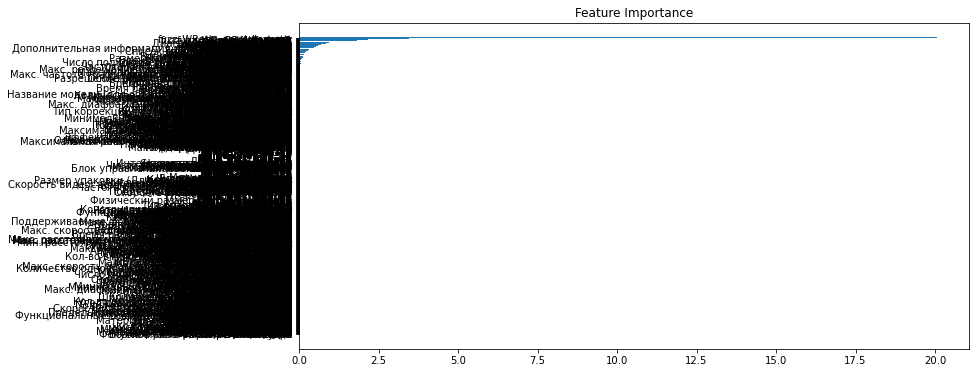

In [67]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(train.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

In [74]:
pd.DataFrame(data = {"feature_name": np.array(train.columns)[sorted_idx][-100:], "feature_importance" : feature_importance[sorted_idx][-100:]})

feature_name  feature_importance
0               cnt_overall_color            0.070170
1                   Тип подсветки            0.073767
2   Бренд графического процессора            0.073927
3                     Тип корпуса            0.074365
4                     Размеры, мм            0.077253
..                            ...                 ...
95      fuzz_partial_service_name            3.450045
96          fuzz_WRatio_diff_name            4.125194
97       fuzz_WRatio_service_name            5.566022
98                       lev_attr            6.436976
99                       bert_sat           20.056110

[100 rows x 2 columns]

In [62]:
plt.model.get_feature_importance()

array([ 0.05224974,  0.023943  ,  0.06914251, ..., 15.28424947,
        1.81836254,  1.52220586])

In [52]:
import gc
gc.collect()

2009

In [26]:
train.columns[7]

'cat_41'

In [30]:
train.drop(columns = ["target", "cat3_grouped", "cat_31", "cat_41"])

variantid1  variantid2  cnt_pics1  cnt_main_pics1  cnt_colors1  \
0         51197862    51198054        0.0               1            1   
1         51197862    51199884        0.0               1            1   
2         53602615   587809782        0.0               1            1   
3         53602615   615149925        0.0               1            1   
4         53888651    89598677       10.0               1            1   
...            ...         ...        ...             ...          ...   
286459   615000614   616345817        8.0               1            2   
286460   750300857   770648697        8.0               1            1   
286461   782207250   788610186        7.0               1            2   
286462   290682842   493998886        2.0               1            1   
286463   795255533   815518980        0.0               1            1   

        cnt_pics2  cnt_main_pics2  cnt_colors2  \
0             0.0               1            1   
1             0.0               1            1   
2             0.0               1            2   
3             0.0               1            1   
4             4.0               1            2   
...           ...             ...          ...   
286459       10.0               1            2   
286460        7.0               1            2   
286461        7.0               1            1   
286462        2.0               1            1   
286463        0.0               1            2   

                                            cat_32  \
0       Сетевые фильтры, разветвители и удлинители   
1       Сетевые фильтры, разветвители и удлинители   
2                             Расходник для печати   
3                             Расходник для печати   
4                                       Смарт-часы   
...                                            ...   
286459                        Кабели и переходники   
286460                                  Смарт-часы   
286461                                  Смарт-часы   
286462                                   Компьютер   
286463                                   Компьютер   

                                          cat_42  ... lev_ratio_diff_name  \
0       Сетевой фильтр, удлинитель, разветвитель  ...            0.875000   
1       Сетевой фильтр, удлинитель, разветвитель  ...            0.866667   
2                                       Картридж  ...            0.588235   
3                                       Картридж  ...            0.500000   
4                                     Умные часы  ...            0.000000   
...                                          ...  ...                 ...   
286459                                    Кабель  ...            0.500000   
286460                                Умные часы  ...            0.178571   
286461                                Умные часы  ...            0.150000   
286462                           Конфигуратор ПК  ...            0.693878   
286463                            Системный блок  ...            0.745763   

       fuzz_attr  fuzz_partial_attr  fuzz_token_attr  fuzz_WRatio_attr  \
0            0.0                0.0              0.0               0.0   
1          100.0              100.0            100.0               0.0   
2            6.0               50.0              7.0              42.0   
3            0.0                0.0              0.0               0.0   
4           29.0               31.0             41.0              86.0   
...          ...                ...              ...               ...   
286459      26.0               44.0             44.0              86.0   
286460       8.0               36.0              8.0              24.0   
286461      13.0               14.0             30.0              28.0   
286462      32.0               36.0             50.0              86.0   
286463      45.0               46.0             55.0              52.0   

        lev_attr  lev_ratio_attr  bert_sat    diff_id  

In [37]:
cat_features_idx

NameError: name 'cat_features_idx' is not defined

In [13]:
(train.iloc[0].to_numpy())[251]

'Сетевые фильтры, разветвители и удлинители'

In [12]:
cat_f = train.columns[np.where(np.array(list(map(lambda x: x not in train._get_numeric_data().columns, train.columns))))[0]]

In [13]:
cat_f = valid.columns[np.where(np.array(list(map(lambda x: x not in valid._get_numeric_data().columns, valid.columns))))[0]]

In [14]:
cat_f.to_list()

['cat3',
 'cat_31',
 'cat_41',
 'cat_32',
 'cat_42',
 'diff_name1',
 'diff_name2',
 'overall_color',
 'cat3_grouped',
 'diff_text_characteristics_1',
 'diff_text_characteristics_2',
 'clean_name_1',
 'service_name_1',
 'clean_name_2',
 'service_name_2',
 'diff_name_1',
 'diff_name_2',
 'for_col1',
 'maybe_model1',
 'eng_mod1',
 'for_col2',
 'maybe_model2',
 'eng_mod2']

In [21]:
dv = list(filter(lambda x: x not in train.columns, valid.columns))

In [15]:
dv = list(filter(lambda x: x not in df.columns, valid.columns))

In [17]:
valid[dv]

cat3  \
0                     Устройство ручного ввода   
1                             Видеорегистратор   
2            Зарядные устройства и док-станции   
3                         Наушники и гарнитуры   
4                                  Видеокамеры   
...                                        ...   
20204  Смартфоны, планшеты, мобильные телефоны   
20205        Зарядные устройства и док-станции   
20206                        Материнская плата   
20207                                    Чехол   
20208                    Карты памяти и флешки   

                                        cat_31  \
0                     Устройство ручного ввода   
1                             Видеорегистратор   
2            Зарядные устройства и док-станции   
3                         Наушники и гарнитуры   
4                                  Видеокамеры   
...                                        ...   
20204  Смартфоны, планшеты, мобильные телефоны   
20205        Зарядные устройства и док-станции   
20206                        Материнская плата   
20207                                    Чехол   
20208                    Карты памяти и флешки   

                                      cat_41  \
0                                       Мышь   
1                           Видеорегистратор   
2      Зарядное устройство для аккумуляторов   
3                                   Наушники   
4                                 Web-камера   
...                                      ...   
20204                               Смартфон   
20205              Компьютерный блок питания   
20206                      Материнская плата   
20207                    Чехол для смартфона   
20208                           Карта памяти   

                                        cat_32                     cat_42  \
0                     Устройство ручного ввода                       Мышь   
1                             Видеорегистратор           Видеорегистратор   
2            Зарядные устройства и док-станции        Зарядное устройство   
3                         Наушники и гарнитуры                   Наушники   
4                                  Видеокамеры                 Web-камера   
...                                        ...                        ...   
20204  Смартфоны, планшеты, мобильные телефоны                   Смартфон   
20205        Зарядные устройства и док-станции  Компьютерный блок питания   
20206                        Материнская плата          Материнская плата   
20207                                    Чехол        Чехол для смартфона   
20208                    Карты памяти и флешки               Карта памяти   

                                     diff_name1  \
0      (SBM-340AG-W) / 40 Smartbuy беспроводная   
1                                  NX01, черный   
2                            CW14, hoco красный   
3                                - беспроводные   
4                                Red Web-камера   
...                                         ...   
20204                               6/128 Y30S.   
20205                           AD-9019 Адаптер   
20206                   12 24 E5-2678 v3 потока   
20207                                  10 Prime   
20208                                     64 ГБ   

                                             diff_name2 overall_color  \
0      (SBM-340AG-W), SmartBuy белая белый компьютерная         белый   
1                                                  NX01        черный   
2                                           CW14 Черный        черный   
3                                       100-99091004-60         серый   
4             (Red) new package Интернет-камера красная           red   
...                                                 ...           ...   
20204                                       6/64 Y30S..       зеленый   
20205                      (совместимый) 0455A1990 Блок        черный   
20206                          14 28 E5-2680 v4 потоков             

In [121]:
train.columns[1277]

'bert_diff_characteristics'

In [ ]:
np.where(np.array(list(map(lambda x: x.startswith("cat") or "diff" in x or x.startswith("diff_name")  or x.startswith("overall_color")

In [23]:
train._get_numeric_data().columns

Index(['variantid1', 'variantid2', 'cnt_pics1', 'cnt_main_pics1',
       'cnt_colors1', 'cnt_pics2', 'cnt_main_pics2', 'cnt_colors2',
       'fuzz_name', 'fuzz_partial_name',
       ...
       'lev_maybe_model', 'lev_ratio_maybe_model', 'fuzz_eng_mod',
       'fuzz_partial_eng_mod', 'fuzz_token_eng_mod', 'fuzz_WRatio_eng_mod',
       'lev_eng_mod', 'lev_ratio_eng_mod', 'attr_emb_correlation',
       'attr_emb_cosine'],
      dtype='object', length=1327)

In [ ]:
test_pairs = test_pairs.merge(test_features[["categories", 'variantid']].add_suffix('1'),on="variantid1")

In [41]:
test.head()

variantid1  variantid2                             cat3_grouped   weights  \
0    52076340   290590137                 Батарейки и аккумуляторы  0.032957   
1    64525522   204128919  Смартфоны, планшеты, мобильные телефоны  0.051150   
2    77243372   479860557                     Кабели и переходники  0.059611   
3    86065820   540678372                 Устройство ручного ввода  0.022838   
4    91566575   258840506  Смартфоны, планшеты, мобильные телефоны  0.051150   

   cnt_pics1  cnt_main_pics1  cnt_colors1  \
0        1.0               1            1   
1        4.0               1            3   
2        3.0               1            2   
3       14.0               1            1   
4        1.0               1            2   

                                    cat_31     cat_41  cnt_pics2  ...  \
0                 Батарейки и аккумуляторы  Батарейка        1.0  ...   
1  Смартфоны, планшеты, мобильные телефоны   Смартфон        1.0  ...   
2                     Кабели и переходники     Кабель        0.0  ...   
3                 Устройство ручного ввода       Мышь        4.0  ...   
4  Смартфоны, планшеты, мобильные телефоны   Смартфон        1.0  ...   

   lev_maybe_model  lev_ratio_maybe_model fuzz_eng_mod fuzz_partial_eng_mod  \
0              NaN                    NaN         86.0                 82.0   
1              NaN                    NaN         94.0                 94.0   
2              NaN                    NaN         21.0                100.0   
3              NaN                    NaN         68.0                 73.0   
4              NaN                    NaN         76.0                 75.0   

  fuzz_token_eng_mod fuzz_WRatio_eng_mod  lev_eng_mod  lev_ratio_eng_mod  \
0               86.0                89.0          8.0           0.862069   
1               94.0                94.0          1.0           0.937500   
2               21.0                60.0         31.0           0.205128   
3               64.0                70.0          9.0           0.680851   
4               57.0                86.0          5.0           0.761905   

   attr_emb_correlation  attr_emb_cosine  
0              0.111711         0.107950  
1              0.171204         0.169769  
2              0.156773         0.157125  
3              0.092685         0.093261  
4              0.186990         0.187019  

[5 rows x 1349 columns]

In [42]:
valid.head()

target  variantid1  variantid2                               cat3  \
0     1.0    78292644   311184051           Устройство ручного ввода   
1     1.0    78509805    90849346                   Видеорегистратор   
2     1.0    89722250   177811799  Зарядные устройства и док-станции   
3     1.0    91147277   473287073               Наушники и гарнитуры   
4     1.0    91630181   388828373                        Видеокамеры   

   cnt_pics1  cnt_main_pics1  cnt_colors1                             cat_31  \
0        1.0               1            1           Устройство ручного ввода   
1        3.0               1            1                   Видеорегистратор   
2        2.0               1            3  Зарядные устройства и док-станции   
3        0.0               1            2               Наушники и гарнитуры   
4        3.0               1            1                        Видеокамеры   

                                  cat_41  cnt_pics2  ...  lev_maybe_model  \
0                                   Мышь        5.0  ...              NaN   
1                       Видеорегистратор        7.0  ...              NaN   
2  Зарядное устройство для аккумуляторов        0.0  ...              NaN   
3                               Наушники        1.0  ...              NaN   
4                             Web-камера        1.0  ...              NaN   

   lev_ratio_maybe_model fuzz_eng_mod fuzz_partial_eng_mod fuzz_token_eng_mod  \
0                    NaN         71.0                100.0               71.0   
1                    NaN         74.0                100.0               74.0   
2                    NaN         67.0                 67.0               67.0   
3                    NaN         66.0                 85.0               77.0   
4                    NaN         77.0                100.0               77.0   

  fuzz_WRatio_eng_mod  lev_eng_mod  lev_ratio_eng_mod  attr_emb_correlation  \
0                90.0         15.0           0.705882              0.089074   
1                90.0          5.0           0.736842              0.014664   
2                95.0          4.0           0.666667              0.092817   
3                86.0         24.0           0.657143              0.098653   
4                90.0         12.0           0.769231              0.007584   

   attr_emb_cosine  
0         0.090779  
1         0.015029  
2         0.092035  
3         0.099749  
4         0.007369  

[5 rows x 1351 columns]